## Variational Autoencoder Model

In [1]:
# dependencies
from utils.paths import project_root
from dataloaders.sliding_window import LogsSlidingWindow
from utils.plots import plot_anomaly_detection_analysis, plot_failure_analysis, plot_future_failure_analysis
from dataloaders.bert import BertLogEmbedder

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import polars as pl
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd

import os
import gc

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

import optuna
from optuna.samplers import TPESampler

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from sklearn.metrics import (average_precision_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
                        classification_report, auc, f1_score, precision_score, recall_score)
from sklearn.model_selection import KFold, TimeSeriesSplit, ParameterGrid
import seaborn as sns

import itertools
import gc
import copy
import matplotlib.pyplot as plt

/home/paulofr/miniforge3/envs/MLP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# configuration
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

assert pyro.__version__.startswith('1.9.1')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
smoke_test = 'CI' in os.environ

Using device: cuda


In [3]:
# loading and preparing the data
df = pl.read_csv(f"{project_root()}/data/parsed/cleaned_BGL_structured.csv")[['Timestamp', 'EventId', 'Label', 'Content']]

# convert Timestamp to polars Timestamp
df = df.with_columns(
    pl.from_epoch(pl.col("Timestamp"), time_unit="s").alias("Timestamp")
)

# filter only logs without anomaly labels "-"
df_all = df.with_columns(
    (pl.col("Label") != "-").alias("Anomaly")
)

df_all.head()

Timestamp,EventId,Label,Content,Anomaly
datetime[μs],str,str,str,bool
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false


In [4]:
# train test spit
split_point = int(len(df_all) * 0.8)
train_df = df_all[:split_point]
test_df = df_all[split_point:]

In [5]:
# auxiliary functions to try load all data into vram or use batches
def get_available_vram_gb():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
        return free_mem / (1024**3)
    return 0

def estimate_tensor_size_gb(shape, dtype=torch.float32):
    bytes_per_element = torch.tensor([], dtype=dtype).element_size()
    total_elements = 1
    for dim in shape:
        total_elements *= dim
    return (total_elements * bytes_per_element) / (1024**3)

def precompute_windows(dataset):
    print(f"Pre-computing {len(dataset)} windows...")
    
    n_samples = len(dataset)
    input_dim = dataset.input_dim
    n_failures = dataset.n_failure_types
    
    X = torch.zeros((n_samples, input_dim), dtype=torch.float32)
    y = torch.zeros((n_samples,), dtype=torch.long)
    pred_types = torch.zeros((n_samples), dtype=torch.long)
    failure_types = torch.zeros((n_samples, n_failures), dtype=torch.float32)
    
    for i in tqdm(range(n_samples)):
        count_vec, label, pred_type, failure_types_vec = dataset[i]
        X[i] = count_vec
        y[i] = label
        pred_types[i] = pred_type
        failure_types[i] = failure_types_vec
        
    print("Dataset converted to Tensor")
    return X, y, pred_types, failure_types

In [6]:
# create datasets
def load_dataset(
        train_dataframe: pl.DataFrame,
        test_dataframe: pl.DataFrame,
        window_size='5m', 
        step_size='1m',
        n_prediction_window=3, 
        filter_strategy='label', 
        filter_params={'contamination': 0.01},
        batch_size=4096,
        embedder=None,
        mode='count',
        debug=False
    ) -> dict:
    
    train_dataset = LogsSlidingWindow(
        train_dataframe, 
        window_size=window_size,   
        step_size=step_size,
        n_prediction_window=n_prediction_window,
        filter_strategy=filter_strategy,
        filter_params=filter_params,
        embedder=embedder,
        mode=mode
    )

    train_event_ids = train_dataset.event_ids
    INPUT_DIM = train_dataset.input_dim

    test_dataset = LogsSlidingWindow(
        test_dataframe,
        window_size=window_size,
        step_size=step_size, 
        n_prediction_window=n_prediction_window,
        event_ids=train_event_ids,  # use same event IDs as training set
        filter_strategy='none', # keep all logs for evaluation
        embedder=embedder,
        mode=mode
    )

    X_train, y_train, pred_types_train, failure_types_train = precompute_windows(train_dataset)
    X_test, y_test, pred_types_test, failure_types_test = precompute_windows(test_dataset)

    available_vram = get_available_vram_gb()
    train_size_gb = estimate_tensor_size_gb(X_train.shape, X_train.dtype)
    test_size_gb = estimate_tensor_size_gb(X_test.shape, X_test.dtype)
    total_size_gb = train_size_gb + test_size_gb

    safety_factor = 1.4
    required_vram = total_size_gb * safety_factor

    if debug:
        print(f"Available VRAM: {available_vram:.2f} GB")
        print(f"Required VRAM: {required_vram:.2f} GB (train: {train_size_gb:.2f} GB, test: {test_size_gb:.2f} GB)")

    USE_VRAM = required_vram < available_vram
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == 'cuda' and USE_VRAM:
        if debug:
            print("Sufficient VRAM available - loading data to GPU")
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        return {
            "mode": "tensor",
            "device": device,
            "input_dim": INPUT_DIM,
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
            "pred_types_train": pred_types_train,
            "pred_types_test": pred_types_test,
            "failure_types_train": failure_types_train,
            "failure_types_test": failure_types_test,
            "failure_map_train": train_dataset.get_failure_map(),
            "failure_map_test": test_dataset.get_failure_map(),
        }
    
    if debug:
        print("Insufficient VRAM or unavailable GPU - using DataLoader")
    batch_size = batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=(device.type == "cuda"))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=(device.type == "cuda"))

    return {
        "mode": "dataloader",
        "device": device,
        "input_dim": INPUT_DIM,
        "train_dataset": train_dataset,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "pred_types_train": pred_types_train,
        "pred_types_test": pred_types_test,
        "failure_types_train": failure_types_train,
        "failure_types_test": failure_types_test,
        "failure_map_train": train_dataset.get_failure_map,
        "failure_map_test": test_dataset.get_failure_map,
    }


In [7]:
def get_vram_batches(X, batch_size=4096, shuffle=True):
    n_samples = X.shape[0]
    indices = torch.arange(n_samples, device=X.device)
    
    if shuffle:
        indices = torch.randperm(n_samples, device=X.device)
        
    for start_idx in range(0, n_samples, batch_size):
        batch_indices = indices[start_idx : start_idx + batch_size]
        yield X[batch_indices]

## Variational Autoencoder Neural Network

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_loc = nn.Linear(hidden_dim, z_dim)    # latent mean
        self.fc2_scale = nn.Linear(hidden_dim, z_dim)  # latent scale
        self.activation = nn.LeakyReLU(0.2)
        self.bn = nn.BatchNorm1d(input_dim)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)

        x = self.bn(x)

        hidden = self.activation(self.fc1(x))
        z_loc = self.fc2_loc(hidden)

        z_log_scale = self.fc2_scale(hidden)

        z_log_scale = torch.clamp(z_log_scale, min=-2, max=2)

        # we need positive scale, so we exponentiate the output
        z_scale = torch.exp(z_log_scale)

        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        
        # predicts the reconstructed value (mean)
        self.fc_loc = nn.Linear(hidden_dim, input_dim)
        
        # predicts the variance/scale
        self.fc_scale = nn.Linear(hidden_dim, input_dim)
        
        self.activation = nn.LeakyReLU(0.2)
        self.softplus = nn.Softplus()

    def forward(self, z):
        hidden = self.activation(self.fc1(z))
        
        # reconstructed Mean
        loc_img = self.softplus(self.fc_loc(hidden))
        
        # reconstructed variance/scale
        log_scale = self.fc_scale(hidden)
        log_scale = torch.clamp(log_scale, min=-5, max=2)  
        scale_img = torch.exp(log_scale)
        
        return loc_img, scale_img

In [9]:
class LogAnomalyVAE(nn.Module):
    def __init__(self, input_dim=390, z_dim=32, hidden_dim=128, use_cuda=False):
        super().__init__()
        self.encoder = Encoder(input_dim, z_dim, hidden_dim)
        self.decoder = Decoder(input_dim, z_dim, hidden_dim)
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        if use_cuda:
            self.cuda()
            
    def model(self, x):
        pyro.module("decoder", self.decoder)        
        with pyro.plate("data", x.shape[0]):
            # prior: normal N(0, 1)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            
            # sample latent Z
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # decode z -> predicted mean and variance for the logs
            recon_loc, recon_scale = self.decoder(z)
            
            # observe 'x' (the real log-counts)
            pyro.sample("obs", dist.Normal(recon_loc, recon_scale).to_event(1), 
                        obs=x.reshape(-1, self.input_dim))

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use encoder to guess Z
            z_loc, z_scale = self.encoder(x)
            
            # sample Z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def get_anomaly_score(self, x, n_samples=10):
        x = x.to(next(self.parameters()).device)
        
        z_loc, z_scale = self.encoder(x)
        q_z = dist.Normal(z_loc, z_scale)
        
        # sample multiple z's at once [n_samples, batch_size, z_dim]
        z = q_z.rsample((n_samples,))
        
        # decode all samples [n_samples * batch_size, input_dim]
        z_flat = z.reshape(-1, self.z_dim)
        recon_loc, recon_scale = self.decoder(z_flat)
        
        # reshape to [n_samples, batch_size, input_dim]
        recon_loc = recon_loc.reshape(n_samples, x.shape[0], -1)
        recon_scale = recon_scale.reshape(n_samples, x.shape[0], -1)
        
        # reconstruction log likelihood: log p(x|z)
        x_expanded = x.reshape(1, x.shape[0], -1).expand(n_samples, -1, -1)
        log_p_x_given_z = dist.Normal(recon_loc, recon_scale).log_prob(x_expanded).sum(dim=-1)
        
        # KL divergence: KL(q(z|x) || p(z)) where p(z) = N(0, I)
        prior = dist.Normal(
            torch.zeros_like(z_loc), 
            torch.ones_like(z_scale)
        )
        kl_div = torch.distributions.kl_divergence(q_z, prior).sum(dim=-1)
        
        # ELBO = E[log p(x|z)] - KL(q(z|x) || p(z))
        # anomaly score = -ELBO (higher = more anomalous)
        elbo = log_p_x_given_z.mean(dim=0) - kl_div
        
        return -elbo

## Training and Evaluating

In [10]:
def train_vae(
    vae,
    data,
    num_epochs=150,
    batch_size=4096,
    lr=1e-3,
    debug=False
):
    pyro.clear_param_store()

    optimizer = Adam({"lr": lr})
    svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

    epoch_losses = []
    epoch_iter = range(num_epochs)
    if debug:
        epoch_iter = tqdm(epoch_iter, desc="Training VAE", leave=True)


    for epoch in epoch_iter:
        epoch_loss = 0.0
        num_samples = 0

        if data["mode"] == "tensor":
            X_train = data["X_train"]

            for x_batch in get_vram_batches(
                X_train,
                batch_size=batch_size,
                shuffle=True
            ):
                loss = svi.step(x_batch)
                epoch_loss += loss
                num_samples += x_batch.size(0)

        else:
            train_loader = data["train_loader"]
            device = data["device"]

            for x_batch, *_ in train_loader:
                x_batch = x_batch.to(device, non_blocking=True)
                loss = svi.step(x_batch)
                epoch_loss += loss
                num_samples += x_batch.size(0)

        avg_loss = epoch_loss / num_samples
        epoch_losses.append(avg_loss)

    vae.eval() 
    total_clean_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():
        if data["mode"] == "tensor":
             for x_batch in get_vram_batches(data["X_train"], batch_size=4096, shuffle=False):
                 total_clean_loss += svi.evaluate_loss(x_batch)
                 total_samples += x_batch.size(0)
        else:
             for x_batch, *_ in data["train_loader"]:
                 x_batch = x_batch.to(data["device"])
                 total_clean_loss += svi.evaluate_loss(x_batch)
                 total_samples += x_batch.size(0)

    if debug:
        final_clean_loss = total_clean_loss / total_samples
        print(f"Final Standardized Train Loss: {final_clean_loss:.4f}")

        plt.figure(figsize=(12, 8))
        plt.plot(epoch_losses, linewidth=2)
        plt.xlabel("Epoch")
        plt.ylabel("Average ELBO Loss")
        plt.title("VAE Training Loss")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return epoch_losses

In [11]:
def test_vae(
    vae,
    data,
    eval_batch_size=8192
):
    print("Starting evaluation...")
    vae.eval()

    all_scores = []
    all_labels = []

    with torch.no_grad():
        if data["mode"] == "tensor":
            X_test = data["X_test"]
            y_test = data["y_test"]

            num_samples = X_test.shape[0]

            for start_idx in range(0, num_samples, eval_batch_size):
                end_idx = min(start_idx + eval_batch_size, num_samples)

                x_batch = X_test[start_idx:end_idx]
                y_batch = y_test[start_idx:end_idx]

                scores = vae.get_anomaly_score(x_batch)

                all_scores.append(scores)
                all_labels.append(y_batch)

        else:
            test_loader = data["test_loader"]
            device = data["device"]

            for x_batch, y_batch, *_ in test_loader:
                x_batch = x_batch.to(device, non_blocking=True)

                scores = vae.get_anomaly_score(x_batch)

                all_scores.append(scores)
                all_labels.append(y_batch)

    scores = torch.cat(all_scores).cpu().numpy()
    labels = torch.cat(all_labels).cpu().numpy()

    print(f"Evaluation complete. Processed {len(scores)} samples.")

    return scores, labels

## Bayesian Hyperparameter Tuning

In [12]:
def tune_vae_optuna(data, model_search_space, n_splits=3, gap_windows=5, 
                    n_trials=20, timeout=None):

    kf = KFold(n_splits=n_splits, shuffle=False)
    device = data["device"]
    
    if data["mode"] == "tensor":
        X_all = data["X_train"] 
        total_samples = X_all.size(0)
        print(f"Usando slicing direto em VRAM: {total_samples} samples")
    else:
        if "train_dataset" not in data:
            raise ValueError("Modo 'dataloader' requer 'train_dataset' para CV.")
        dataset = data["train_dataset"]
        total_samples = len(dataset)
        print("Usando DataLoader Subsets (mais lento)")

    indices = np.arange(total_samples)
    
    def objective(trial):
        params = {}
        
        # z_dim
        if len(model_search_space['z_dim']) == 2:
            params['z_dim'] = trial.suggest_int('z_dim', 
                                                model_search_space['z_dim'][0],
                                                model_search_space['z_dim'][1])
        else:
            params['z_dim'] = model_search_space['z_dim'][0]
        
        # hidden_dim
        if len(model_search_space['hidden_dim']) == 2:
            params['hidden_dim'] = trial.suggest_int('hidden_dim',
                                                     model_search_space['hidden_dim'][0],
                                                     model_search_space['hidden_dim'][1])
        else:
            params['hidden_dim'] = model_search_space['hidden_dim'][0]
        
        # lr
        if len(model_search_space['lr']) == 2:
            params['lr'] = trial.suggest_float('lr',
                                               model_search_space['lr'][0],
                                               model_search_space['lr'][1],
                                               log=True)
        else:
            params['lr'] = model_search_space['lr'][0]
        
        # batch_size
        if len(model_search_space['batch_size']) > 1:
            params['batch_size'] = trial.suggest_categorical('batch_size',
                                                             model_search_space['batch_size'])
        else:
            params['batch_size'] = model_search_space['batch_size'][0]
        
        # epochs
        if len(model_search_space['epochs']) == 2:
            params['epochs'] = trial.suggest_int('epochs',
                                                 model_search_space['epochs'][0],
                                                 model_search_space['epochs'][1])
        else:
            params['epochs'] = model_search_space['epochs'][0]
        
        print(f"\n{'='*60}")
        print(f"Trial {trial.number + 1}: z_dim={params['z_dim']}, "
              f"hidden_dim={params['hidden_dim']}, lr={params['lr']:.2e}, "
              f"batch_size={params['batch_size']}, epochs={params['epochs']}")
        print(f"{'='*60}")
        
        fold_losses = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices)):
            pyro.clear_param_store()
            
            # time gap
            val_start = val_idx.min()
            val_end = val_idx.max()
            mask_safe = ~((train_idx >= val_start - gap_windows) & 
                         (train_idx <= val_end + gap_windows))
            train_idx_purged = train_idx[mask_safe]
            
            vae = LogAnomalyVAE(
                input_dim=data['input_dim'],
                z_dim=params['z_dim'],
                hidden_dim=params['hidden_dim'],
                use_cuda=(device.type == "cuda")
            )
            
            optimizer = Adam({"lr": params['lr']})
            svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
            
            if data["mode"] == "tensor":
                X_fold_train = X_all[train_idx_purged]
                X_fold_val = X_all[val_idx]
                
                for epoch in range(params['epochs']):
                    epoch_loss = 0.0
                    num_samples = 0
                    
                    for x_batch in get_vram_batches(X_fold_train, 
                                                    params['batch_size'], 
                                                    shuffle=True):
                        loss = svi.step(x_batch)
                        epoch_loss += loss
                        num_samples += x_batch.size(0)
                    
                    if epoch == params['epochs'] - 1:
                        avg_epoch_loss = epoch_loss / num_samples
                        print(f"  Fold {fold_idx+1} - Época final: {avg_epoch_loss:.2f}")
                
                val_loss = 0.0
                val_samples = 0
                for x_val_batch in get_vram_batches(X_fold_val, 
                                                    batch_size=4096, 
                                                    shuffle=False):
                    val_loss += svi.evaluate_loss(x_val_batch)
                    val_samples += x_val_batch.size(0)
                
                avg_val_loss = val_loss / val_samples
                
            else:
                train_sub = Subset(dataset, train_idx_purged)
                val_sub = Subset(dataset, val_idx)
                
                train_loader = DataLoader(train_sub, 
                                        batch_size=params['batch_size'], 
                                        shuffle=True, 
                                        num_workers=0)
                val_loader = DataLoader(val_sub, 
                                      batch_size=4096, 
                                      shuffle=False, 
                                      num_workers=0)
                
                for epoch in range(params['epochs']):
                    epoch_loss = 0.0
                    num_samples = 0
                    for x_batch, *_ in train_loader:
                        x_batch = x_batch.to(device)
                        loss = svi.step(x_batch)
                        epoch_loss += loss
                        num_samples += x_batch.size(0)
                    
                    if epoch == params['epochs'] - 1:
                        avg_epoch_loss = epoch_loss / num_samples
                        print(f"  Fold {fold_idx+1} - Época final: {avg_epoch_loss:.2f}")
                
                val_loss = 0.0
                val_samples = 0
                for x_batch, *_ in val_loader:
                    x_batch = x_batch.to(device)
                    val_loss += svi.evaluate_loss(x_batch)
                    val_samples += x_batch.size(0)
                
                avg_val_loss = val_loss / val_samples
            
            fold_losses.append(avg_val_loss)
            print(f"  Fold {fold_idx+1} - Loss validação: {avg_val_loss:.2f}")
            
            # report intermediate value to oputna for pruning
            trial.report(avg_val_loss, fold_idx)
            if trial.should_prune():
                print(f"  Trial {trial.number + 1} foi podado (pruned)!")
                raise optuna.TrialPruned()
        
        avg_loss = np.mean(fold_losses)
        print(f"→ Loss mediana CV: {avg_loss:.4f}")
        
        return avg_loss
    
    print(f"\n{'#'*60}")
    print(f"STARTING OPTUNA OPTIMIZATION: ({n_trials} trials)")
    print(f"{'#'*60}\n")
    
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    
    study.optimize(
        objective, 
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    best_params = study.best_params
    best_loss = study.best_value
    
    print(f"\n{'#'*60}")
    print(f"BEST PARAMS:")
    print(f"{'#'*60}")
    print(f"Params: {best_params}")
    print(f"Loss: {best_loss:.4f}")
    print(f"Trial: {study.best_trial.number + 1}")
    print(f"Trials completed: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    print(f"Trials pruned: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
    print(f"{'#'*60}\n")
    
    return best_params, best_loss, study

In [13]:
def run_nested_grid_search(train_df, test_df, dataset_grid, model_grid, full_training_epochs=120):
    results = []    
    keys, values = zip(*dataset_grid.items())
    ds_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"total dataset configurations: {len(ds_combinations)}")
    
    for i, ds_params in enumerate(ds_combinations):
        print(f"\n{'='*50}")
        print(f"OUTER LOOP {i+1}/{len(ds_combinations)}")
        print(f"params: {ds_params}")
        print(f"{'='*50}")
        
        data = None
        vae = None

        # constant windows horizon and batch_size
        PREDICTION_WINDOW = 5
        BATCH_SIZE = 4096
    
        try:
            embedder = BertLogEmbedder()
            embedder.fit(train_df)

            data = load_dataset(
                train_df,
                test_df,
                window_size=ds_params['window_size'],
                step_size=ds_params['step_size'],
                n_prediction_window=PREDICTION_WINDOW,
                filter_strategy=ds_params['filter_strategy'],
                filter_params=ds_params['filter_params'],
                batch_size=BATCH_SIZE,
                embedder=embedder,
                mode=ds_params['mode']
            )
            
            if data['mode'] == 'tensor':
                n_pred = PREDICTION_WINDOW
                w_mins = int(ds_params['window_size'].replace('m','')) # assuming 'm' format
                s_mins = int(ds_params['step_size'].replace('m',''))
                
                window_indices = w_mins // s_mins
                gap_indices = window_indices + n_pred
            else:
                ds = data['train_dataset']
                gap_seconds = ds.window_size.total_seconds() + ds.prediction_horizon.total_seconds()
                step_seconds = ds.step_size.total_seconds()
                gap_indices = int(gap_seconds / step_seconds)

            print("-- running inner optum for model params...")
            best_model_params, best_cv_loss, study = tune_vae_optuna(data, model_grid, gap_windows=gap_indices)
                        
            print("-- retraining best model on full")
            vae = LogAnomalyVAE(
                input_dim=data['input_dim'],
                z_dim=best_model_params['z_dim'],
                hidden_dim=best_model_params['hidden_dim'],
                use_cuda=(data["device"].type == "cuda")
            )
            
            train_vae(
                vae, 
                data, 
                num_epochs=full_training_epochs, 
                batch_size=BATCH_SIZE,
                lr=best_model_params['lr']
            )
            
            print("-- evaluating on test set...")
            scores, labels = test_vae(vae, data, eval_batch_size=8192)
            
            roc = roc_auc_score(labels, scores)
            pr_auc = average_precision_score(labels, scores)
            
            print(f"--> RESULT: ROC AUC: {roc:.4f} | PR AUC: {pr_auc:.4f}")
            
            results.append({
                **ds_params,
                **best_model_params,
                'cv_reconstruction_loss': best_cv_loss,
                'test_roc_auc': roc,
                'test_pr_auc': pr_auc,
            })
            
        except Exception as e:
            print(f"CRASHED on config {ds_params} !!!")
            print(e)
            import traceback
            traceback.print_exc()
            
        finally:            
            if vae is not None: del vae
            if data is not None: del data
            gc.collect()
            torch.cuda.empty_cache()
                
    return pd.DataFrame(results)

In [14]:
opt_dataset_grid = {
    'window_size': ['5m', '10m'],
    'step_size': ['1m'],
    'filter_strategy': ['combined'],
    'filter_params': [{'contamination':0.1}, {'contamination':0.05}],
    'mode': ['count', 'hybrid']
}

opt_model_grid = {
    'z_dim': [8, 128],
    'hidden_dim': [32, 512],
    'lr': [1e-4, 1e-3],
    'batch_size': [4096],
    'epochs': [30]
}

results = run_nested_grid_search(
    train_df,
    test_df,
    opt_dataset_grid,
    opt_model_grid,
    full_training_epochs=100
)
results.to_csv('optim.csv')
results

total dataset configurations: 8

OUTER LOOP 1/8
params: {'window_size': '5m', 'step_size': '1m', 'filter_strategy': 'combined', 'filter_params': {'contamination': 0.1}, 'mode': 'count'}
Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:29<00:00, 142.49it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220344 sliding windows
Building index...
Index built. Shape: (220344, 3)
Isolation Forest: Removed 21076 windows (9.6%)
Remaining windows: 199268
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERNF

100%|██████████| 199268/199268 [00:20<00:00, 9622.75it/s] 


Dataset converted to Tensor
Pre-computing 88844 windows...


100%|██████████| 88844/88844 [00:09<00:00, 9855.40it/s] 
[I 2026-01-07 19:04:30,905] A new study created in memory with name: no-name-15718f6b-4f9c-4641-ac2d-12be742549c7


Dataset converted to Tensor
-- running inner optum for model params...
Usando slicing direto em VRAM: 199268 samples

############################################################
STARTING OPTUNA OPTIMIZATION: (20 trials)
############################################################



  0%|          | 0/20 [00:00<?, ?it/s]


Trial 1: z_dim=53, hidden_dim=489, lr=5.40e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1172.64
  Fold 1 - Loss validação: 1928.06
  Fold 2 - Época final: -1160.81
  Fold 2 - Loss validação: -380.41


Best trial: 0. Best value: 572.237:   5%|▌         | 1/20 [00:11<03:38, 11.50s/it]

  Fold 3 - Época final: -1146.68
  Fold 3 - Loss validação: 169.06
→ Loss mediana CV: 572.2370
[I 2026-01-07 19:04:42,404] Trial 0 finished with value: 572.2370088711394 and parameters: {'z_dim': 53, 'hidden_dim': 489, 'lr': 0.0005395030966670229}. Best is trial 0 with value: 572.2370088711394.

Trial 2: z_dim=80, hidden_dim=107, lr=1.43e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1123.66
  Fold 1 - Loss validação: 2769.40
  Fold 2 - Época final: -1097.16
  Fold 2 - Loss validação: -32.19


Best trial: 0. Best value: 572.237:  10%|█         | 2/20 [00:22<03:21, 11.19s/it]

  Fold 3 - Época final: -1116.13
  Fold 3 - Loss validação: -285.34
→ Loss mediana CV: 817.2923
[I 2026-01-07 19:04:53,373] Trial 1 finished with value: 817.2923091935933 and parameters: {'z_dim': 80, 'hidden_dim': 107, 'lr': 0.00014321698289111514}. Best is trial 0 with value: 572.2370088711394.

Trial 3: z_dim=15, hidden_dim=448, lr=3.99e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1173.67
  Fold 1 - Loss validação: 2917.03
  Fold 2 - Época final: -1168.27
  Fold 2 - Loss validação: -140.87


Best trial: 0. Best value: 572.237:  15%|█▌        | 3/20 [00:33<03:08, 11.08s/it]

  Fold 3 - Época final: -1175.37
  Fold 3 - Loss validação: 50.04
→ Loss mediana CV: 942.0659
[I 2026-01-07 19:05:04,329] Trial 2 finished with value: 942.0659280272162 and parameters: {'z_dim': 15, 'hidden_dim': 448, 'lr': 0.0003991305878561678}. Best is trial 0 with value: 572.2370088711394.

Trial 4: z_dim=93, hidden_dim=41, lr=9.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1131.50
  Fold 1 - Loss validação: 3773.39
  Fold 2 - Época final: -1149.19
  Fold 2 - Loss validação: -160.32


Best trial: 0. Best value: 572.237:  20%|██        | 4/20 [00:44<02:55, 10.99s/it]

  Fold 3 - Época final: -1135.08
  Fold 3 - Loss validação: -143.07
→ Loss mediana CV: 1156.6685
[I 2026-01-07 19:05:15,169] Trial 3 finished with value: 1156.668505309556 and parameters: {'z_dim': 93, 'hidden_dim': 41, 'lr': 0.0009330606024425672}. Best is trial 0 with value: 572.2370088711394.

Trial 5: z_dim=108, hidden_dim=134, lr=1.52e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1138.09
  Fold 1 - Loss validação: 3471.09
  Fold 2 - Época final: -1126.22
  Fold 2 - Loss validação: 342.04


Best trial: 0. Best value: 572.237:  25%|██▌       | 5/20 [00:55<02:43, 10.92s/it]

  Fold 3 - Época final: -1123.06
  Fold 3 - Loss validação: -793.76
→ Loss mediana CV: 1006.4577
[I 2026-01-07 19:05:25,971] Trial 4 finished with value: 1006.4576677419863 and parameters: {'z_dim': 108, 'hidden_dim': 134, 'lr': 0.0001519934830130982}. Best is trial 0 with value: 572.2370088711394.

Trial 6: z_dim=30, hidden_dim=178, lr=3.35e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1163.61
  Fold 1 - Loss validação: 2310.73
  Fold 2 - Época final: -1143.58
  Fold 2 - Loss validação: -545.65


Best trial: 5. Best value: 394.089:  30%|███       | 6/20 [01:05<02:31, 10.84s/it]

  Fold 3 - Época final: -1151.41
  Fold 3 - Loss validação: -582.82
→ Loss mediana CV: 394.0891
[I 2026-01-07 19:05:36,650] Trial 5 finished with value: 394.0890526633521 and parameters: {'z_dim': 30, 'hidden_dim': 178, 'lr': 0.0003347776308515934}. Best is trial 5 with value: 394.0890526633521.

Trial 7: z_dim=60, hidden_dim=172, lr=4.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1165.97
  Fold 1 - Loss validação: 3444.73
  Fold 2 - Época final: -1160.95
  Fold 2 - Loss validação: 80.82


Best trial: 5. Best value: 394.089:  35%|███▌      | 7/20 [01:16<02:20, 10.82s/it]

  Fold 3 - Época final: -1157.59
  Fold 3 - Loss validação: -306.25
→ Loss mediana CV: 1073.0980
[I 2026-01-07 19:05:47,434] Trial 6 finished with value: 1073.0980126814281 and parameters: {'z_dim': 60, 'hidden_dim': 172, 'lr': 0.00040912205744437856}. Best is trial 5 with value: 394.0890526633521.

Trial 8: z_dim=24, hidden_dim=172, lr=2.32e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1161.06
  Fold 1 - Loss validação: 2405.96
  Fold 2 - Época final: -1153.92
  Fold 2 - Loss validação: -27.58


Best trial: 5. Best value: 394.089:  40%|████      | 8/20 [01:27<02:09, 10.80s/it]

  Fold 3 - Época final: -1155.52
  Fold 3 - Loss validação: -671.40
→ Loss mediana CV: 568.9945
[I 2026-01-07 19:05:58,191] Trial 7 finished with value: 568.9945115302567 and parameters: {'z_dim': 24, 'hidden_dim': 172, 'lr': 0.0002324672848950435}. Best is trial 5 with value: 394.0890526633521.

Trial 9: z_dim=63, hidden_dim=409, lr=1.58e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1163.26
  Fold 1 - Loss validação: 3055.74
  Fold 2 - Época final: -1160.95
  Fold 2 - Loss validação: -607.72


Best trial: 5. Best value: 394.089:  45%|████▌     | 9/20 [01:38<01:59, 10.88s/it]

  Fold 3 - Época final: -1154.77
  Fold 3 - Loss validação: -53.23
→ Loss mediana CV: 798.2638
[I 2026-01-07 19:06:09,258] Trial 8 finished with value: 798.2637795051292 and parameters: {'z_dim': 63, 'hidden_dim': 409, 'lr': 0.0001583703155911876}. Best is trial 5 with value: 394.0890526633521.

Trial 10: z_dim=70, hidden_dim=316, lr=1.11e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1149.84
  Fold 1 - Loss validação: 2955.94
  Fold 2 - Época final: -1138.26
  Fold 2 - Loss validação: -470.31


Best trial: 5. Best value: 394.089:  50%|█████     | 10/20 [01:49<01:48, 10.88s/it]

  Fold 3 - Época final: -1134.95
  Fold 3 - Loss validação: -873.09
→ Loss mediana CV: 537.5130
[I 2026-01-07 19:06:20,123] Trial 9 finished with value: 537.5129922014097 and parameters: {'z_dim': 70, 'hidden_dim': 316, 'lr': 0.00011128853174905746}. Best is trial 5 with value: 394.0890526633521.

Trial 11: z_dim=33, hidden_dim=259, lr=2.49e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1165.27
  Fold 1 - Loss validação: 2797.55
  Fold 2 - Época final: -1161.63
  Fold 2 - Loss validação: -258.86


Best trial: 5. Best value: 394.089:  55%|█████▌    | 11/20 [02:00<01:38, 10.93s/it]

  Fold 3 - Época final: -1141.75
  Fold 3 - Loss validação: -416.62
→ Loss mediana CV: 707.3560
[I 2026-01-07 19:06:31,173] Trial 10 finished with value: 707.355960315332 and parameters: {'z_dim': 33, 'hidden_dim': 259, 'lr': 0.0002489926611953074}. Best is trial 5 with value: 394.0890526633521.

Trial 12: z_dim=44, hidden_dim=310, lr=1.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1152.77
  Fold 1 - Loss validação: 2642.82
  Fold 2 - Época final: -1140.18
  Fold 2 - Loss validação: -354.75


Best trial: 5. Best value: 394.089:  60%|██████    | 12/20 [02:11<01:27, 10.92s/it]

  Fold 3 - Época final: -1132.64
  Fold 3 - Loss validação: -105.56
→ Loss mediana CV: 727.4995
[I 2026-01-07 19:06:42,059] Trial 11 finished with value: 727.4995281655893 and parameters: {'z_dim': 44, 'hidden_dim': 310, 'lr': 0.00010932643838131685}. Best is trial 5 with value: 394.0890526633521.

Trial 13: z_dim=82, hidden_dim=294, lr=6.08e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1170.42
  Fold 1 - Loss validação: 1484.67
  Fold 2 - Época final: -1160.79
  Fold 2 - Loss validação: -150.55


Best trial: 12. Best value: 326.752:  65%|██████▌   | 13/20 [02:22<01:16, 10.92s/it]

  Fold 3 - Época final: -1159.49
  Fold 3 - Loss validação: -353.87
→ Loss mediana CV: 326.7519
[I 2026-01-07 19:06:52,989] Trial 12 finished with value: 326.75190913008595 and parameters: {'z_dim': 82, 'hidden_dim': 294, 'lr': 0.0006076165873131547}. Best is trial 12 with value: 326.75190913008595.

Trial 14: z_dim=127, hidden_dim=226, lr=7.41e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1160.84
  Fold 1 - Loss validação: 2161.85
  Fold 2 - Época final: -1155.36
  Fold 2 - Loss validação: -561.24


Best trial: 12. Best value: 326.752:  70%|███████   | 14/20 [02:33<01:05, 10.93s/it]

  Fold 3 - Época final: -1147.22
  Fold 3 - Loss validação: -487.80
→ Loss mediana CV: 370.9341
[I 2026-01-07 19:07:03,924] Trial 13 finished with value: 370.93412129028815 and parameters: {'z_dim': 127, 'hidden_dim': 226, 'lr': 0.0007409497433963948}. Best is trial 12 with value: 326.75190913008595.

Trial 15: z_dim=124, hidden_dim=253, lr=8.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1129.56
  Fold 1 - Loss validação: 4856.27
  Fold 2 - Época final: -1146.90
  Fold 2 - Loss validação: -313.65


Best trial: 12. Best value: 326.752:  75%|███████▌  | 15/20 [02:43<00:54, 10.93s/it]

  Fold 3 - Época final: -1156.58
  Fold 3 - Loss validação: -433.08
→ Loss mediana CV: 1369.8458
[I 2026-01-07 19:07:14,881] Trial 14 finished with value: 1369.8457919073126 and parameters: {'z_dim': 124, 'hidden_dim': 253, 'lr': 0.0008328157493080441}. Best is trial 12 with value: 326.75190913008595.

Trial 16: z_dim=123, hidden_dim=363, lr=6.35e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1174.57
  Fold 1 - Loss validação: 2272.50
  Fold 2 - Época final: -1168.11
  Fold 2 - Loss validação: -342.74


Best trial: 12. Best value: 326.752:  80%|████████  | 16/20 [02:54<00:43, 10.96s/it]

  Fold 3 - Época final: -1165.36
  Fold 3 - Loss validação: -81.39
  Trial 16 foi podado (pruned)!
[I 2026-01-07 19:07:25,902] Trial 15 pruned. 

Trial 17: z_dim=97, hidden_dim=222, lr=6.44e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1168.35
  Fold 1 - Loss validação: 2170.23
  Fold 2 - Época final: -1163.61
  Fold 2 - Loss validação: -90.10


Best trial: 12. Best value: 326.752:  85%|████████▌ | 17/20 [03:05<00:32, 10.93s/it]

  Fold 3 - Época final: -1150.27
  Fold 3 - Loss validação: 1.38
  Trial 17 foi podado (pruned)!
[I 2026-01-07 19:07:36,763] Trial 16 pruned. 

Trial 18: z_dim=112, hidden_dim=335, lr=5.51e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1172.37
  Fold 1 - Loss validação: 2601.73
  Fold 2 - Época final: -1155.26
  Fold 2 - Loss validação: -201.64


Best trial: 12. Best value: 326.752:  90%|█████████ | 18/20 [03:16<00:21, 10.98s/it]

  Fold 3 - Época final: -1166.51
  Fold 3 - Loss validação: -382.15
→ Loss mediana CV: 672.6478
[I 2026-01-07 19:07:47,846] Trial 17 finished with value: 672.6478232290838 and parameters: {'z_dim': 112, 'hidden_dim': 335, 'lr': 0.0005514304350233445}. Best is trial 12 with value: 326.75190913008595.

Trial 19: z_dim=83, hidden_dim=394, lr=7.31e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1154.34
  Fold 1 - Loss validação: 2627.54
  Fold 2 - Época final: -1139.93
  Fold 2 - Loss validação: -544.77


Best trial: 12. Best value: 326.752:  95%|█████████▌| 19/20 [03:28<00:11, 11.05s/it]

  Fold 3 - Época final: -1138.90
  Fold 3 - Loss validação: 56.60
→ Loss mediana CV: 713.1226
[I 2026-01-07 19:07:59,079] Trial 18 finished with value: 713.1225570023161 and parameters: {'z_dim': 83, 'hidden_dim': 394, 'lr': 0.0007313161566825155}. Best is trial 12 with value: 326.75190913008595.

Trial 20: z_dim=111, hidden_dim=217, lr=9.78e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1084.17
  Fold 1 - Loss validação: 1949.93
  Fold 2 - Época final: -1160.69
  Fold 2 - Loss validação: -463.44


Best trial: 12. Best value: 326.752: 100%|██████████| 20/20 [03:38<00:00, 10.95s/it]

  Fold 3 - Época final: -1100.11
  Fold 3 - Loss validação: -182.09
→ Loss mediana CV: 434.8001
[I 2026-01-07 19:08:09,810] Trial 19 finished with value: 434.8001215659356 and parameters: {'z_dim': 111, 'hidden_dim': 217, 'lr': 0.0009778667762986326}. Best is trial 12 with value: 326.75190913008595.

############################################################
BEST PARAMS:
############################################################
Params: {'z_dim': 82, 'hidden_dim': 294, 'lr': 0.0006076165873131547}
Loss: 326.7519
Trial: 13
Trials completed: 18
Trials pruned: 2
############################################################

-- retraining best model on full


-- evaluating on test set...
Starting evaluation...
Evaluation complete. Processed 88844 samples.
--> RESULT: ROC AUC: 0.7527 | PR AUC: 0.4218

OUTER LOOP 2/8
params: {'window_size': '5m', 'step_size': '1m', 'filter_strategy': 'combined', 'filter_params': {'contamination': 0.1}, 'mode': 'hybrid'}
Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:28<00:00, 146.28it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220344 sliding windows
Building index...
Index built. Shape: (220344, 3)
Isolation Forest: Removed 22035 windows (10.0%)
Remaining windows: 198309
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERN

100%|██████████| 198309/198309 [00:22<00:00, 8868.33it/s] 


Dataset converted to Tensor
Pre-computing 88844 windows...


100%|██████████| 88844/88844 [00:09<00:00, 9189.34it/s] 
[I 2026-01-07 19:10:07,374] A new study created in memory with name: no-name-2168a4d2-d81a-44e1-a8c5-913228754c14


Dataset converted to Tensor
-- running inner optum for model params...
Usando slicing direto em VRAM: 198309 samples

############################################################
STARTING OPTUNA OPTIMIZATION: (20 trials)
############################################################



  0%|          | 0/20 [00:00<?, ?it/s]


Trial 1: z_dim=53, hidden_dim=489, lr=5.40e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2658.31
  Fold 1 - Loss validação: -1946.92
  Fold 2 - Época final: -2661.39
  Fold 2 - Loss validação: -1935.92


Best trial: 0. Best value: -2100.24:   5%|▌         | 1/20 [00:17<05:28, 17.30s/it]

  Fold 3 - Época final: -2675.18
  Fold 3 - Loss validação: -2417.87
→ Loss mediana CV: -2100.2351
[I 2026-01-07 19:10:24,679] Trial 0 finished with value: -2100.2350740550414 and parameters: {'z_dim': 53, 'hidden_dim': 489, 'lr': 0.0005395030966670229}. Best is trial 0 with value: -2100.2350740550414.

Trial 2: z_dim=80, hidden_dim=107, lr=1.43e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2589.30
  Fold 1 - Loss validação: -1261.65
  Fold 2 - Época final: -2576.09
  Fold 2 - Loss validação: -1296.37


Best trial: 0. Best value: -2100.24:  10%|█         | 2/20 [00:31<04:36, 15.37s/it]

  Fold 3 - Época final: -2602.87
  Fold 3 - Loss validação: -2352.72
→ Loss mediana CV: -1636.9135
[I 2026-01-07 19:10:38,690] Trial 1 finished with value: -1636.9134518289638 and parameters: {'z_dim': 80, 'hidden_dim': 107, 'lr': 0.00014321698289111514}. Best is trial 0 with value: -2100.2350740550414.

Trial 3: z_dim=15, hidden_dim=448, lr=3.99e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2588.53
  Fold 1 - Loss validação: -1727.00
  Fold 2 - Época final: -2479.13
  Fold 2 - Loss validação: -1511.00


Best trial: 0. Best value: -2100.24:  15%|█▌        | 3/20 [00:47<04:29, 15.83s/it]

  Fold 3 - Época final: -2553.52
  Fold 3 - Loss validação: -2366.02
→ Loss mediana CV: -1868.0052
[I 2026-01-07 19:10:55,071] Trial 2 finished with value: -1868.0051610684748 and parameters: {'z_dim': 15, 'hidden_dim': 448, 'lr': 0.0003991305878561678}. Best is trial 0 with value: -2100.2350740550414.

Trial 4: z_dim=93, hidden_dim=41, lr=9.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2613.91
  Fold 1 - Loss validação: -1992.72
  Fold 2 - Época final: -2603.94
  Fold 2 - Loss validação: -2403.19


Best trial: 3. Best value: -2244.34:  20%|██        | 4/20 [01:01<03:58, 14.89s/it]

  Fold 3 - Época final: -2623.31
  Fold 3 - Loss validação: -2337.10
→ Loss mediana CV: -2244.3351
[I 2026-01-07 19:11:08,509] Trial 3 finished with value: -2244.3350506658803 and parameters: {'z_dim': 93, 'hidden_dim': 41, 'lr': 0.0009330606024425672}. Best is trial 3 with value: -2244.3350506658803.

Trial 5: z_dim=108, hidden_dim=134, lr=1.52e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2593.84
  Fold 1 - Loss validação: -1654.62
  Fold 2 - Época final: -2590.39
  Fold 2 - Loss validação: -991.56


Best trial: 3. Best value: -2244.34:  25%|██▌       | 5/20 [01:14<03:37, 14.51s/it]

  Fold 3 - Época final: -2611.37
  Fold 3 - Loss validação: -2333.26
→ Loss mediana CV: -1659.8134
[I 2026-01-07 19:11:22,347] Trial 4 finished with value: -1659.8134464790428 and parameters: {'z_dim': 108, 'hidden_dim': 134, 'lr': 0.0001519934830130982}. Best is trial 3 with value: -2244.3350506658803.

Trial 6: z_dim=30, hidden_dim=178, lr=3.35e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2640.51
  Fold 1 - Loss validação: -1501.02
  Fold 2 - Época final: -2631.70
  Fold 2 - Loss validação: -808.90


Best trial: 3. Best value: -2244.34:  30%|███       | 6/20 [01:28<03:19, 14.24s/it]

  Fold 3 - Época final: -2634.21
  Fold 3 - Loss validação: -2403.54
→ Loss mediana CV: -1571.1531
[I 2026-01-07 19:11:36,063] Trial 5 finished with value: -1571.1530814324171 and parameters: {'z_dim': 30, 'hidden_dim': 178, 'lr': 0.0003347776308515934}. Best is trial 3 with value: -2244.3350506658803.

Trial 7: z_dim=60, hidden_dim=172, lr=4.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2630.32
  Fold 1 - Loss validação: -1705.27
  Fold 2 - Época final: -2624.31
  Fold 2 - Loss validação: -2059.42


Best trial: 3. Best value: -2244.34:  35%|███▌      | 7/20 [01:42<03:03, 14.11s/it]

  Fold 3 - Época final: -2647.89
  Fold 3 - Loss validação: -2448.51
→ Loss mediana CV: -2071.0668
[I 2026-01-07 19:11:49,919] Trial 6 finished with value: -2071.066826049404 and parameters: {'z_dim': 60, 'hidden_dim': 172, 'lr': 0.00040912205744437856}. Best is trial 3 with value: -2244.3350506658803.

Trial 8: z_dim=24, hidden_dim=172, lr=2.32e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2568.28
  Fold 1 - Loss validação: -1345.64
  Fold 2 - Época final: -2631.90
  Fold 2 - Loss validação: -1009.00


Best trial: 3. Best value: -2244.34:  40%|████      | 8/20 [01:56<02:48, 14.00s/it]

  Fold 3 - Época final: -2652.17
  Fold 3 - Loss validação: -2392.26
→ Loss mediana CV: -1582.2982
[I 2026-01-07 19:12:03,681] Trial 7 finished with value: -1582.2982187490936 and parameters: {'z_dim': 24, 'hidden_dim': 172, 'lr': 0.0002324672848950435}. Best is trial 3 with value: -2244.3350506658803.

Trial 9: z_dim=63, hidden_dim=409, lr=1.58e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2622.99
  Fold 1 - Loss validação: -1614.11
  Fold 2 - Época final: -2627.59
  Fold 2 - Loss validação: -2138.38


Best trial: 3. Best value: -2244.34:  45%|████▌     | 9/20 [02:12<02:43, 14.84s/it]

  Fold 3 - Época final: -2648.64
  Fold 3 - Loss validação: -2410.81
→ Loss mediana CV: -2054.4348
[I 2026-01-07 19:12:20,360] Trial 8 finished with value: -2054.4347551713804 and parameters: {'z_dim': 63, 'hidden_dim': 409, 'lr': 0.0001583703155911876}. Best is trial 3 with value: -2244.3350506658803.

Trial 10: z_dim=70, hidden_dim=316, lr=1.11e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2613.96
  Fold 1 - Loss validação: -1203.35
  Fold 2 - Época final: -2617.20
  Fold 2 - Loss validação: -1031.82


Best trial: 3. Best value: -2244.34:  50%|█████     | 10/20 [02:28<02:29, 14.93s/it]

  Fold 3 - Época final: -2629.61
  Fold 3 - Loss validação: -2369.66
  Trial 10 foi podado (pruned)!
[I 2026-01-07 19:12:35,485] Trial 9 pruned. 

Trial 11: z_dim=125, hidden_dim=34, lr=9.32e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2602.77
  Fold 1 - Loss validação: -1639.51
  Fold 2 - Época final: -2604.72
  Fold 2 - Loss validação: -2477.55


Best trial: 3. Best value: -2244.34:  55%|█████▌    | 11/20 [02:41<02:10, 14.49s/it]

  Fold 3 - Época final: -2609.52
  Fold 3 - Loss validação: -2410.17
→ Loss mediana CV: -2175.7438
[I 2026-01-07 19:12:48,972] Trial 10 finished with value: -2175.7438233230714 and parameters: {'z_dim': 125, 'hidden_dim': 34, 'lr': 0.0009322601292624811}. Best is trial 3 with value: -2244.3350506658803.

Trial 12: z_dim=121, hidden_dim=38, lr=8.08e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2601.32
  Fold 1 - Loss validação: -1686.41
  Fold 2 - Época final: -2598.43
  Fold 2 - Loss validação: -2040.78


Best trial: 3. Best value: -2244.34:  60%|██████    | 12/20 [02:55<01:53, 14.23s/it]

  Fold 3 - Época final: -2622.58
  Fold 3 - Loss validação: -2404.91
→ Loss mediana CV: -2044.0320
[I 2026-01-07 19:13:02,629] Trial 11 finished with value: -2044.0319615237458 and parameters: {'z_dim': 121, 'hidden_dim': 38, 'lr': 0.0008084716496554307}. Best is trial 3 with value: -2244.3350506658803.

Trial 13: z_dim=97, hidden_dim=37, lr=9.61e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2604.68
  Fold 1 - Loss validação: -1984.04
  Fold 2 - Época final: -2608.31
  Fold 2 - Loss validação: -2447.07


Best trial: 12. Best value: -2290.24:  65%|██████▌   | 13/20 [03:08<01:38, 14.06s/it]

  Fold 3 - Época final: -2615.73
  Fold 3 - Loss validação: -2439.61
→ Loss mediana CV: -2290.2388
[I 2026-01-07 19:13:16,288] Trial 12 finished with value: -2290.238791285002 and parameters: {'z_dim': 97, 'hidden_dim': 37, 'lr': 0.0009611447640476211}. Best is trial 12 with value: -2290.238791285002.

Trial 14: z_dim=94, hidden_dim=271, lr=6.03e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2634.83
  Fold 1 - Loss validação: -1858.72
  Fold 2 - Época final: -2632.39
  Fold 2 - Loss validação: -2316.26


Best trial: 12. Best value: -2290.24:  70%|███████   | 14/20 [03:25<01:28, 14.67s/it]

  Fold 3 - Época final: -2651.50
  Fold 3 - Loss validação: -2373.99
  Trial 14 foi podado (pruned)!
[I 2026-01-07 19:13:32,378] Trial 13 pruned. 

Trial 15: z_dim=92, hidden_dim=85, lr=7.18e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2626.17
  Fold 1 - Loss validação: -1657.14
  Fold 2 - Época final: -2618.13
  Fold 2 - Loss validação: -1590.37


Best trial: 12. Best value: -2290.24:  75%|███████▌  | 15/20 [03:39<01:12, 14.55s/it]

  Fold 3 - Época final: -2645.01
  Fold 3 - Loss validação: -2440.94
→ Loss mediana CV: -1896.1501
[I 2026-01-07 19:13:46,634] Trial 14 finished with value: -1896.1501277480786 and parameters: {'z_dim': 92, 'hidden_dim': 85, 'lr': 0.0007184598433812051}. Best is trial 12 with value: -2290.238791285002.

Trial 16: z_dim=103, hidden_dim=249, lr=9.98e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2658.01
  Fold 1 - Loss validação: -1870.16
  Fold 2 - Época final: -2650.48
  Fold 2 - Loss validação: -1950.25


Best trial: 12. Best value: -2290.24:  80%|████████  | 16/20 [03:53<00:58, 14.59s/it]

  Fold 3 - Época final: -2671.21
  Fold 3 - Loss validação: -2353.47
  Trial 16 foi podado (pruned)!
[I 2026-01-07 19:14:01,331] Trial 15 pruned. 

Trial 17: z_dim=83, hidden_dim=342, lr=5.80e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2650.21
  Fold 1 - Loss validação: -1824.71
  Fold 2 - Época final: -2644.73
  Fold 2 - Loss validação: -2342.73


Best trial: 12. Best value: -2290.24:  85%|████████▌ | 17/20 [04:10<00:45, 15.06s/it]

  Fold 3 - Época final: -2666.92
  Fold 3 - Loss validação: -2375.52
  Trial 17 foi podado (pruned)!
[I 2026-01-07 19:14:17,469] Trial 16 pruned. 

Trial 18: z_dim=46, hidden_dim=221, lr=2.39e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2634.27
  Fold 1 - Loss validação: -1537.43
  Fold 2 - Época final: -2631.49
  Fold 2 - Loss validação: -2241.27


Best trial: 12. Best value: -2290.24:  90%|█████████ | 18/20 [04:24<00:29, 14.99s/it]

  Fold 3 - Época final: -2647.67
  Fold 3 - Loss validação: -2314.69
  Trial 18 foi podado (pruned)!
[I 2026-01-07 19:14:32,301] Trial 17 pruned. 

Trial 19: z_dim=112, hidden_dim=85, lr=7.10e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2621.74
  Fold 1 - Loss validação: -1631.38
  Fold 2 - Época final: -2610.97
  Fold 2 - Loss validação: -2280.69


Best trial: 12. Best value: -2290.24:  95%|█████████▌| 19/20 [04:38<00:14, 14.66s/it]

  Fold 3 - Época final: -2643.80
  Fold 3 - Loss validação: -2412.19
→ Loss mediana CV: -2108.0851
[I 2026-01-07 19:14:46,204] Trial 18 finished with value: -2108.0850861613067 and parameters: {'z_dim': 112, 'hidden_dim': 85, 'lr': 0.0007099555017032395}. Best is trial 12 with value: -2290.238791285002.

Trial 20: z_dim=74, hidden_dim=60, lr=4.69e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2610.19
  Fold 1 - Loss validação: -1712.93
  Fold 2 - Época final: -2592.03
  Fold 2 - Loss validação: -2230.81


Best trial: 12. Best value: -2290.24: 100%|██████████| 20/20 [04:52<00:00, 14.61s/it]

  Fold 3 - Época final: -2621.27
  Fold 3 - Loss validação: -2421.52
→ Loss mediana CV: -2121.7549
[I 2026-01-07 19:14:59,637] Trial 19 finished with value: -2121.7549309489864 and parameters: {'z_dim': 74, 'hidden_dim': 60, 'lr': 0.0004692985300870662}. Best is trial 12 with value: -2290.238791285002.

############################################################
BEST PARAMS:
############################################################
Params: {'z_dim': 97, 'hidden_dim': 37, 'lr': 0.0009611447640476211}
Loss: -2290.2388
Trial: 13
Trials completed: 15
Trials pruned: 5
############################################################

-- retraining best model on full


-- evaluating on test set...
Starting evaluation...
Evaluation complete. Processed 88844 samples.
--> RESULT: ROC AUC: 0.7488 | PR AUC: 0.2470

OUTER LOOP 3/8
params: {'window_size': '5m', 'step_size': '1m', 'filter_strategy': 'combined', 'filter_params': {'contamination': 0.05}, 'mode': 'count'}
Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:29<00:00, 144.44it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220344 sliding windows
Building index...
Index built. Shape: (220344, 3)
Isolation Forest: Removed 11006 windows (5.0%)
Remaining windows: 209338
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERNF

100%|██████████| 209338/209338 [00:24<00:00, 8591.48it/s] 


Dataset converted to Tensor
Pre-computing 88844 windows...


100%|██████████| 88844/88844 [00:08<00:00, 10548.32it/s]
[I 2026-01-07 19:16:59,953] A new study created in memory with name: no-name-b266b9c6-94f4-4900-9ac3-6a66b631b543


Dataset converted to Tensor
-- running inner optum for model params...
Usando slicing direto em VRAM: 209338 samples

############################################################
STARTING OPTUNA OPTIMIZATION: (20 trials)
############################################################



  0%|          | 0/20 [00:00<?, ?it/s]


Trial 1: z_dim=53, hidden_dim=489, lr=5.40e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1168.28
  Fold 1 - Loss validação: 3410.63
  Fold 2 - Época final: -1105.75
  Fold 2 - Loss validação: 131.76


Best trial: 0. Best value: 1250.95:   5%|▌         | 1/20 [00:11<03:39, 11.56s/it]

  Fold 3 - Época final: -1174.47
  Fold 3 - Loss validação: 210.45
→ Loss mediana CV: 1250.9458
[I 2026-01-07 19:17:11,513] Trial 0 finished with value: 1250.9458382262849 and parameters: {'z_dim': 53, 'hidden_dim': 489, 'lr': 0.0005395030966670229}. Best is trial 0 with value: 1250.9458382262849.

Trial 2: z_dim=80, hidden_dim=107, lr=1.43e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1117.23
  Fold 1 - Loss validação: 4375.72
  Fold 2 - Época final: -1104.17
  Fold 2 - Loss validação: -440.41


Best trial: 0. Best value: 1250.95:  10%|█         | 2/20 [00:22<03:25, 11.43s/it]

  Fold 3 - Época final: -1111.04
  Fold 3 - Loss validação: -143.22
→ Loss mediana CV: 1264.0300
[I 2026-01-07 19:17:22,857] Trial 1 finished with value: 1264.030024361135 and parameters: {'z_dim': 80, 'hidden_dim': 107, 'lr': 0.00014321698289111514}. Best is trial 0 with value: 1250.9458382262849.

Trial 3: z_dim=15, hidden_dim=448, lr=3.99e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1177.98
  Fold 1 - Loss validação: 4628.25
  Fold 2 - Época final: -1165.61
  Fold 2 - Loss validação: -37.98


Best trial: 0. Best value: 1250.95:  15%|█▌        | 3/20 [00:34<03:14, 11.47s/it]

  Fold 3 - Época final: -1171.16
  Fold 3 - Loss validação: -219.39
→ Loss mediana CV: 1456.9639
[I 2026-01-07 19:17:34,364] Trial 2 finished with value: 1456.963928823018 and parameters: {'z_dim': 15, 'hidden_dim': 448, 'lr': 0.0003991305878561678}. Best is trial 0 with value: 1250.9458382262849.

Trial 4: z_dim=93, hidden_dim=41, lr=9.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1150.72
  Fold 1 - Loss validação: 5425.14
  Fold 2 - Época final: -1138.21
  Fold 2 - Loss validação: -523.00


Best trial: 0. Best value: 1250.95:  20%|██        | 4/20 [00:45<03:03, 11.44s/it]

  Fold 3 - Época final: -1100.69
  Fold 3 - Loss validação: -105.70
→ Loss mediana CV: 1598.8120
[I 2026-01-07 19:17:45,770] Trial 3 finished with value: 1598.8120345287216 and parameters: {'z_dim': 93, 'hidden_dim': 41, 'lr': 0.0009330606024425672}. Best is trial 0 with value: 1250.9458382262849.

Trial 5: z_dim=108, hidden_dim=134, lr=1.52e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1132.02
  Fold 1 - Loss validação: 3826.17
  Fold 2 - Época final: -1118.10
  Fold 2 - Loss validação: -47.79


Best trial: 4. Best value: 1068.12:  25%|██▌       | 5/20 [00:57<02:51, 11.46s/it]

  Fold 3 - Época final: -1111.60
  Fold 3 - Loss validação: -574.03
→ Loss mediana CV: 1068.1179
[I 2026-01-07 19:17:57,248] Trial 4 finished with value: 1068.1179169866343 and parameters: {'z_dim': 108, 'hidden_dim': 134, 'lr': 0.0001519934830130982}. Best is trial 4 with value: 1068.1179169866343.

Trial 6: z_dim=30, hidden_dim=178, lr=3.35e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1165.71
  Fold 1 - Loss validação: 5047.24
  Fold 2 - Época final: -1151.43
  Fold 2 - Loss validação: -462.80


Best trial: 4. Best value: 1068.12:  30%|███       | 6/20 [01:08<02:39, 11.41s/it]

  Fold 3 - Época final: -1141.04
  Fold 3 - Loss validação: -582.46
→ Loss mediana CV: 1333.9924
[I 2026-01-07 19:18:08,557] Trial 5 finished with value: 1333.992364549738 and parameters: {'z_dim': 30, 'hidden_dim': 178, 'lr': 0.0003347776308515934}. Best is trial 4 with value: 1068.1179169866343.

Trial 7: z_dim=60, hidden_dim=172, lr=4.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1160.54
  Fold 1 - Loss validação: 3311.60
  Fold 2 - Época final: -1151.37
  Fold 2 - Loss validação: -508.85


Best trial: 6. Best value: 796.567:  35%|███▌      | 7/20 [01:20<02:28, 11.42s/it]

  Fold 3 - Época final: -1144.95
  Fold 3 - Loss validação: -413.05
→ Loss mediana CV: 796.5671
[I 2026-01-07 19:18:20,003] Trial 6 finished with value: 796.5671237199591 and parameters: {'z_dim': 60, 'hidden_dim': 172, 'lr': 0.00040912205744437856}. Best is trial 6 with value: 796.5671237199591.

Trial 8: z_dim=24, hidden_dim=172, lr=2.32e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1154.30
  Fold 1 - Loss validação: 3903.72
  Fold 2 - Época final: -1150.67
  Fold 2 - Loss validação: -430.67


Best trial: 6. Best value: 796.567:  40%|████      | 8/20 [01:31<02:17, 11.44s/it]

  Fold 3 - Época final: -1146.44
  Fold 3 - Loss validação: -163.62
→ Loss mediana CV: 1103.1411
[I 2026-01-07 19:18:31,482] Trial 7 finished with value: 1103.1411429613509 and parameters: {'z_dim': 24, 'hidden_dim': 172, 'lr': 0.0002324672848950435}. Best is trial 6 with value: 796.5671237199591.

Trial 9: z_dim=63, hidden_dim=409, lr=1.58e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1157.14
  Fold 1 - Loss validação: 4745.39
  Fold 2 - Época final: -1152.48
  Fold 2 - Loss validação: -179.01


Best trial: 6. Best value: 796.567:  45%|████▌     | 9/20 [01:43<02:06, 11.48s/it]

  Fold 3 - Época final: -1154.18
  Fold 3 - Loss validação: -420.89
→ Loss mediana CV: 1381.8323
[I 2026-01-07 19:18:43,044] Trial 8 finished with value: 1381.832266785151 and parameters: {'z_dim': 63, 'hidden_dim': 409, 'lr': 0.0001583703155911876}. Best is trial 6 with value: 796.5671237199591.

Trial 10: z_dim=70, hidden_dim=316, lr=1.11e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1145.57
  Fold 1 - Loss validação: 3367.03
  Fold 2 - Época final: -1133.28
  Fold 2 - Loss validação: -462.02


Best trial: 6. Best value: 796.567:  50%|█████     | 10/20 [01:54<01:54, 11.42s/it]

  Fold 3 - Época final: -1136.95
  Fold 3 - Loss validação: -303.41
→ Loss mediana CV: 867.2003
[I 2026-01-07 19:18:54,325] Trial 9 finished with value: 867.200313518743 and parameters: {'z_dim': 70, 'hidden_dim': 316, 'lr': 0.00011128853174905746}. Best is trial 6 with value: 796.5671237199591.

Trial 11: z_dim=122, hidden_dim=259, lr=6.46e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1167.69
  Fold 1 - Loss validação: 5090.11
  Fold 2 - Época final: -1122.19
  Fold 2 - Loss validação: -212.84


Best trial: 6. Best value: 796.567:  55%|█████▌    | 11/20 [02:05<01:42, 11.40s/it]

  Fold 3 - Época final: -1073.39
  Fold 3 - Loss validação: -283.06
→ Loss mediana CV: 1531.4051
[I 2026-01-07 19:19:05,677] Trial 10 finished with value: 1531.4050930440042 and parameters: {'z_dim': 122, 'hidden_dim': 259, 'lr': 0.0006460534048442262}. Best is trial 6 with value: 796.5671237199591.

Trial 12: z_dim=49, hidden_dim=339, lr=2.34e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1163.64
  Fold 1 - Loss validação: 4626.43
  Fold 2 - Época final: -1157.14
  Fold 2 - Loss validação: -120.67


Best trial: 6. Best value: 796.567:  60%|██████    | 12/20 [02:17<01:31, 11.42s/it]

  Fold 3 - Época final: -1124.92
  Fold 3 - Loss validação: -5.54
  Trial 12 foi podado (pruned)!
[I 2026-01-07 19:19:17,139] Trial 11 pruned. 

Trial 13: z_dim=78, hidden_dim=277, lr=2.16e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1156.55
  Fold 1 - Loss validação: 3241.19
  Fold 2 - Época final: -1149.97
  Fold 2 - Loss validação: -83.33


Best trial: 6. Best value: 796.567:  65%|██████▌   | 13/20 [02:28<01:19, 11.39s/it]

  Fold 3 - Época final: -1147.87
  Fold 3 - Loss validação: -103.85
  Trial 13 foi podado (pruned)!
[I 2026-01-07 19:19:28,478] Trial 12 pruned. 

Trial 14: z_dim=36, hidden_dim=288, lr=1.04e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1139.92
  Fold 1 - Loss validação: 5148.76
  Fold 2 - Época final: -1131.74
  Fold 2 - Loss validação: -301.26


Best trial: 6. Best value: 796.567:  70%|███████   | 14/20 [02:39<01:08, 11.38s/it]

  Fold 3 - Época final: -1131.24
  Fold 3 - Loss validação: -274.95
→ Loss mediana CV: 1524.1822
[I 2026-01-07 19:19:39,826] Trial 13 finished with value: 1524.1821855972078 and parameters: {'z_dim': 36, 'hidden_dim': 288, 'lr': 0.00010403405361500691}. Best is trial 6 with value: 796.5671237199591.

Trial 15: z_dim=70, hidden_dim=219, lr=4.48e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1165.58
  Fold 1 - Loss validação: 5755.28
  Fold 2 - Época final: -1152.76
  Fold 2 - Loss validação: -347.36


Best trial: 6. Best value: 796.567:  75%|███████▌  | 15/20 [02:51<00:57, 11.46s/it]

  Fold 3 - Época final: -1153.23
  Fold 3 - Loss validação: -517.44
→ Loss mediana CV: 1630.1602
[I 2026-01-07 19:19:51,470] Trial 14 finished with value: 1630.1601811239998 and parameters: {'z_dim': 70, 'hidden_dim': 219, 'lr': 0.00044800040732860167}. Best is trial 6 with value: 796.5671237199591.

Trial 16: z_dim=98, hidden_dim=359, lr=1.02e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1144.67
  Fold 1 - Loss validação: 4475.09
  Fold 2 - Época final: -1134.34
  Fold 2 - Loss validação: -526.06


Best trial: 6. Best value: 796.567:  80%|████████  | 16/20 [03:03<00:45, 11.47s/it]

  Fold 3 - Época final: -1136.51
  Fold 3 - Loss validação: -277.27
→ Loss mediana CV: 1223.9207
[I 2026-01-07 19:20:02,969] Trial 15 finished with value: 1223.9207447151757 and parameters: {'z_dim': 98, 'hidden_dim': 359, 'lr': 0.00010181708255920835}. Best is trial 6 with value: 796.5671237199591.

Trial 17: z_dim=50, hidden_dim=343, lr=8.16e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1142.77
  Fold 1 - Loss validação: 4943.58
  Fold 2 - Época final: -1160.63
  Fold 2 - Loss validação: -348.23


Best trial: 6. Best value: 796.567:  85%|████████▌ | 17/20 [03:14<00:34, 11.49s/it]

  Fold 3 - Época final: -1165.40
  Fold 3 - Loss validação: -78.95
→ Loss mediana CV: 1505.4688
[I 2026-01-07 19:20:14,490] Trial 16 finished with value: 1505.468801486937 and parameters: {'z_dim': 50, 'hidden_dim': 343, 'lr': 0.0008164258051675949}. Best is trial 6 with value: 796.5671237199591.

Trial 18: z_dim=64, hidden_dim=100, lr=3.11e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1144.12
  Fold 1 - Loss validação: 3690.42
  Fold 2 - Época final: -1135.28
  Fold 2 - Loss validação: -179.69


Best trial: 6. Best value: 796.567:  90%|█████████ | 18/20 [03:26<00:23, 11.52s/it]

  Fold 3 - Época final: -1123.20
  Fold 3 - Loss validação: -70.21
  Trial 18 foi podado (pruned)!
[I 2026-01-07 19:20:26,079] Trial 17 pruned. 

Trial 19: z_dim=89, hidden_dim=225, lr=2.97e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1158.32
  Fold 1 - Loss validação: 3242.69
  Fold 2 - Época final: -1143.05
  Fold 2 - Loss validação: -314.40


Best trial: 6. Best value: 796.567:  95%|█████████▌| 19/20 [03:37<00:11, 11.45s/it]

  Fold 3 - Época final: -1136.15
  Fold 3 - Loss validação: -154.07
→ Loss mediana CV: 924.7388
[I 2026-01-07 19:20:37,364] Trial 18 finished with value: 924.7387910855255 and parameters: {'z_dim': 89, 'hidden_dim': 225, 'lr': 0.0002973007455395698}. Best is trial 6 with value: 796.5671237199591.

Trial 20: z_dim=42, hidden_dim=392, lr=5.22e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1165.92
  Fold 1 - Loss validação: 5533.78
  Fold 2 - Época final: -1171.57
  Fold 2 - Loss validação: 4.52


Best trial: 6. Best value: 796.567: 100%|██████████| 20/20 [03:48<00:00, 11.44s/it]

  Fold 3 - Época final: -1159.73
  Fold 3 - Loss validação: -74.03
  Trial 20 foi podado (pruned)!
[I 2026-01-07 19:20:48,788] Trial 19 pruned. 

############################################################
BEST PARAMS:
############################################################
Params: {'z_dim': 60, 'hidden_dim': 172, 'lr': 0.00040912205744437856}
Loss: 796.5671
Trial: 7
Trials completed: 16
Trials pruned: 4
############################################################

-- retraining best model on full


-- evaluating on test set...
Starting evaluation...
Evaluation complete. Processed 88844 samples.
--> RESULT: ROC AUC: 0.7535 | PR AUC: 0.4279

OUTER LOOP 4/8
params: {'window_size': '5m', 'step_size': '1m', 'filter_strategy': 'combined', 'filter_params': {'contamination': 0.05}, 'mode': 'hybrid'}
Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:29<00:00, 143.98it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220344 sliding windows
Building index...
Index built. Shape: (220344, 3)
Isolation Forest: Removed 11017 windows (5.0%)
Remaining windows: 209327
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERNF

100%|██████████| 209327/209327 [00:27<00:00, 7679.95it/s] 


Dataset converted to Tensor
Pre-computing 88844 windows...


100%|██████████| 88844/88844 [00:09<00:00, 9343.80it/s] 
[I 2026-01-07 19:22:52,635] A new study created in memory with name: no-name-81dcc28c-3c36-459e-bf83-574f13d61c06


Dataset converted to Tensor
-- running inner optum for model params...
Usando slicing direto em VRAM: 209327 samples

############################################################
STARTING OPTUNA OPTIMIZATION: (20 trials)
############################################################



  0%|          | 0/20 [00:00<?, ?it/s]


Trial 1: z_dim=53, hidden_dim=489, lr=5.40e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2635.28
  Fold 1 - Loss validação: -1510.75
  Fold 2 - Época final: -2624.75
  Fold 2 - Loss validação: -1593.74


Best trial: 0. Best value: -1599.19:   5%|▌         | 1/20 [00:18<05:56, 18.78s/it]

  Fold 3 - Época final: -2640.97
  Fold 3 - Loss validação: -1693.09
→ Loss mediana CV: -1599.1923
[I 2026-01-07 19:23:11,411] Trial 0 finished with value: -1599.192312568958 and parameters: {'z_dim': 53, 'hidden_dim': 489, 'lr': 0.0005395030966670229}. Best is trial 0 with value: -1599.192312568958.

Trial 2: z_dim=80, hidden_dim=107, lr=1.43e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2548.63
  Fold 1 - Loss validação: -809.94
  Fold 2 - Época final: -2530.92
  Fold 2 - Loss validação: -1350.46


Best trial: 0. Best value: -1599.19:  10%|█         | 2/20 [00:33<04:55, 16.43s/it]

  Fold 3 - Época final: -2551.87
  Fold 3 - Loss validação: -1641.32
→ Loss mediana CV: -1267.2393
[I 2026-01-07 19:23:26,192] Trial 1 finished with value: -1267.2393358688967 and parameters: {'z_dim': 80, 'hidden_dim': 107, 'lr': 0.00014321698289111514}. Best is trial 0 with value: -1599.192312568958.

Trial 3: z_dim=15, hidden_dim=448, lr=3.99e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2546.53
  Fold 1 - Loss validação: -1368.90
  Fold 2 - Época final: -2504.36
  Fold 2 - Loss validação: -1587.44


Best trial: 0. Best value: -1599.19:  15%|█▌        | 3/20 [00:51<04:53, 17.25s/it]

  Fold 3 - Época final: -2414.66
  Fold 3 - Loss validação: -1540.48
→ Loss mediana CV: -1498.9409
[I 2026-01-07 19:23:44,418] Trial 2 finished with value: -1498.9409218841738 and parameters: {'z_dim': 15, 'hidden_dim': 448, 'lr': 0.0003991305878561678}. Best is trial 0 with value: -1599.192312568958.

Trial 4: z_dim=93, hidden_dim=41, lr=9.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2588.80
  Fold 1 - Loss validação: -313.75
  Fold 2 - Época final: -2568.04
  Fold 2 - Loss validação: -1983.14


Best trial: 0. Best value: -1599.19:  20%|██        | 4/20 [01:06<04:17, 16.09s/it]

  Fold 3 - Época final: -2581.01
  Fold 3 - Loss validação: -1705.05
→ Loss mediana CV: -1333.9811
[I 2026-01-07 19:23:58,736] Trial 3 finished with value: -1333.981146757901 and parameters: {'z_dim': 93, 'hidden_dim': 41, 'lr': 0.0009330606024425672}. Best is trial 0 with value: -1599.192312568958.

Trial 5: z_dim=108, hidden_dim=134, lr=1.52e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2557.16
  Fold 1 - Loss validação: -1620.92
  Fold 2 - Época final: -2536.93
  Fold 2 - Loss validação: -1388.49


Best trial: 0. Best value: -1599.19:  25%|██▌       | 5/20 [01:20<03:54, 15.64s/it]

  Fold 3 - Época final: -2550.68
  Fold 3 - Loss validação: -1625.43
→ Loss mediana CV: -1544.9445
[I 2026-01-07 19:24:13,574] Trial 4 finished with value: -1544.9444588655963 and parameters: {'z_dim': 108, 'hidden_dim': 134, 'lr': 0.0001519934830130982}. Best is trial 0 with value: -1599.192312568958.

Trial 6: z_dim=30, hidden_dim=178, lr=3.35e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2605.70
  Fold 1 - Loss validação: -787.16
  Fold 2 - Época final: -2594.43
  Fold 2 - Loss validação: -934.58


Best trial: 0. Best value: -1599.19:  30%|███       | 6/20 [01:35<03:34, 15.32s/it]

  Fold 3 - Época final: -2618.46
  Fold 3 - Loss validação: -1977.17
→ Loss mediana CV: -1232.9710
[I 2026-01-07 19:24:28,284] Trial 5 finished with value: -1232.9710302911883 and parameters: {'z_dim': 30, 'hidden_dim': 178, 'lr': 0.0003347776308515934}. Best is trial 0 with value: -1599.192312568958.

Trial 7: z_dim=60, hidden_dim=172, lr=4.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2602.53
  Fold 1 - Loss validação: -811.48
  Fold 2 - Época final: -2593.27
  Fold 2 - Loss validação: -1460.91


Best trial: 0. Best value: -1599.19:  35%|███▌      | 7/20 [01:50<03:16, 15.13s/it]

  Fold 3 - Época final: -2605.79
  Fold 3 - Loss validação: -1698.27
→ Loss mediana CV: -1323.5566
[I 2026-01-07 19:24:43,004] Trial 6 finished with value: -1323.556565400106 and parameters: {'z_dim': 60, 'hidden_dim': 172, 'lr': 0.00040912205744437856}. Best is trial 0 with value: -1599.192312568958.

Trial 8: z_dim=24, hidden_dim=172, lr=2.32e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2588.47
  Fold 1 - Loss validação: -709.10
  Fold 2 - Época final: -2573.85
  Fold 2 - Loss validação: -1355.80


Best trial: 0. Best value: -1599.19:  40%|████      | 8/20 [02:05<02:59, 14.98s/it]

  Fold 3 - Época final: -2597.56
  Fold 3 - Loss validação: -1700.10
→ Loss mediana CV: -1254.9977
[I 2026-01-07 19:24:57,686] Trial 7 finished with value: -1254.99774700558 and parameters: {'z_dim': 24, 'hidden_dim': 172, 'lr': 0.0002324672848950435}. Best is trial 0 with value: -1599.192312568958.

Trial 9: z_dim=63, hidden_dim=409, lr=1.58e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2597.76
  Fold 1 - Loss validação: -535.70
  Fold 2 - Época final: -2580.22
  Fold 2 - Loss validação: -1481.41


Best trial: 0. Best value: -1599.19:  45%|████▌     | 9/20 [02:23<02:55, 15.95s/it]

  Fold 3 - Época final: -2605.42
  Fold 3 - Loss validação: -1673.60
  Trial 9 foi podado (pruned)!
[I 2026-01-07 19:25:15,754] Trial 8 pruned. 

Trial 10: z_dim=70, hidden_dim=316, lr=1.11e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2581.39
  Fold 1 - Loss validação: -1127.73
  Fold 2 - Época final: -2569.97
  Fold 2 - Loss validação: -1503.72


Best trial: 0. Best value: -1599.19:  50%|█████     | 10/20 [02:39<02:40, 16.06s/it]

  Fold 3 - Época final: -2585.62
  Fold 3 - Loss validação: -1711.37
→ Loss mediana CV: -1447.6089
[I 2026-01-07 19:25:32,075] Trial 9 finished with value: -1447.6088676943111 and parameters: {'z_dim': 70, 'hidden_dim': 316, 'lr': 0.00011128853174905746}. Best is trial 0 with value: -1599.192312568958.

Trial 11: z_dim=45, hidden_dim=361, lr=7.22e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2640.08
  Fold 1 - Loss validação: -1237.50
  Fold 2 - Época final: -2608.49
  Fold 2 - Loss validação: -1547.24


Best trial: 0. Best value: -1599.19:  55%|█████▌    | 11/20 [02:55<02:25, 16.21s/it]

  Fold 3 - Época final: -2644.04
  Fold 3 - Loss validação: -1619.60
  Trial 11 foi podado (pruned)!
[I 2026-01-07 19:25:48,611] Trial 10 pruned. 

Trial 12: z_dim=120, hidden_dim=505, lr=5.87e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2629.65
  Fold 1 - Loss validação: -926.13
  Fold 2 - Época final: -2619.06
  Fold 2 - Loss validação: -1574.44


Best trial: 0. Best value: -1599.19:  60%|██████    | 12/20 [03:15<02:18, 17.31s/it]

  Fold 3 - Época final: -2639.51
  Fold 3 - Loss validação: -1677.74
  Trial 12 foi podado (pruned)!
[I 2026-01-07 19:26:08,438] Trial 11 pruned. 

Trial 13: z_dim=126, hidden_dim=233, lr=2.16e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2578.92
  Fold 1 - Loss validação: -911.25
  Fold 2 - Época final: -2566.03
  Fold 2 - Loss validação: -1315.00


Best trial: 0. Best value: -1599.19:  65%|██████▌   | 13/20 [03:31<01:57, 16.81s/it]

  Fold 3 - Época final: -2586.11
  Fold 3 - Loss validação: -1616.27
  Trial 13 foi podado (pruned)!
[I 2026-01-07 19:26:24,091] Trial 12 pruned. 

Trial 14: z_dim=105, hidden_dim=283, lr=5.59e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2614.32
  Fold 1 - Loss validação: -845.41
  Fold 2 - Época final: -2600.67
  Fold 2 - Loss validação: -1575.57


Best trial: 0. Best value: -1599.19:  70%|███████   | 14/20 [03:47<01:40, 16.70s/it]

  Fold 3 - Época final: -2622.86
  Fold 3 - Loss validação: -1702.01
→ Loss mediana CV: -1374.3273
[I 2026-01-07 19:26:40,537] Trial 13 finished with value: -1374.3273010549165 and parameters: {'z_dim': 105, 'hidden_dim': 283, 'lr': 0.0005589773202159084}. Best is trial 0 with value: -1599.192312568958.

Trial 15: z_dim=46, hidden_dim=60, lr=2.60e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2569.13
  Fold 1 - Loss validação: -761.13
  Fold 2 - Época final: -2545.29
  Fold 2 - Loss validação: -1582.18


Best trial: 0. Best value: -1599.19:  75%|███████▌  | 15/20 [04:02<01:19, 15.99s/it]

  Fold 3 - Época final: -2561.75
  Fold 3 - Loss validação: -1658.20
  Trial 15 foi podado (pruned)!
[I 2026-01-07 19:26:54,900] Trial 14 pruned. 

Trial 16: z_dim=92, hidden_dim=237, lr=1.02e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2566.60
  Fold 1 - Loss validação: -1214.78
  Fold 2 - Época final: -2551.14
  Fold 2 - Loss validação: -1258.97


Best trial: 0. Best value: -1599.19:  80%|████████  | 16/20 [04:17<01:03, 15.76s/it]

  Fold 3 - Época final: -2570.47
  Fold 3 - Loss validação: -1563.46
  Trial 16 foi podado (pruned)!
[I 2026-01-07 19:27:10,124] Trial 15 pruned. 

Trial 17: z_dim=107, hidden_dim=488, lr=1.81e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2595.58
  Fold 1 - Loss validação: -852.06
  Fold 2 - Época final: -2581.95
  Fold 2 - Loss validação: -1454.19


Best trial: 0. Best value: -1599.19:  85%|████████▌ | 17/20 [04:36<00:50, 16.82s/it]

  Fold 3 - Época final: -2596.91
  Fold 3 - Loss validação: -1679.92
  Trial 17 foi podado (pruned)!
[I 2026-01-07 19:27:29,392] Trial 16 pruned. 

Trial 18: z_dim=46, hidden_dim=367, lr=4.75e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2624.02
  Fold 1 - Loss validação: -1039.90
  Fold 2 - Época final: -2615.36
  Fold 2 - Loss validação: -1414.70


Best trial: 0. Best value: -1599.19:  90%|█████████ | 18/20 [04:53<00:33, 16.72s/it]

  Fold 3 - Época final: -2623.16
  Fold 3 - Loss validação: -1737.36
→ Loss mediana CV: -1397.3197
[I 2026-01-07 19:27:45,899] Trial 17 finished with value: -1397.3196799816044 and parameters: {'z_dim': 46, 'hidden_dim': 367, 'lr': 0.0004751361322705931}. Best is trial 0 with value: -1599.192312568958.

Trial 19: z_dim=83, hidden_dim=101, lr=3.03e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2577.95
  Fold 1 - Loss validação: -909.48
  Fold 2 - Época final: -2560.15
  Fold 2 - Loss validação: -1586.70


Best trial: 0. Best value: -1599.19:  95%|█████████▌| 19/20 [05:08<00:16, 16.15s/it]

  Fold 3 - Época final: -2588.63
  Fold 3 - Loss validação: -1706.70
→ Loss mediana CV: -1400.9619
[I 2026-01-07 19:28:00,712] Trial 18 finished with value: -1400.9618896766196 and parameters: {'z_dim': 83, 'hidden_dim': 101, 'lr': 0.0003028924812938631}. Best is trial 0 with value: -1599.192312568958.

Trial 20: z_dim=110, hidden_dim=122, lr=9.72e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2609.20
  Fold 1 - Loss validação: -1194.36
  Fold 2 - Época final: -2590.14
  Fold 2 - Loss validação: -1677.25


Best trial: 0. Best value: -1599.19: 100%|██████████| 20/20 [05:22<00:00, 16.15s/it]

  Fold 3 - Época final: -2417.83
  Fold 3 - Loss validação: -1636.59
  Trial 20 foi podado (pruned)!
[I 2026-01-07 19:28:15,540] Trial 19 pruned. 

############################################################
BEST PARAMS:
############################################################
Params: {'z_dim': 53, 'hidden_dim': 489, 'lr': 0.0005395030966670229}
Loss: -1599.1923
Trial: 1
Trials completed: 12
Trials pruned: 8
############################################################

-- retraining best model on full


-- evaluating on test set...
Starting evaluation...
Evaluation complete. Processed 88844 samples.
--> RESULT: ROC AUC: 0.7624 | PR AUC: 0.3776

OUTER LOOP 5/8
params: {'window_size': '10m', 'step_size': '1m', 'filter_strategy': 'combined', 'filter_params': {'contamination': 0.1}, 'mode': 'count'}
Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:29<00:00, 143.27it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220339 sliding windows
Building index...
Index built. Shape: (220339, 3)
Isolation Forest: Removed 22027 windows (10.0%)
Remaining windows: 198312
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERN

100%|██████████| 198312/198312 [00:27<00:00, 7255.30it/s] 


Dataset converted to Tensor
Pre-computing 88839 windows...


100%|██████████| 88839/88839 [00:10<00:00, 8374.40it/s] 
[I 2026-01-07 19:30:36,597] A new study created in memory with name: no-name-f2a9913b-f205-4fbf-9d4c-bff37736e143


Dataset converted to Tensor
-- running inner optum for model params...
Usando slicing direto em VRAM: 198312 samples

############################################################
STARTING OPTUNA OPTIMIZATION: (20 trials)
############################################################



  0%|          | 0/20 [00:00<?, ?it/s]


Trial 1: z_dim=53, hidden_dim=489, lr=5.40e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1175.13
  Fold 1 - Loss validação: 7981.02
  Fold 2 - Época final: -1166.67
  Fold 2 - Loss validação: 241.73


Best trial: 0. Best value: 2823.6:   5%|▌         | 1/20 [00:11<03:37, 11.43s/it]

  Fold 3 - Época final: -1164.39
  Fold 3 - Loss validação: 248.05
→ Loss mediana CV: 2823.5991
[I 2026-01-07 19:30:48,028] Trial 0 finished with value: 2823.5991313758436 and parameters: {'z_dim': 53, 'hidden_dim': 489, 'lr': 0.0005395030966670229}. Best is trial 0 with value: 2823.5991313758436.

Trial 2: z_dim=80, hidden_dim=107, lr=1.43e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1112.83
  Fold 1 - Loss validação: 6957.86
  Fold 2 - Época final: -1109.16
  Fold 2 - Loss validação: 376.63


Best trial: 1. Best value: 2277.46:  10%|█         | 2/20 [00:22<03:18, 11.01s/it]

  Fold 3 - Época final: -1094.04
  Fold 3 - Loss validação: -502.10
→ Loss mediana CV: 2277.4617
[I 2026-01-07 19:30:58,737] Trial 1 finished with value: 2277.461713896537 and parameters: {'z_dim': 80, 'hidden_dim': 107, 'lr': 0.00014321698289111514}. Best is trial 1 with value: 2277.461713896537.

Trial 3: z_dim=15, hidden_dim=448, lr=3.99e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1177.03
  Fold 1 - Loss validação: 7941.87
  Fold 2 - Época final: -1166.06
  Fold 2 - Loss validação: 613.23


Best trial: 1. Best value: 2277.46:  15%|█▌        | 3/20 [00:33<03:06, 10.97s/it]

  Fold 3 - Época final: -1166.57
  Fold 3 - Loss validação: 110.23
→ Loss mediana CV: 2888.4435
[I 2026-01-07 19:31:09,659] Trial 2 finished with value: 2888.4435368322115 and parameters: {'z_dim': 15, 'hidden_dim': 448, 'lr': 0.0003991305878561678}. Best is trial 1 with value: 2277.461713896537.

Trial 4: z_dim=93, hidden_dim=41, lr=9.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1145.45
  Fold 1 - Loss validação: 7753.97
  Fold 2 - Época final: -1139.81
  Fold 2 - Loss validação: 530.02


Best trial: 1. Best value: 2277.46:  20%|██        | 4/20 [00:43<02:54, 10.92s/it]

  Fold 3 - Época final: -1139.73
  Fold 3 - Loss validação: 85.27
→ Loss mediana CV: 2789.7507
[I 2026-01-07 19:31:20,497] Trial 3 finished with value: 2789.750688388121 and parameters: {'z_dim': 93, 'hidden_dim': 41, 'lr': 0.0009330606024425672}. Best is trial 1 with value: 2277.461713896537.

Trial 5: z_dim=108, hidden_dim=134, lr=1.52e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1122.94
  Fold 1 - Loss validação: 7551.54
  Fold 2 - Época final: -1111.13
  Fold 2 - Loss validação: -138.89


Best trial: 4. Best value: 2245.02:  25%|██▌       | 5/20 [00:54<02:43, 10.87s/it]

  Fold 3 - Época final: -1111.20
  Fold 3 - Loss validação: -677.60
→ Loss mediana CV: 2245.0165
[I 2026-01-07 19:31:31,287] Trial 4 finished with value: 2245.016479162254 and parameters: {'z_dim': 108, 'hidden_dim': 134, 'lr': 0.0001519934830130982}. Best is trial 4 with value: 2245.016479162254.

Trial 6: z_dim=30, hidden_dim=178, lr=3.35e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1159.23
  Fold 1 - Loss validação: 4686.44
  Fold 2 - Época final: -1149.57
  Fold 2 - Loss validação: 425.26


Best trial: 5. Best value: 1526.97:  30%|███       | 6/20 [01:05<02:32, 10.89s/it]

  Fold 3 - Época final: -1151.55
  Fold 3 - Loss validação: -530.79
→ Loss mediana CV: 1526.9709
[I 2026-01-07 19:31:42,227] Trial 5 finished with value: 1526.9708584299142 and parameters: {'z_dim': 30, 'hidden_dim': 178, 'lr': 0.0003347776308515934}. Best is trial 5 with value: 1526.9708584299142.

Trial 7: z_dim=60, hidden_dim=172, lr=4.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1160.35
  Fold 1 - Loss validação: 10586.41
  Fold 2 - Época final: -1149.23
  Fold 2 - Loss validação: 591.02


Best trial: 5. Best value: 1526.97:  35%|███▌      | 7/20 [01:16<02:22, 10.95s/it]

  Fold 3 - Época final: -1150.52
  Fold 3 - Loss validação: -279.82
→ Loss mediana CV: 3632.5393
[I 2026-01-07 19:31:53,301] Trial 6 finished with value: 3632.5393229009082 and parameters: {'z_dim': 60, 'hidden_dim': 172, 'lr': 0.00040912205744437856}. Best is trial 5 with value: 1526.9708584299142.

Trial 8: z_dim=24, hidden_dim=172, lr=2.32e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1156.06
  Fold 1 - Loss validação: 7064.92
  Fold 2 - Época final: -1142.13
  Fold 2 - Loss validação: 699.37


Best trial: 5. Best value: 1526.97:  40%|████      | 8/20 [01:27<02:10, 10.89s/it]

  Fold 3 - Época final: -1134.69
  Fold 3 - Loss validação: -573.81
→ Loss mediana CV: 2396.8288
[I 2026-01-07 19:32:04,061] Trial 7 finished with value: 2396.82877326432 and parameters: {'z_dim': 24, 'hidden_dim': 172, 'lr': 0.0002324672848950435}. Best is trial 5 with value: 1526.9708584299142.

Trial 9: z_dim=63, hidden_dim=409, lr=1.58e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1154.74
  Fold 1 - Loss validação: 9139.43
  Fold 2 - Época final: -1150.05
  Fold 2 - Loss validação: 623.19


Best trial: 5. Best value: 1526.97:  45%|████▌     | 9/20 [01:38<02:01, 11.06s/it]

  Fold 3 - Época final: -1146.25
  Fold 3 - Loss validação: -121.15
  Trial 9 foi podado (pruned)!
[I 2026-01-07 19:32:15,487] Trial 8 pruned. 

Trial 10: z_dim=70, hidden_dim=316, lr=1.11e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1136.91
  Fold 1 - Loss validação: 6622.61
  Fold 2 - Época final: -1129.95
  Fold 2 - Loss validação: -101.54


Best trial: 5. Best value: 1526.97:  50%|█████     | 10/20 [01:50<01:50, 11.09s/it]

  Fold 3 - Época final: -1119.66
  Fold 3 - Loss validação: -641.81
→ Loss mediana CV: 1959.7534
[I 2026-01-07 19:32:26,657] Trial 9 finished with value: 1959.753363150616 and parameters: {'z_dim': 70, 'hidden_dim': 316, 'lr': 0.00011128853174905746}. Best is trial 5 with value: 1526.9708584299142.

Trial 11: z_dim=33, hidden_dim=259, lr=2.49e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1160.61
  Fold 1 - Loss validação: 8636.59
  Fold 2 - Época final: -1149.33
  Fold 2 - Loss validação: 652.08


Best trial: 5. Best value: 1526.97:  55%|█████▌    | 11/20 [02:00<01:38, 10.97s/it]

  Fold 3 - Época final: -1152.07
  Fold 3 - Loss validação: -9.79
  Trial 11 foi podado (pruned)!
[I 2026-01-07 19:32:37,353] Trial 10 pruned. 

Trial 12: z_dim=44, hidden_dim=310, lr=1.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1147.36
  Fold 1 - Loss validação: 7108.25
  Fold 2 - Época final: -1134.49
  Fold 2 - Loss validação: -11.29


Best trial: 5. Best value: 1526.97:  60%|██████    | 12/20 [02:12<01:28, 11.07s/it]

  Fold 3 - Época final: -1130.83
  Fold 3 - Loss validação: -664.15
→ Loss mediana CV: 2144.2678
[I 2026-01-07 19:32:48,632] Trial 11 finished with value: 2144.2677822698574 and parameters: {'z_dim': 44, 'hidden_dim': 310, 'lr': 0.00010932643838131685}. Best is trial 5 with value: 1526.9708584299142.

Trial 13: z_dim=82, hidden_dim=294, lr=6.08e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1167.16
  Fold 1 - Loss validação: 9911.29
  Fold 2 - Época final: -1149.21
  Fold 2 - Loss validação: 980.68


Best trial: 5. Best value: 1526.97:  65%|██████▌   | 13/20 [02:22<01:17, 11.01s/it]

  Fold 3 - Época final: -1159.95
  Fold 3 - Loss validação: 227.13
  Trial 13 foi podado (pruned)!
[I 2026-01-07 19:32:59,511] Trial 12 pruned. 

Trial 14: z_dim=125, hidden_dim=363, lr=2.55e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1155.22
  Fold 1 - Loss validação: 8869.26
  Fold 2 - Época final: -1150.39
  Fold 2 - Loss validação: 657.41


Best trial: 5. Best value: 1526.97:  70%|███████   | 14/20 [02:33<01:05, 10.97s/it]

  Fold 3 - Época final: -1147.50
  Fold 3 - Loss validação: -306.73
  Trial 14 foi podado (pruned)!
[I 2026-01-07 19:33:10,392] Trial 13 pruned. 

Trial 15: z_dim=37, hidden_dim=235, lr=3.39e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1162.52
  Fold 1 - Loss validação: 6686.51
  Fold 2 - Época final: -1157.64
  Fold 2 - Loss validação: -92.13


Best trial: 5. Best value: 1526.97:  75%|███████▌  | 15/20 [02:45<00:55, 11.05s/it]

  Fold 3 - Época final: -1156.34
  Fold 3 - Loss validação: -406.31
  Trial 15 foi podado (pruned)!
[I 2026-01-07 19:33:21,628] Trial 14 pruned. 

Trial 16: z_dim=73, hidden_dim=354, lr=1.02e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1142.56
  Fold 1 - Loss validação: 6363.71
  Fold 2 - Época final: -1134.57
  Fold 2 - Loss validação: 535.20


Best trial: 5. Best value: 1526.97:  80%|████████  | 16/20 [02:56<00:44, 11.18s/it]

  Fold 3 - Época final: -1131.23
  Fold 3 - Loss validação: -117.71
  Trial 16 foi podado (pruned)!
[I 2026-01-07 19:33:33,124] Trial 15 pruned. 

Trial 17: z_dim=9, hidden_dim=218, lr=2.04e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1158.43
  Fold 1 - Loss validação: 5739.82
  Fold 2 - Época final: -1143.97
  Fold 2 - Loss validação: 22.91


Best trial: 5. Best value: 1526.97:  85%|████████▌ | 17/20 [03:07<00:33, 11.05s/it]

  Fold 3 - Época final: -1150.70
  Fold 3 - Loss validação: -80.28
  Trial 17 foi podado (pruned)!
[I 2026-01-07 19:33:43,877] Trial 16 pruned. 

Trial 18: z_dim=93, hidden_dim=340, lr=5.79e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1166.16
  Fold 1 - Loss validação: 7974.65
  Fold 2 - Época final: -1163.52
  Fold 2 - Loss validação: 411.67


Best trial: 5. Best value: 1526.97:  90%|█████████ | 18/20 [03:18<00:22, 11.03s/it]

  Fold 3 - Época final: -1161.86
  Fold 3 - Loss validação: -170.97
  Trial 18 foi podado (pruned)!
[I 2026-01-07 19:33:54,846] Trial 17 pruned. 

Trial 19: z_dim=50, hidden_dim=48, lr=9.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1153.02
  Fold 1 - Loss validação: 9070.06
  Fold 2 - Época final: -1143.84
  Fold 2 - Loss validação: 732.15


Best trial: 5. Best value: 1526.97:  95%|█████████▌| 19/20 [03:28<00:10, 10.94s/it]

  Fold 3 - Época final: -1137.74
  Fold 3 - Loss validação: -336.66
  Trial 19 foi podado (pruned)!
[I 2026-01-07 19:34:05,575] Trial 18 pruned. 

Trial 20: z_dim=26, hidden_dim=206, lr=3.27e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1161.96
  Fold 1 - Loss validação: 6562.71
  Fold 2 - Época final: -1153.74
  Fold 2 - Loss validação: 460.50


Best trial: 5. Best value: 1526.97: 100%|██████████| 20/20 [03:40<00:00, 11.00s/it]

  Fold 3 - Época final: -1158.45
  Fold 3 - Loss validação: 106.50
  Trial 20 foi podado (pruned)!
[I 2026-01-07 19:34:16,621] Trial 19 pruned. 

############################################################
BEST PARAMS:
############################################################
Params: {'z_dim': 30, 'hidden_dim': 178, 'lr': 0.0003347776308515934}
Loss: 1526.9709
Trial: 6
Trials completed: 10
Trials pruned: 10
############################################################

-- retraining best model on full


-- evaluating on test set...
Starting evaluation...
Evaluation complete. Processed 88839 samples.
--> RESULT: ROC AUC: 0.8230 | PR AUC: 0.5572

OUTER LOOP 6/8
params: {'window_size': '10m', 'step_size': '1m', 'filter_strategy': 'combined', 'filter_params': {'contamination': 0.1}, 'mode': 'hybrid'}
Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:29<00:00, 143.70it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220339 sliding windows
Building index...
Index built. Shape: (220339, 3)
Isolation Forest: Removed 21915 windows (9.9%)
Remaining windows: 198424
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERNF

100%|██████████| 198424/198424 [00:31<00:00, 6307.03it/s]


Dataset converted to Tensor
Pre-computing 88839 windows...


100%|██████████| 88839/88839 [00:11<00:00, 7512.32it/s] 
[I 2026-01-07 19:36:34,629] A new study created in memory with name: no-name-60b51002-5831-4e5e-888a-be2d2c673c8d


Dataset converted to Tensor
-- running inner optum for model params...
Usando slicing direto em VRAM: 198424 samples

############################################################
STARTING OPTUNA OPTIMIZATION: (20 trials)
############################################################



  0%|          | 0/20 [00:00<?, ?it/s]


Trial 1: z_dim=53, hidden_dim=489, lr=5.40e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2584.55
  Fold 1 - Loss validação: 149.86
  Fold 2 - Época final: -2565.76
  Fold 2 - Loss validação: -1708.05


Best trial: 0. Best value: -1244.58:   5%|▌         | 1/20 [00:17<05:37, 17.78s/it]

  Fold 3 - Época final: -2556.22
  Fold 3 - Loss validação: -2175.55
→ Loss mediana CV: -1244.5807
[I 2026-01-07 19:36:52,412] Trial 0 finished with value: -1244.5807077126476 and parameters: {'z_dim': 53, 'hidden_dim': 489, 'lr': 0.0005395030966670229}. Best is trial 0 with value: -1244.5807077126476.

Trial 2: z_dim=80, hidden_dim=107, lr=1.43e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2492.33
  Fold 1 - Loss validação: -301.80
  Fold 2 - Época final: -2479.78
  Fold 2 - Loss validação: -1596.22


Best trial: 1. Best value: -1362.43:  10%|█         | 2/20 [00:31<04:38, 15.47s/it]

  Fold 3 - Época final: -2499.86
  Fold 3 - Loss validação: -2189.27
→ Loss mediana CV: -1362.4312
[I 2026-01-07 19:37:06,254] Trial 1 finished with value: -1362.4311698429183 and parameters: {'z_dim': 80, 'hidden_dim': 107, 'lr': 0.00014321698289111514}. Best is trial 1 with value: -1362.4311698429183.

Trial 3: z_dim=15, hidden_dim=448, lr=3.99e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2413.74
  Fold 1 - Loss validação: 1437.00
  Fold 2 - Época final: -2412.91
  Fold 2 - Loss validação: -1435.03


Best trial: 1. Best value: -1362.43:  15%|█▌        | 3/20 [00:48<04:36, 16.24s/it]

  Fold 3 - Época final: -2417.41
  Fold 3 - Loss validação: -2072.93
→ Loss mediana CV: -690.3198
[I 2026-01-07 19:37:23,409] Trial 2 finished with value: -690.3197538383962 and parameters: {'z_dim': 15, 'hidden_dim': 448, 'lr': 0.0003991305878561678}. Best is trial 1 with value: -1362.4311698429183.

Trial 4: z_dim=93, hidden_dim=41, lr=9.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2537.62
  Fold 1 - Loss validação: 626.25
  Fold 2 - Época final: -2506.14
  Fold 2 - Loss validação: -1881.85


Best trial: 1. Best value: -1362.43:  20%|██        | 4/20 [01:03<04:09, 15.60s/it]

  Fold 3 - Época final: -2543.89
  Fold 3 - Loss validação: -2249.24
→ Loss mediana CV: -1168.2803
[I 2026-01-07 19:37:38,030] Trial 3 finished with value: -1168.2803243210403 and parameters: {'z_dim': 93, 'hidden_dim': 41, 'lr': 0.0009330606024425672}. Best is trial 1 with value: -1362.4311698429183.

Trial 5: z_dim=108, hidden_dim=134, lr=1.52e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2503.01
  Fold 1 - Loss validação: 927.11
  Fold 2 - Época final: -2480.38
  Fold 2 - Loss validação: -1402.77


Best trial: 1. Best value: -1362.43:  25%|██▌       | 5/20 [01:20<04:02, 16.13s/it]

  Fold 3 - Época final: -2507.98
  Fold 3 - Loss validação: -2195.17
→ Loss mediana CV: -890.2784
[I 2026-01-07 19:37:55,112] Trial 4 finished with value: -890.278432930697 and parameters: {'z_dim': 108, 'hidden_dim': 134, 'lr': 0.0001519934830130982}. Best is trial 1 with value: -1362.4311698429183.

Trial 6: z_dim=30, hidden_dim=178, lr=3.35e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2566.45
  Fold 1 - Loss validação: 1735.20
  Fold 2 - Época final: -2560.62
  Fold 2 - Loss validação: -1565.18


Best trial: 1. Best value: -1362.43:  30%|███       | 6/20 [01:37<03:52, 16.60s/it]

  Fold 3 - Época final: -2567.47
  Fold 3 - Loss validação: -2252.13
→ Loss mediana CV: -694.0387
[I 2026-01-07 19:38:12,624] Trial 5 finished with value: -694.0387351443857 and parameters: {'z_dim': 30, 'hidden_dim': 178, 'lr': 0.0003347776308515934}. Best is trial 1 with value: -1362.4311698429183.

Trial 7: z_dim=60, hidden_dim=172, lr=4.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2563.01
  Fold 1 - Loss validação: 1095.92
  Fold 2 - Época final: -2547.19
  Fold 2 - Loss validação: -605.42


Best trial: 1. Best value: -1362.43:  35%|███▌      | 7/20 [01:55<03:38, 16.80s/it]

  Fold 3 - Época final: -2574.20
  Fold 3 - Loss validação: -2231.93
→ Loss mediana CV: -580.4749
[I 2026-01-07 19:38:29,839] Trial 6 finished with value: -580.4749275069283 and parameters: {'z_dim': 60, 'hidden_dim': 172, 'lr': 0.00040912205744437856}. Best is trial 1 with value: -1362.4311698429183.

Trial 8: z_dim=24, hidden_dim=172, lr=2.32e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2528.07
  Fold 1 - Loss validação: 1308.99
  Fold 2 - Época final: -2536.37
  Fold 2 - Loss validação: -1428.76


Best trial: 1. Best value: -1362.43:  40%|████      | 8/20 [02:11<03:18, 16.57s/it]

  Fold 3 - Época final: -2577.00
  Fold 3 - Loss validação: -2218.95
→ Loss mediana CV: -779.5767
[I 2026-01-07 19:38:45,909] Trial 7 finished with value: -779.5766507484371 and parameters: {'z_dim': 24, 'hidden_dim': 172, 'lr': 0.0002324672848950435}. Best is trial 1 with value: -1362.4311698429183.

Trial 9: z_dim=63, hidden_dim=409, lr=1.58e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2553.51
  Fold 1 - Loss validação: 1005.16
  Fold 2 - Época final: -2543.97
  Fold 2 - Loss validação: -1771.24


Best trial: 1. Best value: -1362.43:  45%|████▌     | 9/20 [02:28<03:03, 16.68s/it]

  Fold 3 - Época final: -2566.78
  Fold 3 - Loss validação: -2243.52
→ Loss mediana CV: -1003.2007
[I 2026-01-07 19:39:02,820] Trial 8 finished with value: -1003.2006580817966 and parameters: {'z_dim': 63, 'hidden_dim': 409, 'lr': 0.0001583703155911876}. Best is trial 1 with value: -1362.4311698429183.

Trial 10: z_dim=70, hidden_dim=316, lr=1.11e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2536.17
  Fold 1 - Loss validação: 1343.25
  Fold 2 - Época final: -2518.78
  Fold 2 - Loss validação: -1430.16


Best trial: 1. Best value: -1362.43:  50%|█████     | 10/20 [02:43<02:43, 16.31s/it]

  Fold 3 - Época final: -2547.15
  Fold 3 - Loss validação: -2227.02
→ Loss mediana CV: -771.3083
[I 2026-01-07 19:39:18,314] Trial 9 finished with value: -771.3083421695354 and parameters: {'z_dim': 70, 'hidden_dim': 316, 'lr': 0.00011128853174905746}. Best is trial 1 with value: -1362.4311698429183.

Trial 11: z_dim=123, hidden_dim=34, lr=1.02e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2366.66
  Fold 1 - Loss validação: -520.31
  Fold 2 - Época final: -2353.55
  Fold 2 - Loss validação: -942.17


Best trial: 1. Best value: -1362.43:  55%|█████▌    | 11/20 [02:57<02:20, 15.67s/it]

  Fold 3 - Época final: -2397.20
  Fold 3 - Loss validação: -2110.51
  Trial 11 foi podado (pruned)!
[I 2026-01-07 19:39:32,518] Trial 10 pruned. 

Trial 12: z_dim=82, hidden_dim=505, lr=7.24e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2362.58
  Fold 1 - Loss validação: 1889.12
  Fold 2 - Época final: -2513.83
  Fold 2 - Loss validação: -1038.49


Best trial: 1. Best value: -1362.43:  60%|██████    | 12/20 [03:16<02:12, 16.55s/it]

  Fold 3 - Época final: -2555.64
  Fold 3 - Loss validação: -2186.18
  Trial 12 foi podado (pruned)!
[I 2026-01-07 19:39:51,102] Trial 11 pruned. 

Trial 13: z_dim=39, hidden_dim=309, lr=5.55e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2584.16
  Fold 1 - Loss validação: 728.63
  Fold 2 - Época final: -2561.27
  Fold 2 - Loss validação: -1568.94


Best trial: 1. Best value: -1362.43:  65%|██████▌   | 13/20 [03:31<01:52, 16.06s/it]

  Fold 3 - Época final: -2601.51
  Fold 3 - Loss validação: -2264.50
→ Loss mediana CV: -1034.9364
[I 2026-01-07 19:40:06,022] Trial 12 finished with value: -1034.9364196299382 and parameters: {'z_dim': 39, 'hidden_dim': 309, 'lr': 0.00055547037226395}. Best is trial 1 with value: -1362.4311698429183.

Trial 14: z_dim=53, hidden_dim=377, lr=2.27e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2565.68
  Fold 1 - Loss validação: 570.75
  Fold 2 - Época final: -2550.85
  Fold 2 - Loss validação: -1391.70


Best trial: 1. Best value: -1362.43:  70%|███████   | 14/20 [03:46<01:35, 15.88s/it]

  Fold 3 - Época final: -2577.29
  Fold 3 - Loss validação: -2254.21
→ Loss mediana CV: -1025.0529
[I 2026-01-07 19:40:21,479] Trial 13 finished with value: -1025.0529394165558 and parameters: {'z_dim': 53, 'hidden_dim': 377, 'lr': 0.00022703416859188777}. Best is trial 1 with value: -1362.4311698429183.

Trial 15: z_dim=88, hidden_dim=240, lr=5.49e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2565.24
  Fold 1 - Loss validação: 1933.85
  Fold 2 - Época final: -2550.99
  Fold 2 - Loss validação: -1509.20


Best trial: 1. Best value: -1362.43:  75%|███████▌  | 15/20 [04:01<01:16, 15.38s/it]

  Fold 3 - Época final: -2575.03
  Fold 3 - Loss validação: -2258.06
→ Loss mediana CV: -611.1355
[I 2026-01-07 19:40:35,693] Trial 14 finished with value: -611.1354696778677 and parameters: {'z_dim': 88, 'hidden_dim': 240, 'lr': 0.0005487962991464775}. Best is trial 1 with value: -1362.4311698429183.

Trial 16: z_dim=46, hidden_dim=108, lr=2.56e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2545.25
  Fold 1 - Loss validação: 841.19
  Fold 2 - Época final: -2523.40
  Fold 2 - Loss validação: -1074.44


Best trial: 1. Best value: -1362.43:  80%|████████  | 16/20 [04:15<01:00, 15.01s/it]

  Fold 3 - Época final: -2554.05
  Fold 3 - Loss validação: -2231.77
  Trial 16 foi podado (pruned)!
[I 2026-01-07 19:40:49,839] Trial 15 pruned. 

Trial 17: z_dim=72, hidden_dim=228, lr=1.63e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2535.26
  Fold 1 - Loss validação: 589.74
  Fold 2 - Época final: -2524.21
  Fold 2 - Loss validação: -1183.38


Best trial: 1. Best value: -1362.43:  85%|████████▌ | 17/20 [04:29<00:44, 14.76s/it]

  Fold 3 - Época final: -2551.84
  Fold 3 - Loss validação: -2269.35
→ Loss mediana CV: -954.3327
[I 2026-01-07 19:41:04,035] Trial 16 finished with value: -954.3327453958412 and parameters: {'z_dim': 72, 'hidden_dim': 228, 'lr': 0.0001634249816057116}. Best is trial 1 with value: -1362.4311698429183.

Trial 18: z_dim=103, hidden_dim=496, lr=5.29e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2581.68
  Fold 1 - Loss validação: 1090.95
  Fold 2 - Época final: -2547.70
  Fold 2 - Loss validação: -1549.71


Best trial: 1. Best value: -1362.43:  90%|█████████ | 18/20 [04:47<00:31, 15.77s/it]

  Fold 3 - Época final: -2596.16
  Fold 3 - Loss validação: -2199.64
  Trial 18 foi podado (pruned)!
[I 2026-01-07 19:41:22,160] Trial 17 pruned. 

Trial 19: z_dim=41, hidden_dim=326, lr=9.72e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2571.66
  Fold 1 - Loss validação: 770.99
  Fold 2 - Época final: -2534.41
  Fold 2 - Loss validação: -1653.38


Best trial: 1. Best value: -1362.43:  95%|█████████▌| 19/20 [05:02<00:15, 15.59s/it]

  Fold 3 - Época final: -2597.04
  Fold 3 - Loss validação: -2153.25
  Trial 19 foi podado (pruned)!
[I 2026-01-07 19:41:37,317] Trial 18 pruned. 

Trial 20: z_dim=128, hidden_dim=84, lr=2.86e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2504.11
  Fold 1 - Loss validação: 1748.34
  Fold 2 - Época final: -2486.88
  Fold 2 - Loss validação: -1487.35


Best trial: 1. Best value: -1362.43: 100%|██████████| 20/20 [05:16<00:00, 15.83s/it]

  Fold 3 - Época final: -2511.41
  Fold 3 - Loss validação: -2221.56
  Trial 20 foi podado (pruned)!
[I 2026-01-07 19:41:51,260] Trial 19 pruned. 

############################################################
BEST PARAMS:
############################################################
Params: {'z_dim': 80, 'hidden_dim': 107, 'lr': 0.00014321698289111514}
Loss: -1362.4312
Trial: 2
Trials completed: 14
Trials pruned: 6
############################################################

-- retraining best model on full


-- evaluating on test set...
Starting evaluation...
Evaluation complete. Processed 88839 samples.
--> RESULT: ROC AUC: 0.8243 | PR AUC: 0.5460

OUTER LOOP 7/8
params: {'window_size': '10m', 'step_size': '1m', 'filter_strategy': 'combined', 'filter_params': {'contamination': 0.05}, 'mode': 'count'}
Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:29<00:00, 143.22it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220339 sliding windows
Building index...
Index built. Shape: (220339, 3)
Isolation Forest: Removed 11015 windows (5.0%)
Remaining windows: 209324
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERNF

100%|██████████| 209324/209324 [00:32<00:00, 6381.49it/s] 


Dataset converted to Tensor
Pre-computing 88839 windows...


100%|██████████| 88839/88839 [00:10<00:00, 8198.52it/s] 
[I 2026-01-07 19:44:10,347] A new study created in memory with name: no-name-0cd718b5-637b-48e1-a7fd-f0213b358c02


Dataset converted to Tensor
-- running inner optum for model params...
Usando slicing direto em VRAM: 209324 samples

############################################################
STARTING OPTUNA OPTIMIZATION: (20 trials)
############################################################



  0%|          | 0/20 [00:00<?, ?it/s]


Trial 1: z_dim=53, hidden_dim=489, lr=5.40e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1155.76
  Fold 1 - Loss validação: 12020.44
  Fold 2 - Época final: -1153.73
  Fold 2 - Loss validação: 1024.12


Best trial: 0. Best value: 4526.9:   5%|▌         | 1/20 [00:12<03:58, 12.53s/it]

  Fold 3 - Época final: -1166.41
  Fold 3 - Loss validação: 536.15
→ Loss mediana CV: 4526.9018
[I 2026-01-07 19:44:22,881] Trial 0 finished with value: 4526.901838131608 and parameters: {'z_dim': 53, 'hidden_dim': 489, 'lr': 0.0005395030966670229}. Best is trial 0 with value: 4526.901838131608.

Trial 2: z_dim=80, hidden_dim=107, lr=1.43e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1100.95
  Fold 1 - Loss validação: 8280.40
  Fold 2 - Época final: -1091.24
  Fold 2 - Loss validação: 144.19


Best trial: 1. Best value: 2854.18:  10%|█         | 2/20 [00:24<03:35, 11.95s/it]

  Fold 3 - Época final: -1086.22
  Fold 3 - Loss validação: 137.93
→ Loss mediana CV: 2854.1752
[I 2026-01-07 19:44:34,423] Trial 1 finished with value: 2854.175154169623 and parameters: {'z_dim': 80, 'hidden_dim': 107, 'lr': 0.00014321698289111514}. Best is trial 1 with value: 2854.175154169623.

Trial 3: z_dim=15, hidden_dim=448, lr=3.99e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1173.88
  Fold 1 - Loss validação: 10884.78
  Fold 2 - Época final: -1156.79
  Fold 2 - Loss validação: 893.33


Best trial: 1. Best value: 2854.18:  15%|█▌        | 3/20 [00:35<03:21, 11.83s/it]

  Fold 3 - Época final: -1163.54
  Fold 3 - Loss validação: 94.39
→ Loss mediana CV: 3957.4980
[I 2026-01-07 19:44:46,120] Trial 2 finished with value: 3957.4979673712764 and parameters: {'z_dim': 15, 'hidden_dim': 448, 'lr': 0.0003991305878561678}. Best is trial 1 with value: 2854.175154169623.

Trial 4: z_dim=93, hidden_dim=41, lr=9.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1145.17
  Fold 1 - Loss validação: 7429.74
  Fold 2 - Época final: -1138.34
  Fold 2 - Loss validação: 470.24


Best trial: 3. Best value: 2685.71:  20%|██        | 4/20 [00:47<03:07, 11.71s/it]

  Fold 3 - Época final: -1127.24
  Fold 3 - Loss validação: 157.14
→ Loss mediana CV: 2685.7059
[I 2026-01-07 19:44:57,627] Trial 3 finished with value: 2685.7058875673847 and parameters: {'z_dim': 93, 'hidden_dim': 41, 'lr': 0.0009330606024425672}. Best is trial 3 with value: 2685.7058875673847.

Trial 5: z_dim=108, hidden_dim=134, lr=1.52e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1116.07
  Fold 1 - Loss validação: 7148.99
  Fold 2 - Época final: -1094.84
  Fold 2 - Loss validação: -33.08


Best trial: 4. Best value: 2496.21:  25%|██▌       | 5/20 [00:58<02:55, 11.67s/it]

  Fold 3 - Época final: -1097.16
  Fold 3 - Loss validação: 372.72
→ Loss mediana CV: 2496.2079
[I 2026-01-07 19:45:09,225] Trial 4 finished with value: 2496.2079171055975 and parameters: {'z_dim': 108, 'hidden_dim': 134, 'lr': 0.0001519934830130982}. Best is trial 4 with value: 2496.2079171055975.

Trial 6: z_dim=30, hidden_dim=178, lr=3.35e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1157.30
  Fold 1 - Loss validação: 6502.50
  Fold 2 - Época final: -1146.89
  Fold 2 - Loss validação: 184.86


Best trial: 5. Best value: 2222.11:  30%|███       | 6/20 [01:10<02:42, 11.62s/it]

  Fold 3 - Época final: -1138.78
  Fold 3 - Loss validação: -21.04
→ Loss mediana CV: 2222.1060
[I 2026-01-07 19:45:20,764] Trial 5 finished with value: 2222.105953045219 and parameters: {'z_dim': 30, 'hidden_dim': 178, 'lr': 0.0003347776308515934}. Best is trial 5 with value: 2222.105953045219.

Trial 7: z_dim=60, hidden_dim=172, lr=4.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1153.26
  Fold 1 - Loss validação: 6849.37
  Fold 2 - Época final: -1146.31
  Fold 2 - Loss validação: 647.47


Best trial: 5. Best value: 2222.11:  35%|███▌      | 7/20 [01:22<02:31, 11.65s/it]

  Fold 3 - Época final: -1140.56
  Fold 3 - Loss validação: 214.43
  Trial 7 foi podado (pruned)!
[I 2026-01-07 19:45:32,468] Trial 6 pruned. 

Trial 8: z_dim=24, hidden_dim=172, lr=2.32e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1145.77
  Fold 1 - Loss validação: 7030.59
  Fold 2 - Época final: -1135.47
  Fold 2 - Loss validação: 786.70


Best trial: 5. Best value: 2222.11:  40%|████      | 8/20 [01:33<02:18, 11.57s/it]

  Fold 3 - Época final: -1141.22
  Fold 3 - Loss validação: 126.24
→ Loss mediana CV: 2647.8421
[I 2026-01-07 19:45:43,866] Trial 7 finished with value: 2647.8420611550077 and parameters: {'z_dim': 24, 'hidden_dim': 172, 'lr': 0.0002324672848950435}. Best is trial 5 with value: 2222.105953045219.

Trial 9: z_dim=63, hidden_dim=409, lr=1.58e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1149.67
  Fold 1 - Loss validação: 7940.73
  Fold 2 - Época final: -1142.76
  Fold 2 - Loss validação: 351.34


Best trial: 5. Best value: 2222.11:  45%|████▌     | 9/20 [01:45<02:08, 11.66s/it]

  Fold 3 - Época final: -1137.92
  Fold 3 - Loss validação: -165.99
→ Loss mediana CV: 2708.6945
[I 2026-01-07 19:45:55,718] Trial 8 finished with value: 2708.6945046281294 and parameters: {'z_dim': 63, 'hidden_dim': 409, 'lr': 0.0001583703155911876}. Best is trial 5 with value: 2222.105953045219.

Trial 10: z_dim=70, hidden_dim=316, lr=1.11e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1136.31
  Fold 1 - Loss validação: 7772.77
  Fold 2 - Época final: -1118.35
  Fold 2 - Loss validação: -134.77


Best trial: 5. Best value: 2222.11:  50%|█████     | 10/20 [01:56<01:56, 11.64s/it]

  Fold 3 - Época final: -1120.96
  Fold 3 - Loss validação: 20.83
→ Loss mediana CV: 2552.9445
[I 2026-01-07 19:46:07,310] Trial 9 finished with value: 2552.94446809153 and parameters: {'z_dim': 70, 'hidden_dim': 316, 'lr': 0.00011128853174905746}. Best is trial 5 with value: 2222.105953045219.

Trial 11: z_dim=33, hidden_dim=259, lr=2.49e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1155.48
  Fold 1 - Loss validação: 6504.89
  Fold 2 - Época final: -1146.14
  Fold 2 - Loss validação: 99.41


Best trial: 10. Best value: 2137.43:  55%|█████▌    | 11/20 [02:08<01:44, 11.65s/it]

  Fold 3 - Época final: -1146.49
  Fold 3 - Loss validação: -192.01
→ Loss mediana CV: 2137.4315
[I 2026-01-07 19:46:19,003] Trial 10 finished with value: 2137.4315440761898 and parameters: {'z_dim': 33, 'hidden_dim': 259, 'lr': 0.0002489926611953074}. Best is trial 10 with value: 2137.4315440761898.

Trial 12: z_dim=36, hidden_dim=262, lr=2.58e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1157.28
  Fold 1 - Loss validação: 7927.27
  Fold 2 - Época final: -1115.03
  Fold 2 - Loss validação: 1242.92


Best trial: 10. Best value: 2137.43:  60%|██████    | 12/20 [02:20<01:33, 11.69s/it]

  Fold 3 - Época final: -1146.04
  Fold 3 - Loss validação: 244.96
  Trial 12 foi podado (pruned)!
[I 2026-01-07 19:46:30,762] Trial 11 pruned. 

Trial 13: z_dim=38, hidden_dim=294, lr=2.41e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1156.13
  Fold 1 - Loss validação: 6267.43
  Fold 2 - Época final: -1149.63
  Fold 2 - Loss validação: 587.95


Best trial: 10. Best value: 2137.43:  65%|██████▌   | 13/20 [02:32<01:22, 11.73s/it]

  Fold 3 - Época final: -1148.34
  Fold 3 - Loss validação: -127.55
→ Loss mediana CV: 2242.6111
[I 2026-01-07 19:46:42,579] Trial 12 finished with value: 2242.6111497023626 and parameters: {'z_dim': 38, 'hidden_dim': 294, 'lr': 0.00024054355026376632}. Best is trial 10 with value: 2137.4315440761898.

Trial 14: z_dim=8, hidden_dim=226, lr=5.97e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1169.61
  Fold 1 - Loss validação: 7416.19
  Fold 2 - Época final: -1168.49
  Fold 2 - Loss validação: 357.24


Best trial: 10. Best value: 2137.43:  70%|███████   | 14/20 [02:43<01:09, 11.65s/it]

  Fold 3 - Época final: -1165.34
  Fold 3 - Loss validação: 99.40
  Trial 14 foi podado (pruned)!
[I 2026-01-07 19:46:54,056] Trial 13 pruned. 

Trial 15: z_dim=38, hidden_dim=352, lr=3.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1164.44
  Fold 1 - Loss validação: 7938.25
  Fold 2 - Época final: -1153.73
  Fold 2 - Loss validação: 301.23


Best trial: 10. Best value: 2137.43:  75%|███████▌  | 15/20 [02:55<00:58, 11.64s/it]

  Fold 3 - Época final: -1150.68
  Fold 3 - Loss validação: 208.08
  Trial 15 foi podado (pruned)!
[I 2026-01-07 19:47:05,682] Trial 14 pruned. 

Trial 16: z_dim=26, hidden_dim=237, lr=2.01e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1152.66
  Fold 1 - Loss validação: 5887.52
  Fold 2 - Época final: -1145.97
  Fold 2 - Loss validação: 14.74


Best trial: 15. Best value: 1858.87:  80%|████████  | 16/20 [03:06<00:46, 11.60s/it]

  Fold 3 - Época final: -1139.88
  Fold 3 - Loss validação: -325.66
→ Loss mediana CV: 1858.8654
[I 2026-01-07 19:47:17,171] Trial 15 finished with value: 1858.8654339705251 and parameters: {'z_dim': 26, 'hidden_dim': 237, 'lr': 0.0002009614364213789}. Best is trial 15 with value: 1858.8654339705251.

Trial 17: z_dim=49, hidden_dim=369, lr=2.00e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1152.27
  Fold 1 - Loss validação: 7690.04
  Fold 2 - Época final: -1145.55
  Fold 2 - Loss validação: 568.66


Best trial: 15. Best value: 1858.87:  85%|████████▌ | 17/20 [03:18<00:34, 11.55s/it]

  Fold 3 - Época final: -1148.85
  Fold 3 - Loss validação: 351.85
  Trial 17 foi podado (pruned)!
[I 2026-01-07 19:47:28,628] Trial 16 pruned. 

Trial 18: z_dim=124, hidden_dim=257, lr=1.88e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1136.69
  Fold 1 - Loss validação: 7976.67
  Fold 2 - Época final: -1128.72
  Fold 2 - Loss validação: 335.15


Best trial: 15. Best value: 1858.87:  90%|█████████ | 18/20 [03:30<00:23, 11.66s/it]

  Fold 3 - Época final: -1123.80
  Fold 3 - Loss validação: -423.82
→ Loss mediana CV: 2629.3349
[I 2026-01-07 19:47:40,541] Trial 17 finished with value: 2629.3348815494023 and parameters: {'z_dim': 124, 'hidden_dim': 257, 'lr': 0.00018814166075210913}. Best is trial 15 with value: 1858.8654339705251.

Trial 19: z_dim=21, hidden_dim=230, lr=1.03e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1129.61
  Fold 1 - Loss validação: 7150.47
  Fold 2 - Época final: -1103.48
  Fold 2 - Loss validação: 407.18


Best trial: 15. Best value: 1858.87:  95%|█████████▌| 19/20 [03:41<00:11, 11.62s/it]

  Fold 3 - Época final: -1110.88
  Fold 3 - Loss validação: 93.66
  Trial 19 foi podado (pruned)!
[I 2026-01-07 19:47:52,057] Trial 18 pruned. 

Trial 20: z_dim=49, hidden_dim=328, lr=2.86e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -1155.69
  Fold 1 - Loss validação: 8646.87
  Fold 2 - Época final: -1149.20
  Fold 2 - Loss validação: 163.60


Best trial: 15. Best value: 1858.87: 100%|██████████| 20/20 [03:53<00:00, 11.67s/it]

  Fold 3 - Época final: -1151.22
  Fold 3 - Loss validação: -118.14
→ Loss mediana CV: 2897.4433
[I 2026-01-07 19:48:03,733] Trial 19 finished with value: 2897.4433186556785 and parameters: {'z_dim': 49, 'hidden_dim': 328, 'lr': 0.000286116798357396}. Best is trial 15 with value: 1858.8654339705251.

############################################################
BEST PARAMS:
############################################################
Params: {'z_dim': 26, 'hidden_dim': 237, 'lr': 0.0002009614364213789}
Loss: 1858.8654
Trial: 16
Trials completed: 14
Trials pruned: 6
############################################################

-- retraining best model on full


-- evaluating on test set...
Starting evaluation...
Evaluation complete. Processed 88839 samples.
--> RESULT: ROC AUC: 0.8205 | PR AUC: 0.5494

OUTER LOOP 8/8
params: {'window_size': '10m', 'step_size': '1m', 'filter_strategy': 'combined', 'filter_params': {'contamination': 0.05}, 'mode': 'hybrid'}
Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:29<00:00, 143.54it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220339 sliding windows
Building index...
Index built. Shape: (220339, 3)
Isolation Forest: Removed 9256 windows (4.2%)
Remaining windows: 211083
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERNFL

100%|██████████| 211083/211083 [00:37<00:00, 5679.55it/s]


Dataset converted to Tensor
Pre-computing 88839 windows...


100%|██████████| 88839/88839 [00:12<00:00, 7352.96it/s] 
[I 2026-01-07 19:50:28,287] A new study created in memory with name: no-name-07c325e3-ca1d-484a-80b7-a2efe8250d3f


Dataset converted to Tensor
-- running inner optum for model params...
Usando slicing direto em VRAM: 211083 samples

############################################################
STARTING OPTUNA OPTIMIZATION: (20 trials)
############################################################



  0%|          | 0/20 [00:00<?, ?it/s]


Trial 1: z_dim=53, hidden_dim=489, lr=5.40e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2570.40
  Fold 1 - Loss validação: 1310.54
  Fold 2 - Época final: -2544.75
  Fold 2 - Loss validação: -335.62


Best trial: 0. Best value: -261.98:   5%|▌         | 1/20 [00:19<06:04, 19.18s/it]

  Fold 3 - Época final: -2566.37
  Fold 3 - Loss validação: -1760.86
→ Loss mediana CV: -261.9803
[I 2026-01-07 19:50:47,467] Trial 0 finished with value: -261.98034601058885 and parameters: {'z_dim': 53, 'hidden_dim': 489, 'lr': 0.0005395030966670229}. Best is trial 0 with value: -261.98034601058885.

Trial 2: z_dim=80, hidden_dim=107, lr=1.43e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2458.24
  Fold 1 - Loss validação: 816.75
  Fold 2 - Época final: -2429.99
  Fold 2 - Loss validação: 551.41


Best trial: 0. Best value: -261.98:  10%|█         | 2/20 [00:34<05:00, 16.69s/it]

  Fold 3 - Época final: -2444.55
  Fold 3 - Loss validação: -1751.77
→ Loss mediana CV: -127.8700
[I 2026-01-07 19:51:02,407] Trial 1 finished with value: -127.86999119570267 and parameters: {'z_dim': 80, 'hidden_dim': 107, 'lr': 0.00014321698289111514}. Best is trial 0 with value: -261.98034601058885.

Trial 3: z_dim=15, hidden_dim=448, lr=3.99e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2432.85
  Fold 1 - Loss validação: 38.82
  Fold 2 - Época final: -2471.32
  Fold 2 - Loss validação: -568.27


Best trial: 2. Best value: -738.503:  15%|█▌        | 3/20 [00:51<04:47, 16.93s/it]

  Fold 3 - Época final: -2415.34
  Fold 3 - Loss validação: -1686.06
→ Loss mediana CV: -738.5035
[I 2026-01-07 19:51:19,634] Trial 2 finished with value: -738.5034870345359 and parameters: {'z_dim': 15, 'hidden_dim': 448, 'lr': 0.0003991305878561678}. Best is trial 2 with value: -738.5034870345359.

Trial 4: z_dim=93, hidden_dim=41, lr=9.33e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2504.03
  Fold 1 - Loss validação: 1666.46
  Fold 2 - Época final: -2472.50
  Fold 2 - Loss validação: -731.57


Best trial: 2. Best value: -738.503:  20%|██        | 4/20 [01:05<04:14, 15.88s/it]

  Fold 3 - Época final: -2489.35
  Fold 3 - Loss validação: -1853.39
→ Loss mediana CV: -306.1672
[I 2026-01-07 19:51:33,912] Trial 3 finished with value: -306.16722452261075 and parameters: {'z_dim': 93, 'hidden_dim': 41, 'lr': 0.0009330606024425672}. Best is trial 2 with value: -738.5034870345359.

Trial 5: z_dim=108, hidden_dim=134, lr=1.52e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2464.73
  Fold 1 - Loss validação: 754.05
  Fold 2 - Época final: -2433.65
  Fold 2 - Loss validação: -119.89


Best trial: 2. Best value: -738.503:  25%|██▌       | 5/20 [01:20<03:52, 15.49s/it]

  Fold 3 - Época final: -2449.61
  Fold 3 - Loss validação: -1796.42
→ Loss mediana CV: -387.4172
[I 2026-01-07 19:51:48,715] Trial 4 finished with value: -387.41723590364927 and parameters: {'z_dim': 108, 'hidden_dim': 134, 'lr': 0.0001519934830130982}. Best is trial 2 with value: -738.5034870345359.

Trial 6: z_dim=30, hidden_dim=178, lr=3.35e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2541.66
  Fold 1 - Loss validação: 1650.88
  Fold 2 - Época final: -2520.60
  Fold 2 - Loss validação: 243.92


Best trial: 2. Best value: -738.503:  30%|███       | 6/20 [01:35<03:32, 15.21s/it]

  Fold 3 - Época final: -2533.03
  Fold 3 - Loss validação: -1833.39
→ Loss mediana CV: 20.4711
[I 2026-01-07 19:52:03,382] Trial 5 finished with value: 20.47106498188062 and parameters: {'z_dim': 30, 'hidden_dim': 178, 'lr': 0.0003347776308515934}. Best is trial 2 with value: -738.5034870345359.

Trial 7: z_dim=60, hidden_dim=172, lr=4.09e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2528.07
  Fold 1 - Loss validação: 1579.40
  Fold 2 - Época final: -2506.86
  Fold 2 - Loss validação: -218.78


Best trial: 2. Best value: -738.503:  35%|███▌      | 7/20 [01:49<03:16, 15.10s/it]

  Fold 3 - Época final: -2527.15
  Fold 3 - Loss validação: -1813.52
→ Loss mediana CV: -150.9687
[I 2026-01-07 19:52:18,255] Trial 6 finished with value: -150.96873003229175 and parameters: {'z_dim': 60, 'hidden_dim': 172, 'lr': 0.00040912205744437856}. Best is trial 2 with value: -738.5034870345359.

Trial 8: z_dim=24, hidden_dim=172, lr=2.32e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2534.00
  Fold 1 - Loss validação: -73.57
  Fold 2 - Época final: -2512.37
  Fold 2 - Loss validação: 398.41


Best trial: 2. Best value: -738.503:  40%|████      | 8/20 [02:04<02:59, 14.93s/it]

  Fold 3 - Época final: -2504.66
  Fold 3 - Loss validação: -1876.16
→ Loss mediana CV: -517.1079
[I 2026-01-07 19:52:32,807] Trial 7 finished with value: -517.1079050694809 and parameters: {'z_dim': 24, 'hidden_dim': 172, 'lr': 0.0002324672848950435}. Best is trial 2 with value: -738.5034870345359.

Trial 9: z_dim=63, hidden_dim=409, lr=1.58e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2527.05
  Fold 1 - Loss validação: 1263.48
  Fold 2 - Época final: -2495.36
  Fold 2 - Loss validação: 43.20


Best trial: 2. Best value: -738.503:  45%|████▌     | 9/20 [02:22<02:53, 15.78s/it]

  Fold 3 - Época final: -2515.49
  Fold 3 - Loss validação: -1895.38
→ Loss mediana CV: -196.2359
[I 2026-01-07 19:52:50,453] Trial 8 finished with value: -196.23592676296167 and parameters: {'z_dim': 63, 'hidden_dim': 409, 'lr': 0.0001583703155911876}. Best is trial 2 with value: -738.5034870345359.

Trial 10: z_dim=70, hidden_dim=316, lr=1.11e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2502.69
  Fold 1 - Loss validação: 500.94
  Fold 2 - Época final: -2475.07
  Fold 2 - Loss validação: -68.01


Best trial: 2. Best value: -738.503:  50%|█████     | 10/20 [02:37<02:37, 15.78s/it]

  Fold 3 - Época final: -2493.08
  Fold 3 - Loss validação: -1852.57
→ Loss mediana CV: -473.2165
[I 2026-01-07 19:53:06,240] Trial 9 finished with value: -473.2164562858568 and parameters: {'z_dim': 70, 'hidden_dim': 316, 'lr': 0.00011128853174905746}. Best is trial 2 with value: -738.5034870345359.

Trial 11: z_dim=10, hidden_dim=311, lr=7.14e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2522.52
  Fold 1 - Loss validação: 722.13
  Fold 2 - Época final: -2441.00
  Fold 2 - Loss validação: -477.98


Best trial: 2. Best value: -738.503:  55%|█████▌    | 11/20 [02:53<02:21, 15.72s/it]

  Fold 3 - Época final: -2450.25
  Fold 3 - Loss validação: -1329.86
  Trial 11 foi podado (pruned)!
[I 2026-01-07 19:53:21,827] Trial 10 pruned. 

Trial 12: z_dim=9, hidden_dim=242, lr=2.44e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2475.70
  Fold 1 - Loss validação: 55.03
  Fold 2 - Época final: -2430.72
  Fold 2 - Loss validação: -409.06


Best trial: 2. Best value: -738.503:  60%|██████    | 12/20 [03:08<02:05, 15.64s/it]

  Fold 3 - Época final: -2433.39
  Fold 3 - Loss validação: -1721.78
  Trial 12 foi podado (pruned)!
[I 2026-01-07 19:53:37,272] Trial 11 pruned. 

Trial 13: z_dim=33, hidden_dim=501, lr=2.28e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2556.58
  Fold 1 - Loss validação: 793.70
  Fold 2 - Época final: -2544.25
  Fold 2 - Loss validação: -636.76


Best trial: 2. Best value: -738.503:  65%|██████▌   | 13/20 [03:27<01:55, 16.47s/it]

  Fold 3 - Época final: -2462.20
  Fold 3 - Loss validação: -1803.10
  Trial 13 foi podado (pruned)!
[I 2026-01-07 19:53:55,661] Trial 12 pruned. 

Trial 14: z_dim=35, hidden_dim=402, lr=2.50e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2550.34
  Fold 1 - Loss validação: 465.79
  Fold 2 - Época final: -2425.94
  Fold 2 - Loss validação: -100.60


Best trial: 2. Best value: -738.503:  70%|███████   | 14/20 [03:44<01:40, 16.81s/it]

  Fold 3 - Época final: -2529.52
  Fold 3 - Loss validação: -1744.26
  Trial 14 foi podado (pruned)!
[I 2026-01-07 19:54:13,243] Trial 13 pruned. 

Trial 15: z_dim=22, hidden_dim=247, lr=4.39e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2549.50
  Fold 1 - Loss validação: 627.21
  Fold 2 - Época final: -2516.30
  Fold 2 - Loss validação: -100.00


Best trial: 2. Best value: -738.503:  75%|███████▌  | 15/20 [03:59<01:21, 16.27s/it]

  Fold 3 - Época final: -2520.34
  Fold 3 - Loss validação: -1813.24
  Trial 15 foi podado (pruned)!
[I 2026-01-07 19:54:28,265] Trial 14 pruned. 

Trial 16: z_dim=46, hidden_dim=363, lr=3.06e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2549.41
  Fold 1 - Loss validação: 748.61
  Fold 2 - Época final: -2530.59
  Fold 2 - Loss validação: -150.83


Best trial: 2. Best value: -738.503:  80%|████████  | 16/20 [04:17<01:06, 16.58s/it]

  Fold 3 - Época final: -2537.76
  Fold 3 - Loss validação: -1855.56
→ Loss mediana CV: -419.2608
[I 2026-01-07 19:54:45,553] Trial 15 finished with value: -419.2607511489112 and parameters: {'z_dim': 46, 'hidden_dim': 363, 'lr': 0.00030617338948448435}. Best is trial 2 with value: -738.5034870345359.

Trial 17: z_dim=20, hidden_dim=37, lr=6.19e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2512.74
  Fold 1 - Loss validação: 145.63
  Fold 2 - Época final: -2492.28
  Fold 2 - Loss validação: 87.23


Best trial: 2. Best value: -738.503:  85%|████████▌ | 17/20 [04:31<00:47, 15.82s/it]

  Fold 3 - Época final: -2504.86
  Fold 3 - Loss validação: -1960.47
→ Loss mediana CV: -575.8684
[I 2026-01-07 19:54:59,632] Trial 16 finished with value: -575.8683907209709 and parameters: {'z_dim': 20, 'hidden_dim': 37, 'lr': 0.0006186846375305842}. Best is trial 2 with value: -738.5034870345359.

Trial 18: z_dim=45, hidden_dim=48, lr=6.23e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2496.55
  Fold 1 - Loss validação: 625.26
  Fold 2 - Época final: -2477.92
  Fold 2 - Loss validação: -461.87


Best trial: 2. Best value: -738.503:  90%|█████████ | 18/20 [04:45<00:30, 15.38s/it]

  Fold 3 - Época final: -2487.53
  Fold 3 - Loss validação: -1791.68
  Trial 18 foi podado (pruned)!
[I 2026-01-07 19:55:13,983] Trial 17 pruned. 

Trial 19: z_dim=16, hidden_dim=459, lr=9.42e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2430.48
  Fold 1 - Loss validação: 1108.44
  Fold 2 - Época final: -2427.02
  Fold 2 - Loss validação: -555.57


Best trial: 2. Best value: -738.503:  95%|█████████▌| 19/20 [05:03<00:16, 16.11s/it]

  Fold 3 - Época final: -2444.23
  Fold 3 - Loss validação: -1438.13
  Trial 19 foi podado (pruned)!
[I 2026-01-07 19:55:31,804] Trial 18 pruned. 

Trial 20: z_dim=128, hidden_dim=299, lr=5.04e-04, batch_size=4096, epochs=30
  Fold 1 - Época final: -2537.27
  Fold 1 - Loss validação: 1340.13
  Fold 2 - Época final: -2506.77
  Fold 2 - Loss validação: 93.77


Best trial: 2. Best value: -738.503: 100%|██████████| 20/20 [05:20<00:00, 16.02s/it]

  Fold 3 - Época final: -2531.57
  Fold 3 - Loss validação: -1821.45
  Trial 20 foi podado (pruned)!
[I 2026-01-07 19:55:48,588] Trial 19 pruned. 

############################################################
BEST PARAMS:
############################################################
Params: {'z_dim': 15, 'hidden_dim': 448, 'lr': 0.0003991305878561678}
Loss: -738.5035
Trial: 3
Trials completed: 12
Trials pruned: 8
############################################################

-- retraining best model on full


-- evaluating on test set...
Starting evaluation...
Evaluation complete. Processed 88839 samples.
--> RESULT: ROC AUC: 0.8198 | PR AUC: 0.5220


,window_size,step_size,filter_strategy,filter_params,mode,z_dim,hidden_dim,lr,cv_reconstruction_loss,test_roc_auc,test_pr_auc
0,5m,1m,combined,{'contamination': 0.1},count,82,294,0.000608,326.751909,0.752738,0.421775
1,5m,1m,combined,{'contamination': 0.1},hybrid,97,37,0.000961,-2290.238791,0.748776,0.247026
2,5m,1m,combined,{'contamination': 0.05},count,60,172,0.000409,796.567124,0.753540,0.427896
3,5m,1m,combined,{'contamination': 0.05},hybrid,53,489,0.000540,-1599.192313,0.762393,0.377589
4,10m,1m,combined,{'contamination': 0.1},count,30,178,0.000335,1526.970858,0.822986,0.557234
5,10m,1m,combined,{'contamination': 0.1},hybrid,80,107,0.000143,-1362.431170,0.824273,0.545980
6,10m,1m,combined,{'contamination': 0.05},count,26,237,0.000201,1858.865434,0.820536,0.549375
7,10m,1m,combined,{'contamination': 0.05},hybrid,15,448,0.000399,-738.503487,0.819763,0.522022


Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:31<00:00, 131.56it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220339 sliding windows
Building index...
Index built. Shape: (220339, 3)
Isolation Forest: Removed 22023 windows (10.0%)
Remaining windows: 198316
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERN

100%|██████████| 198316/198316 [00:32<00:00, 6141.41it/s]


Dataset converted to Tensor
Pre-computing 88839 windows...


100%|██████████| 88839/88839 [00:12<00:00, 7050.26it/s] 


Dataset converted to Tensor
Available VRAM: 13.91 GB
Required VRAM: 1.01 GB (train: 0.50 GB, test: 0.22 GB)
Sufficient VRAM available - loading data to GPU


Training VAE: 100%|██████████| 150/150 [00:38<00:00,  3.88it/s]

Final Standardized Train Loss: -2508.7430


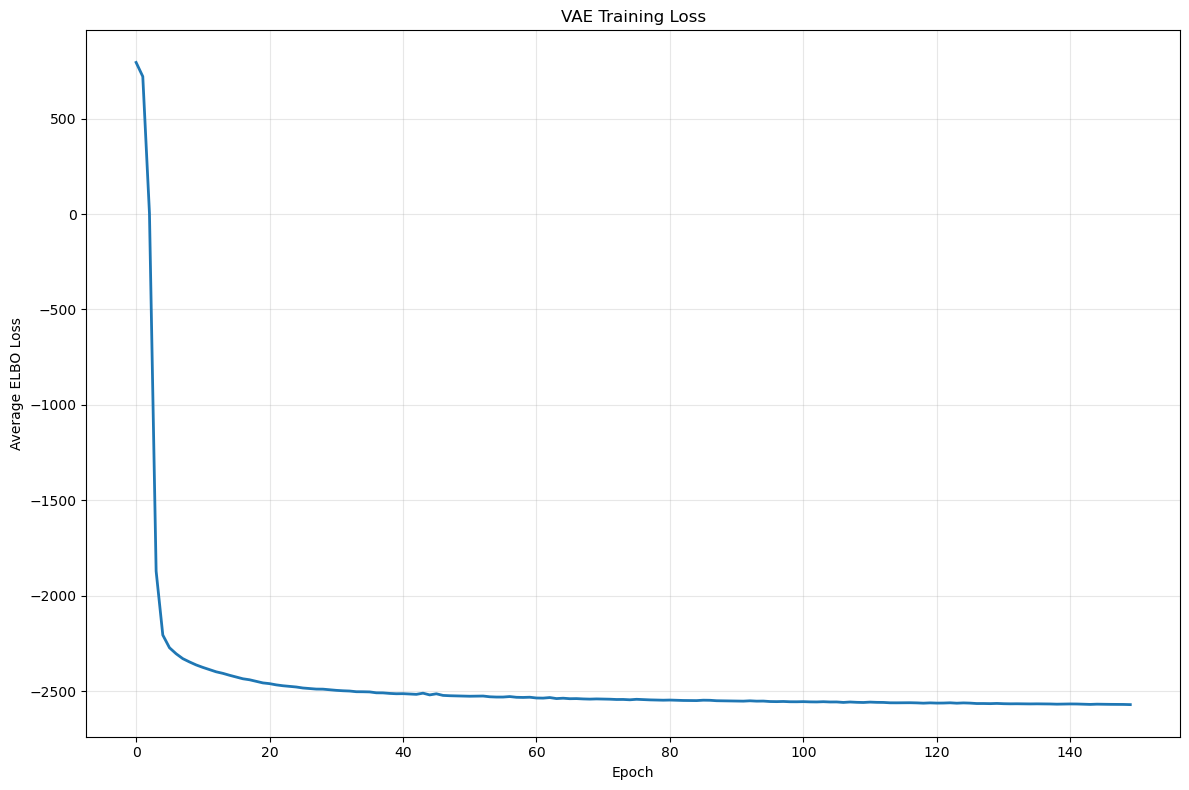

Starting evaluation...
Evaluation complete. Processed 88839 samples.


In [162]:
embedder = BertLogEmbedder()
embedder.fit(train_df)

# data = load_dataset(
#     train_df,
#     test_df,
#     window_size='10m',
#     step_size='1m',
#     n_prediction_window=5,
#     filter_strategy='combined',
#     filter_params={'contamination':0.1},
#     batch_size=4096,
#     embedder=embedder,
#     mode='hybrid',
#     debug=True
# )


# vae = LogAnomalyVAE(
#     input_dim=data['input_dim'],
#     z_dim=64,
#     hidden_dim=256,
#     use_cuda=(data["device"].type == "cuda")
# )

# model 5 was chosen
data = load_dataset(
    train_df,
    test_df,
    window_size='10m',
    step_size='1m',
    n_prediction_window=5,
    filter_strategy='combined',
    filter_params={'contamination':0.1},
    batch_size=4096,
    embedder=embedder,
    mode='hybrid',
    debug=True
)


vae = LogAnomalyVAE(
    input_dim=data['input_dim'],
    z_dim=80,#30,
    hidden_dim=107,#178,
    use_cuda=(data["device"].type == "cuda")
)

train_vae(
    vae,
    data,
    num_epochs=150,
    batch_size=4096,
    lr=1e-4,
    debug=True
)

scores, labels = test_vae(
    vae,
    data,
    eval_batch_size=8192
)

pred_types = data['pred_types_test']
failure_types = data['failure_types_test']
failure_map = data['failure_map_test']


True

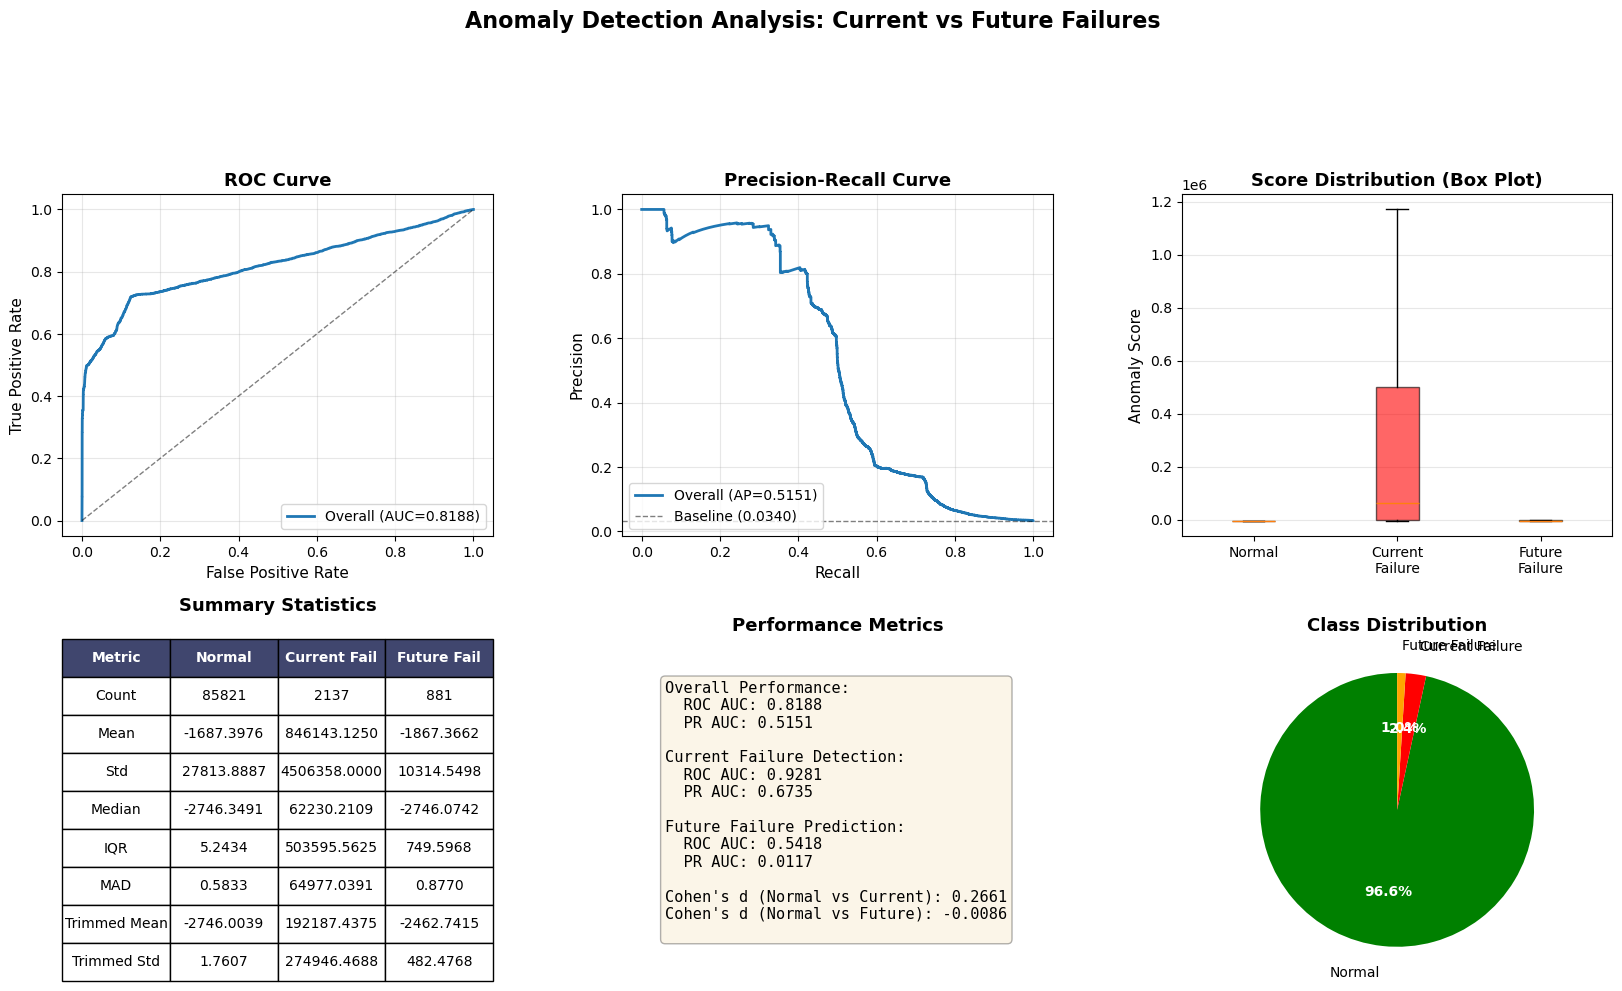

In [163]:
plot_anomaly_detection_analysis(scores, labels, pred_types)
True

Analyzing 27 failure types...


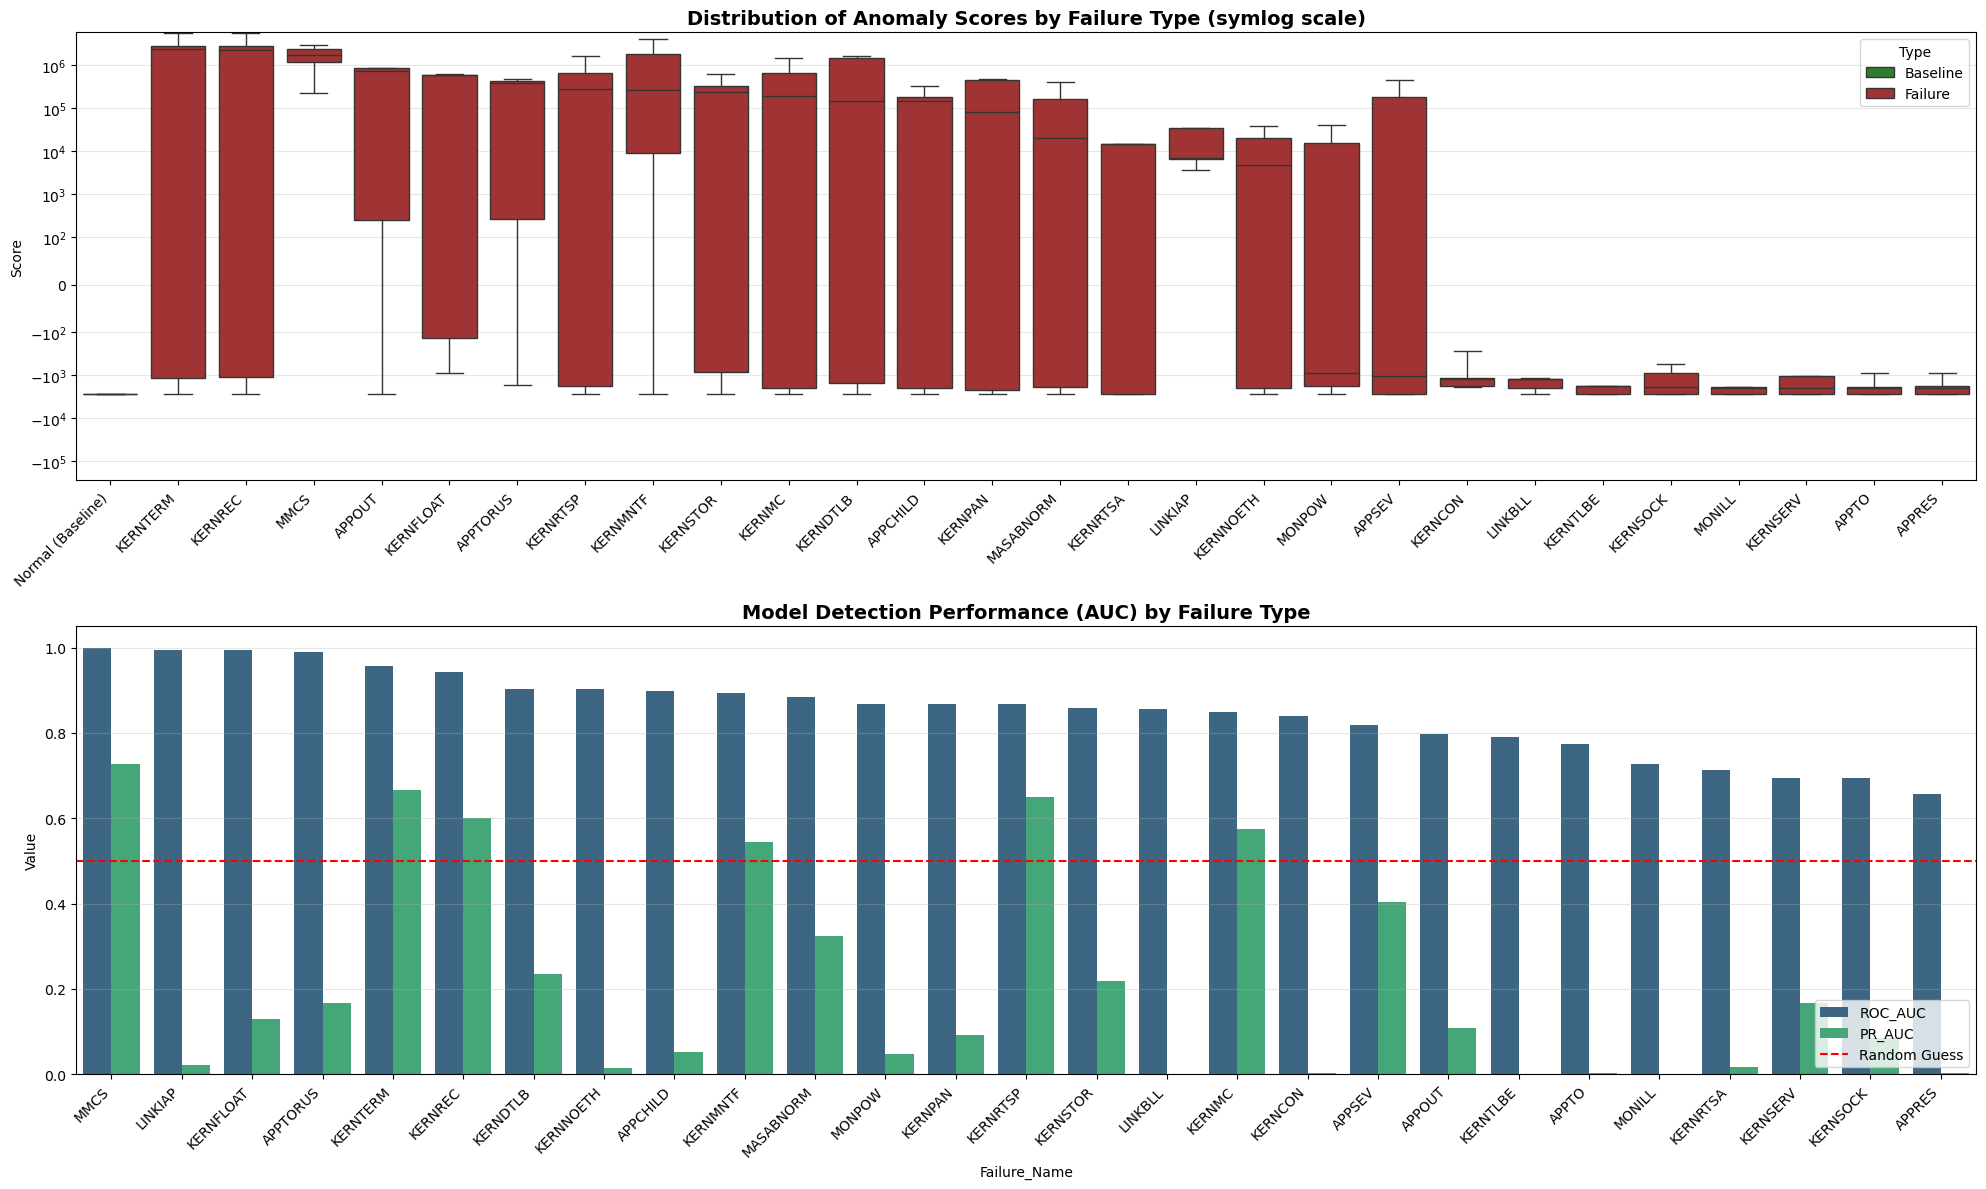

,Failure_Name,Count,ROC_AUC,PR_AUC,Mean_Score,Median_Score,Std_Score
24,MMCS,15,0.999882,0.726968,1.748372e+06,1.672540e+06,8.021220e+05
22,LINKIAP,18,0.994755,0.021305,1.823009e+04,6.776236e+03,2.069570e+04
8,KERNFLOAT,15,0.993421,0.130431,3.940445e+05,5.847556e+05,2.791401e+05
5,APPTORUS,30,0.988776,0.167906,2.592325e+05,3.830690e+05,1.902340e+05
19,KERNTERM,108,0.957585,0.666466,1.808136e+06,2.378864e+06,1.430866e+06
13,KERNREC,122,0.941617,0.600054,1.601288e+06,2.264446e+06,1.463732e+06
7,KERNDTLB,32,0.903611,0.234574,5.439563e+05,1.440490e+05,6.701005e+05
11,KERNNOETH,30,0.902533,0.014623,1.482589e+04,4.628714e+03,3.093093e+04
0,APPCHILD,15,0.899130,0.051676,1.217600e+05,1.439782e+05,9.790781e+04
10,KERNMNTF,160,0.893899,0.544849,2.759488e+06,2.609970e+05,7.111461e+06


In [164]:
plot_failure_analysis(scores, labels, pred_types, failure_types, failure_map)

Analyzing 27 failure types for PRE-FAILURE (Future) detection...
Baseline samples: 85821
Skipping LINKIAP: Found 18 current failures, but only 0 future predictions.
Skipping MMCS: Found 15 current failures, but only 0 future predictions.


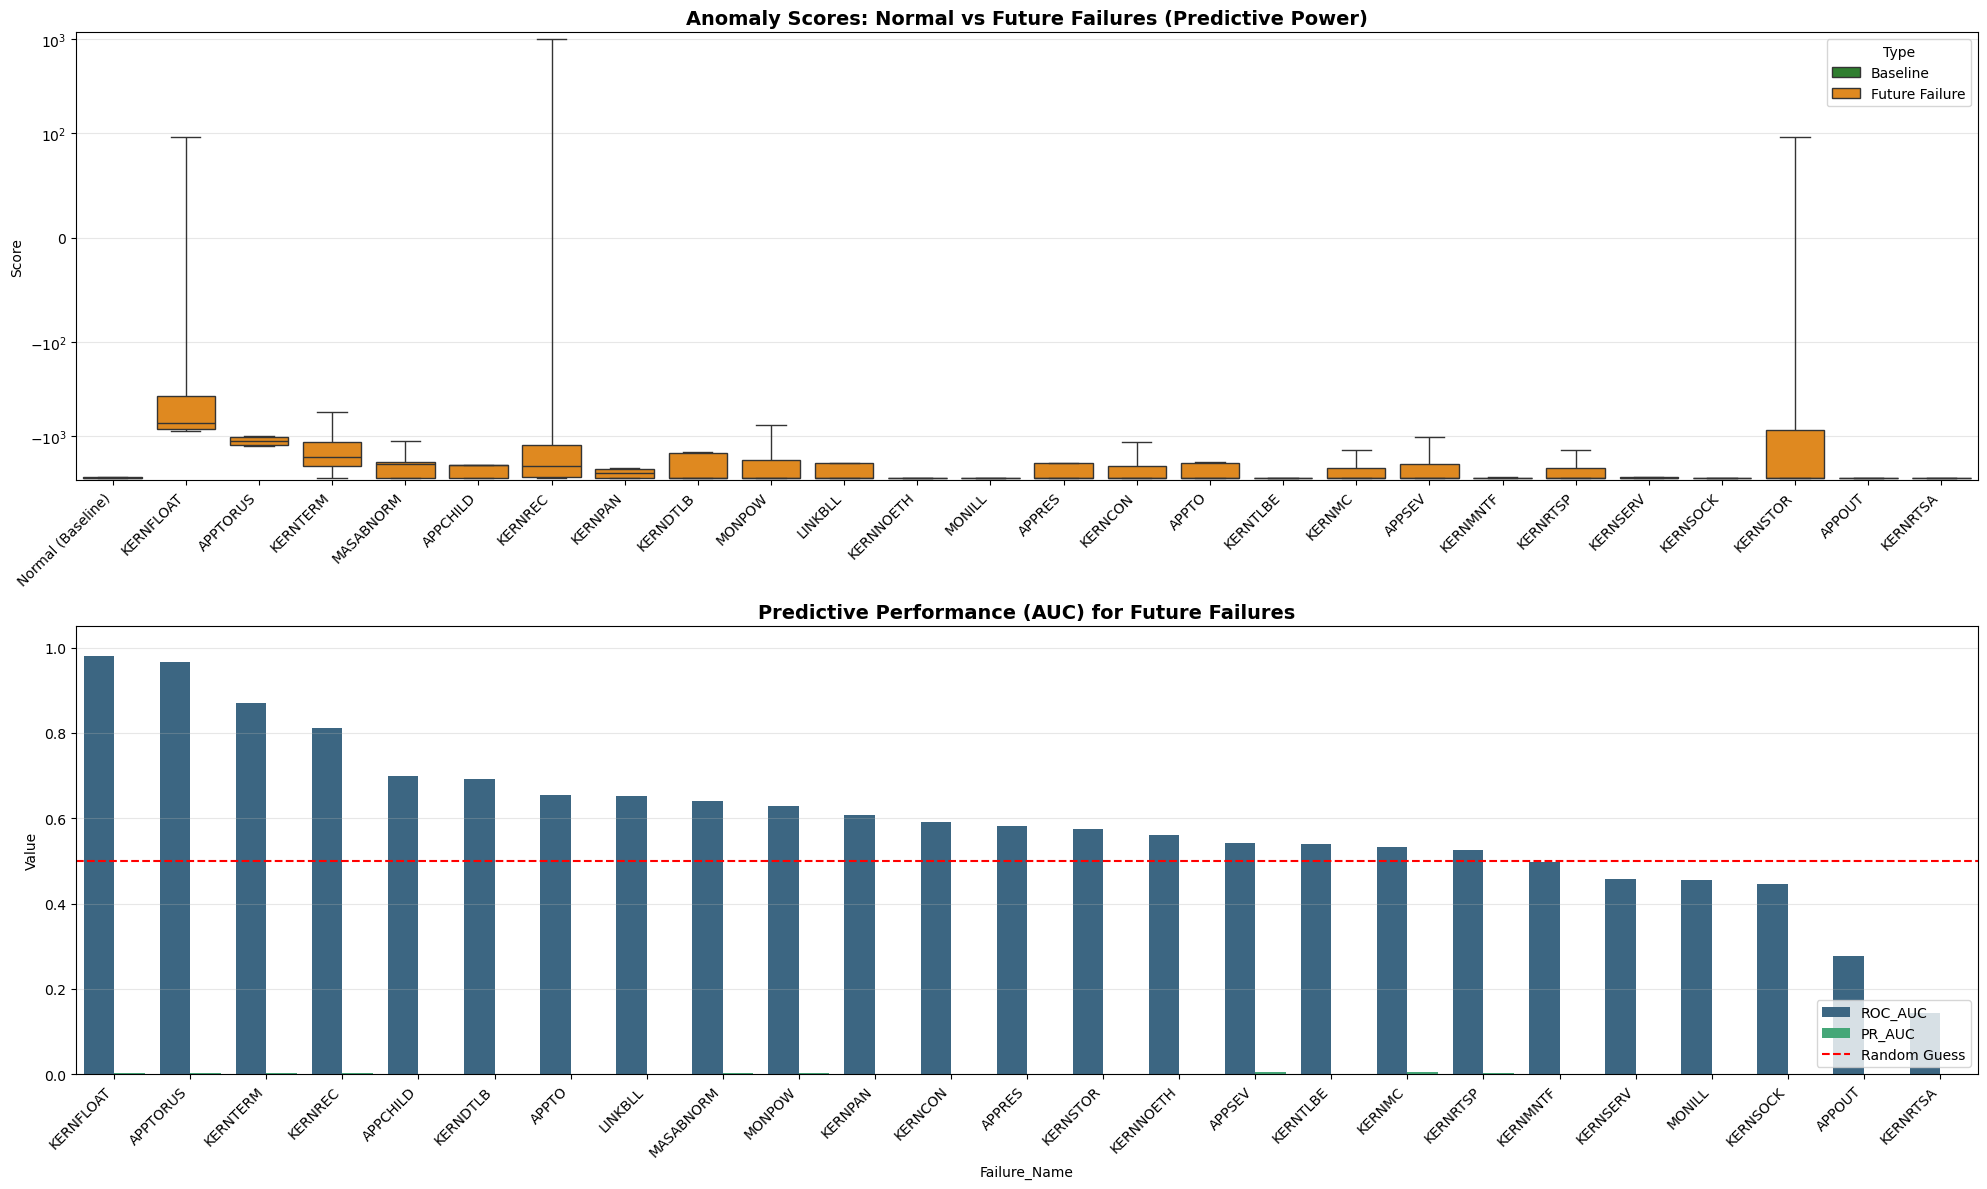

,Failure_Name,Count,Skipped_Current_Failures,ROC_AUC,PR_AUC,Mean_Score,Median_Score,Std_Score
8,KERNFLOAT,5,10,0.980986,0.001749,-545.178589,-721.040833,368.804840
5,APPTORUS,10,20,0.967074,0.001988,-161.506195,-1121.181885,2118.285645
19,KERNTERM,35,73,0.869177,0.002524,-1363.719604,-1656.336548,1207.925293
13,KERNREC,37,85,0.810707,0.002035,-1610.510620,-2052.595215,1169.219360
0,APPCHILD,5,10,0.698810,0.000149,-2302.464600,-2015.416138,362.604218
7,KERNDTLB,10,22,0.692765,0.000274,-2243.894043,-2744.310791,614.675903
4,APPTO,15,47,0.655590,0.000306,-2413.605469,-2745.920898,407.485962
21,LINKBLL,5,10,0.651176,0.000122,-2416.847412,-2744.402100,402.967834
22,MASABNORM,90,195,0.639494,0.002016,-2261.682373,-1959.841553,489.304108
24,MONPOW,30,71,0.628312,0.002398,383.550140,-2744.347168,6302.180664


In [165]:
plot_future_failure_analysis(scores, labels, pred_types, failure_types, failure_map)

## Create Predictor

In [193]:
to_keep = [
    "KERNFLOAT",
    "APPTORUS",
    "KERNTERM",
    "KERNREC",
    "APPCHILD",
    "KERNDTLB",
    "APPTO",
    "LINKBLL",
    "MASABNORM",
    "MONPOW",
    "KERNPAN",
    "KERNCON",
    "APPRES",
    "KERNSTOR",
    "KERNNOETH",
    "APPSEV",
    "KERNTLBE",
    "KERNMC",
    "KERNRTSP",
    "KERNMNTF",
    "KERNSERV",
    "MONILL",
    "KERNSOCK",
    "APPOUT",
    "KERNRTSA",
]


df_isolate = df.with_columns(
    pl.col("Label")
      .is_in(to_keep)
      .alias("Anomaly")
)
df_isolate['Label'].value_counts()

Label,count
str,u32
"""KERNEXT""",1
"""MONPOW""",12
"""KERNCON""",16
"""MASABNORM""",37
"""MONILL""",1
…,…
"""KERNPAN""",18
"""KERNFLOAT""",3
"""KERNBIT""",1


In [194]:
def find_optimal_threshold(y_true, scores):
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
    
    f1_scores = np.nan_to_num(f1_scores)
    
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    return best_threshold, best_f1

In [195]:
def plot_predictor_dashboard(y_true, scores, y_pred, threshold, fpr_label=None):
    fig = plt.figure(figsize=(20, 6))
    
    ax1 = plt.subplot(1, 3, 1)
    
    normal_scores = scores[y_true == 0]
    anomaly_scores = scores[y_true == 1]
    
    bins = 50
    ax1.hist(normal_scores, bins=bins, alpha=0.6, color='green', label='Normal', density=True, log=True)
    ax1.hist(anomaly_scores, bins=bins, alpha=0.6, color='red', label='Anomaly', density=True, log=True)
    
    line_label = f'Threshold ({threshold:.1f})'
    if fpr_label:
        line_label += f"\n[{fpr_label}]"

    ax1.axvline(threshold, color='black', linestyle='--', linewidth=2, label=line_label)
    
    ax1.set_xscale('symlog', linthresh=100)
    
    ax1.set_title("Anomaly Score Distribution", fontsize=12, fontweight='bold')
    ax1.set_xlabel("Anomaly Score (SymLog Scale)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(1, 3, 2)
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)
    
    ax2.plot(recall, precision, color='purple', lw=2, label=f'PR AUC = {pr_auc:.4f}')
    
    from sklearn.metrics import precision_score, recall_score
    curr_prec = precision_score(y_true, y_pred)
    curr_rec = recall_score(y_true, y_pred)
    
    ax2.plot(curr_rec, curr_prec, 'o', markersize=10, color='black', label='Selected Threshold')
    
    ax2.set_title("Precision-Recall Curve", fontsize=12, fontweight='bold')
    ax2.set_xlabel("Recall (Sensitivity)")
    ax2.set_ylabel("Precision")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Pred Normal', 'Pred Anomaly'],
                yticklabels=['True Normal', 'True Anomaly'], ax=ax3, annot_kws={"size": 14})
    
    ax3.set_title("Confusion Matrix", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def evaluate_predictor(vae, data, threshold=None, fpr_target=None):
    print("\n--- Initializing Anomaly Predictor ---")
    
    X_test = data["X_test"]
    y_test = data["y_test"].cpu().numpy()
    
    scores = []
    batch_size = 4096
    
    vae.eval()
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch = X_test[i : i + batch_size]
            batch_scores = vae.get_anomaly_score(batch, n_samples=10)
            scores.append(batch_scores.cpu().numpy())
            
    scores = np.concatenate(scores)
    
    thresh_label = None

    if threshold is not None:
        print(f"Using Manual Threshold: {threshold:.4f}")
        thresh_label = "Manual"
        
    elif fpr_target is not None:
        print(f"Optimizing threshold for {fpr_target*100}% False Positive Rate...")
        normal_scores = scores[y_test == 0]
        threshold = np.percentile(normal_scores, 100 - (fpr_target * 100))
        print(f"FPR Target Threshold Found: {threshold:.4f}")
        thresh_label = f"Target FPR: {fpr_target*100}%"
        
    else:
        print("Optimizing threshold for Max F1-Score...")
        best_thresh, best_f1 = find_optimal_threshold(y_test, scores)
        print(f"Optimal Threshold Found: {best_thresh:.4f} (Max F1: {best_f1:.4f})")
        threshold = best_thresh
        thresh_label = "Max F1-Score"

    y_pred = (scores > threshold).astype(int)
            
    print("\n" + "="*40)
    print(f"PREDICTOR REPORT (Threshold > {threshold:.2f})")
    print("="*40)
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Actual Specificity (Normal Accuracy): {specificity:.4f}")
    
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))    
    
    plot_predictor_dashboard(y_test, scores, y_pred, threshold, fpr_label=thresh_label)
    
    return {
        'threshold': threshold,
        'y_pred': y_pred,
        'scores': scores,
    }

In [196]:
import math

def plot_confusion_matrices(y_true_global, y_pred_global, failure_types, failure_map, pred_types, target_failures=None):
    # 1. Fix Mapping: Create Name -> Index lookup
    # failure_map is {0: 'Name'}, we need {'Name': 0}
    name_to_idx = {name: idx for idx, name in failure_map.items()}

    # Determine list of failures to plot
    if target_failures:
        plot_list = target_failures
    else:
        plot_list = list(name_to_idx.keys())

    # Calculate Grid Size
    num_plots = 1 + len(plot_list)
    cols = 4
    rows = math.ceil(num_plots / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()
    
    # --- 1. Global Aggregate Matrix ---
    cm_global = confusion_matrix(y_true_global, y_pred_global)
    
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greys', cbar=False,
                xticklabels=['Pred Normal', 'Pred Target'],
                yticklabels=['True Normal', 'True Target'],
                ax=axes[0], annot_kws={"size": 14, "weight": "bold"})
    
    axes[0].set_title("GLOBAL RESULT\n(All Targets Combined)", fontsize=13, fontweight='bold', color='black')
    axes[0].set_ylabel("Actual Class")
    axes[0].set_xlabel("Predicted Class")

    # --- 2. Per-Failure Matrices ---
    for i, fail_name in enumerate(plot_list):
        ax = axes[i + 1]
        
        if fail_name not in name_to_idx:
            ax.text(0.5, 0.5, f"{fail_name}\nNot found in map", ha='center')
            continue

        # Correctly get index using the inverted map
        fail_idx = name_to_idx[fail_name]
        
        # --- SUBSETTING LOGIC ---
        # Compare: Pure Normals (0) vs Specific Future Failure (2 + Index)
        mask_normal = (pred_types == 0)
        mask_specific = (pred_types == 2) & (failure_types[:, fail_idx] == 1)
        
        subset_mask = mask_normal | mask_specific
        
        if np.sum(mask_specific) == 0:
            ax.text(0.5, 0.5, "No Samples Found", ha='center')
            ax.set_title(f"{fail_name}", fontweight='bold', color='gray')
            continue
            
        # Extract subset
        y_sub_pred = y_pred_global[subset_mask]
        
        # Ground Truth for this specific plot:
        # 1 if it is THIS failure, 0 if it is Normal
        is_fail_in_subset = mask_specific[subset_mask]
        y_sub_true = is_fail_in_subset.astype(int)
        
        cm = confusion_matrix(y_sub_true, y_sub_pred)
        
        # Calculate Recall
        recall = 0
        if np.sum(y_sub_true) > 0:
            tp = np.sum((y_sub_true == 1) & (y_sub_pred == 1))
            recall = tp / np.sum(y_sub_true)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
                    xticklabels=['Pred Norm', 'Pred Fail'],
                    yticklabels=['Normal', fail_name],
                    ax=ax, annot_kws={"size": 12})
        
        ax.set_title(f"{fail_name}\nRecall: {recall:.1%}", fontsize=11, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Hide unused subplots
    for j in range(num_plots, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_future_predictor(vae, data, threshold=None, fpr_target=None, target_failures=None):    
    print("\n--- Initializing Targeted Future Predictor ---")
    
    X_test = data["X_test"]
    pred_types = data["pred_types_test"].cpu().numpy()
    failure_types = data["failure_types_test"].cpu().numpy()
    
    # failure_map comes in as {0: 'Name', 1: 'Name'}
    failure_map = data["failure_map_test"] 
    
    # Create Name->Index map for logic
    name_to_idx = {name: idx for idx, name in failure_map.items()}

    if target_failures:
        print(f"Targeting {len(target_failures)} specific failure types: {target_failures}")
    else:
        print("Targeting ALL future failure types.")

    # 1. Scoring
    scores_all = []
    batch_size = 4096
    
    vae.eval()
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch = X_test[i : i + batch_size]
            batch_scores = vae.get_anomaly_score(batch, n_samples=5)
            scores_all.append(batch_scores.cpu().numpy())
            
    scores_all = np.concatenate(scores_all)

    # 2. Identify Target Indices
    target_indices = []
    if target_failures:
        for name in target_failures:
            if name in name_to_idx:
                target_indices.append(name_to_idx[name])
            else:
                print(f"Warning: Failure '{name}' not found in failure map.")
    
    # 3. Create Target Mask
    if target_indices:
        # Check if any of the target columns are 1
        is_target_type = np.any(failure_types[:, target_indices] == 1, axis=1)
    else:
        is_target_type = np.ones(len(pred_types), dtype=bool)

    # 4. Filter Dataset
    # Keep: Normals (0) OR Future Failures (2)
    # Drop: Current Failures (1)
    keep_mask = (pred_types == 0) | (pred_types == 2)
    
    scores = scores_all[keep_mask]
    filtered_pred_types = pred_types[keep_mask]
    filtered_is_target = is_target_type[keep_mask]
    filtered_failure_types = failure_types[keep_mask]
    
    # 5. Define Ground Truth
    # 1 = Future Failure AND is a Target Type
    # 0 = Normal OR (Future Failure but NOT Target Type)
    y_true = (filtered_pred_types == 2) & (filtered_is_target)
    y_true = y_true.astype(int)

    print(f"Data Filtered: {len(scores_all)} -> {len(scores)} samples")
    print(f"  - Class 0 (Normal + Ignored Futures): {np.sum(y_true == 0)}")
    print(f"  - Class 1 (Target Future Failures): {np.sum(y_true == 1)}")
    
    # 6. Thresholding
    normal_scores = scores[y_true == 0]

    if threshold is not None:
        print(f"Using Manual Threshold: {threshold:.4f}")
        
    elif fpr_target is not None:
        print(f"Optimizing threshold for {fpr_target*100}% False Positive Rate...")
        threshold = np.percentile(normal_scores, 100 - (fpr_target * 100))
        print(f"FPR Target Threshold Found: {threshold:.4f}")
        
    else:
        print("Optimizing threshold for Max F1-Score...")
        t_min, t_max = scores.min(), scores.max()
        best_f1 = 0
        best_thresh = 0
        
        # Logspace grid search
        for t in np.logspace(np.log10(max(t_min, 1e-6)), np.log10(t_max), 100):
            y_p = (scores > t).astype(int)
            f1 = f1_score(y_true, y_p)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t
                
        print(f"Optimal Threshold Found: {best_thresh:.4f} (Max F1: {best_f1:.4f})")
        threshold = best_thresh

    y_pred = (scores > threshold).astype(int)
            
    print("\n" + "="*40)
    print(f"PREDICTOR REPORT (Threshold > {threshold:.2f})")
    print("="*40)
    
    print(classification_report(y_true, y_pred, target_names=['Normal/Other', 'Target Failure']))    
    
    plot_confusion_matrices(
        y_true, 
        y_pred, 
        filtered_failure_types,
        failure_map,
        filtered_pred_types,
        target_failures
    )
    
    return {
        'threshold': threshold,
        'y_pred': y_pred,
        'y_true': y_true,
        'scores': scores,
    }

## Balanced


--- Initializing Anomaly Predictor ---
Optimizing threshold for Max F1-Score...
Optimal Threshold Found: 4415.7075 (Max F1: 0.5564)

PREDICTOR REPORT (Threshold > 4415.71)
Actual Specificity (Normal Accuracy): 0.9923
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99     85821
     Anomaly       0.68      0.47      0.56      3018

    accuracy                           0.97     88839
   macro avg       0.83      0.73      0.77     88839
weighted avg       0.97      0.97      0.97     88839



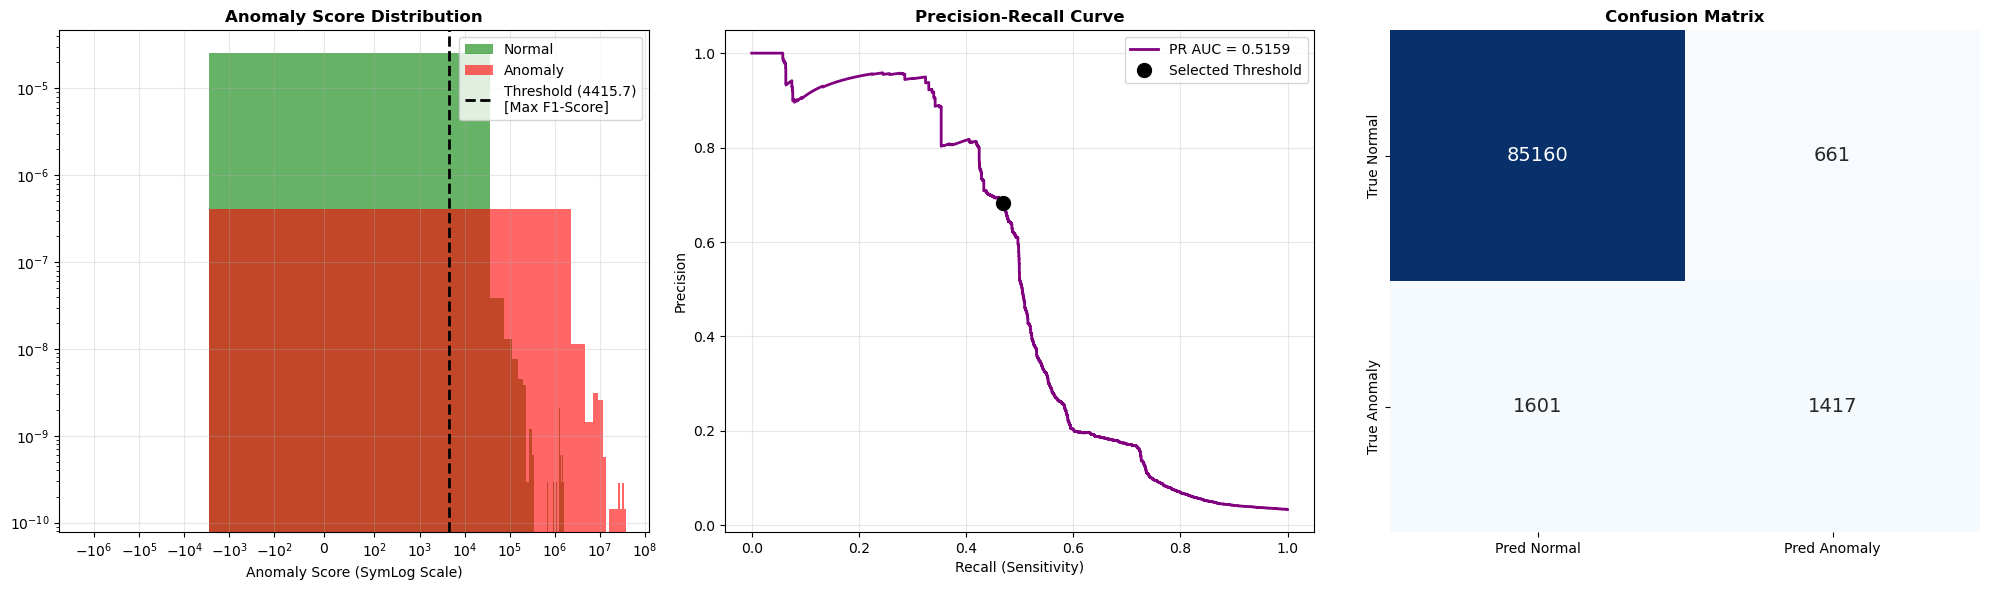

{'threshold': np.float32(4415.7075),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(88839,)),
 'scores': array([-1146.1827, -1271.5653, -1328.7938, ..., -2746.4412, -2746.7744,
        -2744.2966], shape=(88839,), dtype=float32)}

In [197]:
results = evaluate_predictor(vae, data)
results

## Focus on finding anomalies


--- Initializing Anomaly Predictor ---
Optimizing threshold for 5.0% False Positive Rate...
FPR Target Threshold Found: -1336.1735

PREDICTOR REPORT (Threshold > -1336.17)
Actual Specificity (Normal Accuracy): 0.9500
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.97     85821
     Anomaly       0.28      0.56      0.38      3018

    accuracy                           0.94     88839
   macro avg       0.63      0.76      0.67     88839
weighted avg       0.96      0.94      0.95     88839



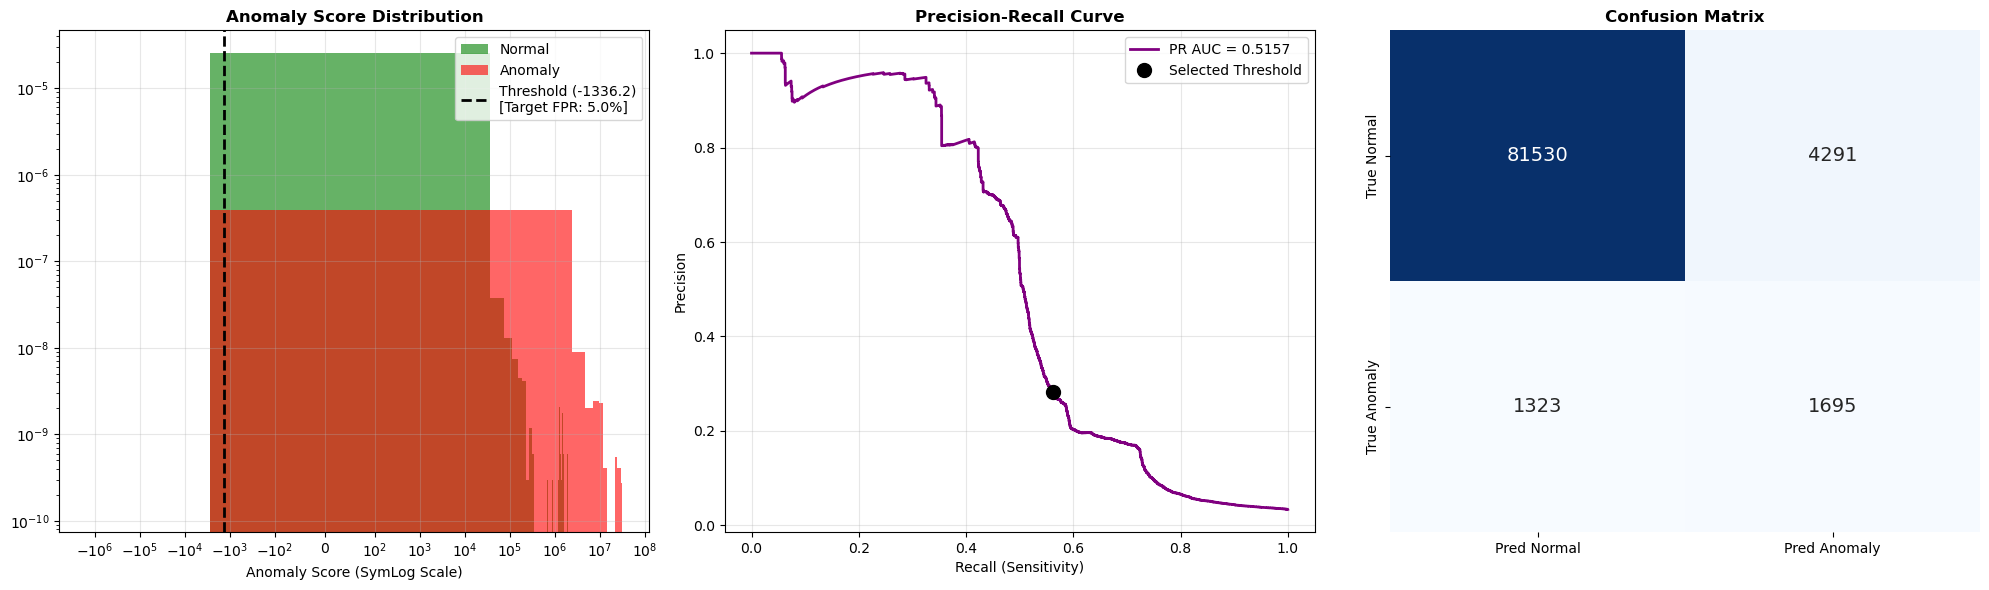

{'threshold': np.float32(-1336.1735),
 'y_pred': array([1, 1, 1, ..., 0, 0, 0], shape=(88839,)),
 'scores': array([-1160.5084, -1277.1661, -1332.8071, ..., -2746.678 , -2746.9392,
        -2746.9773], shape=(88839,), dtype=float32)}

In [230]:
results = evaluate_predictor(vae, data, fpr_target=0.05)
results


--- Initializing Targeted Future Predictor ---
Targeting 25 specific failure types: ['KERNFLOAT', 'APPTORUS', 'KERNTERM', 'KERNREC', 'APPCHILD', 'KERNDTLB', 'APPTO', 'LINKBLL', 'MASABNORM', 'MONPOW', 'KERNPAN', 'KERNCON', 'APPRES', 'KERNSTOR', 'KERNNOETH', 'APPSEV', 'KERNTLBE', 'KERNMC', 'KERNRTSP', 'KERNMNTF', 'KERNSERV', 'MONILL', 'KERNSOCK', 'APPOUT', 'KERNRTSA']
Data Filtered: 88839 -> 86702 samples
  - Class 0 (Normal + Ignored Futures): 85821
  - Class 1 (Target Future Failures): 881
Using Manual Threshold: -1336.1735

PREDICTOR REPORT (Threshold > -1336.17)
                precision    recall  f1-score   support

  Normal/Other       0.99      0.95      0.97     85821
Target Failure       0.02      0.08      0.03       881

      accuracy                           0.94     86702
     macro avg       0.50      0.52      0.50     86702
  weighted avg       0.98      0.94      0.96     86702



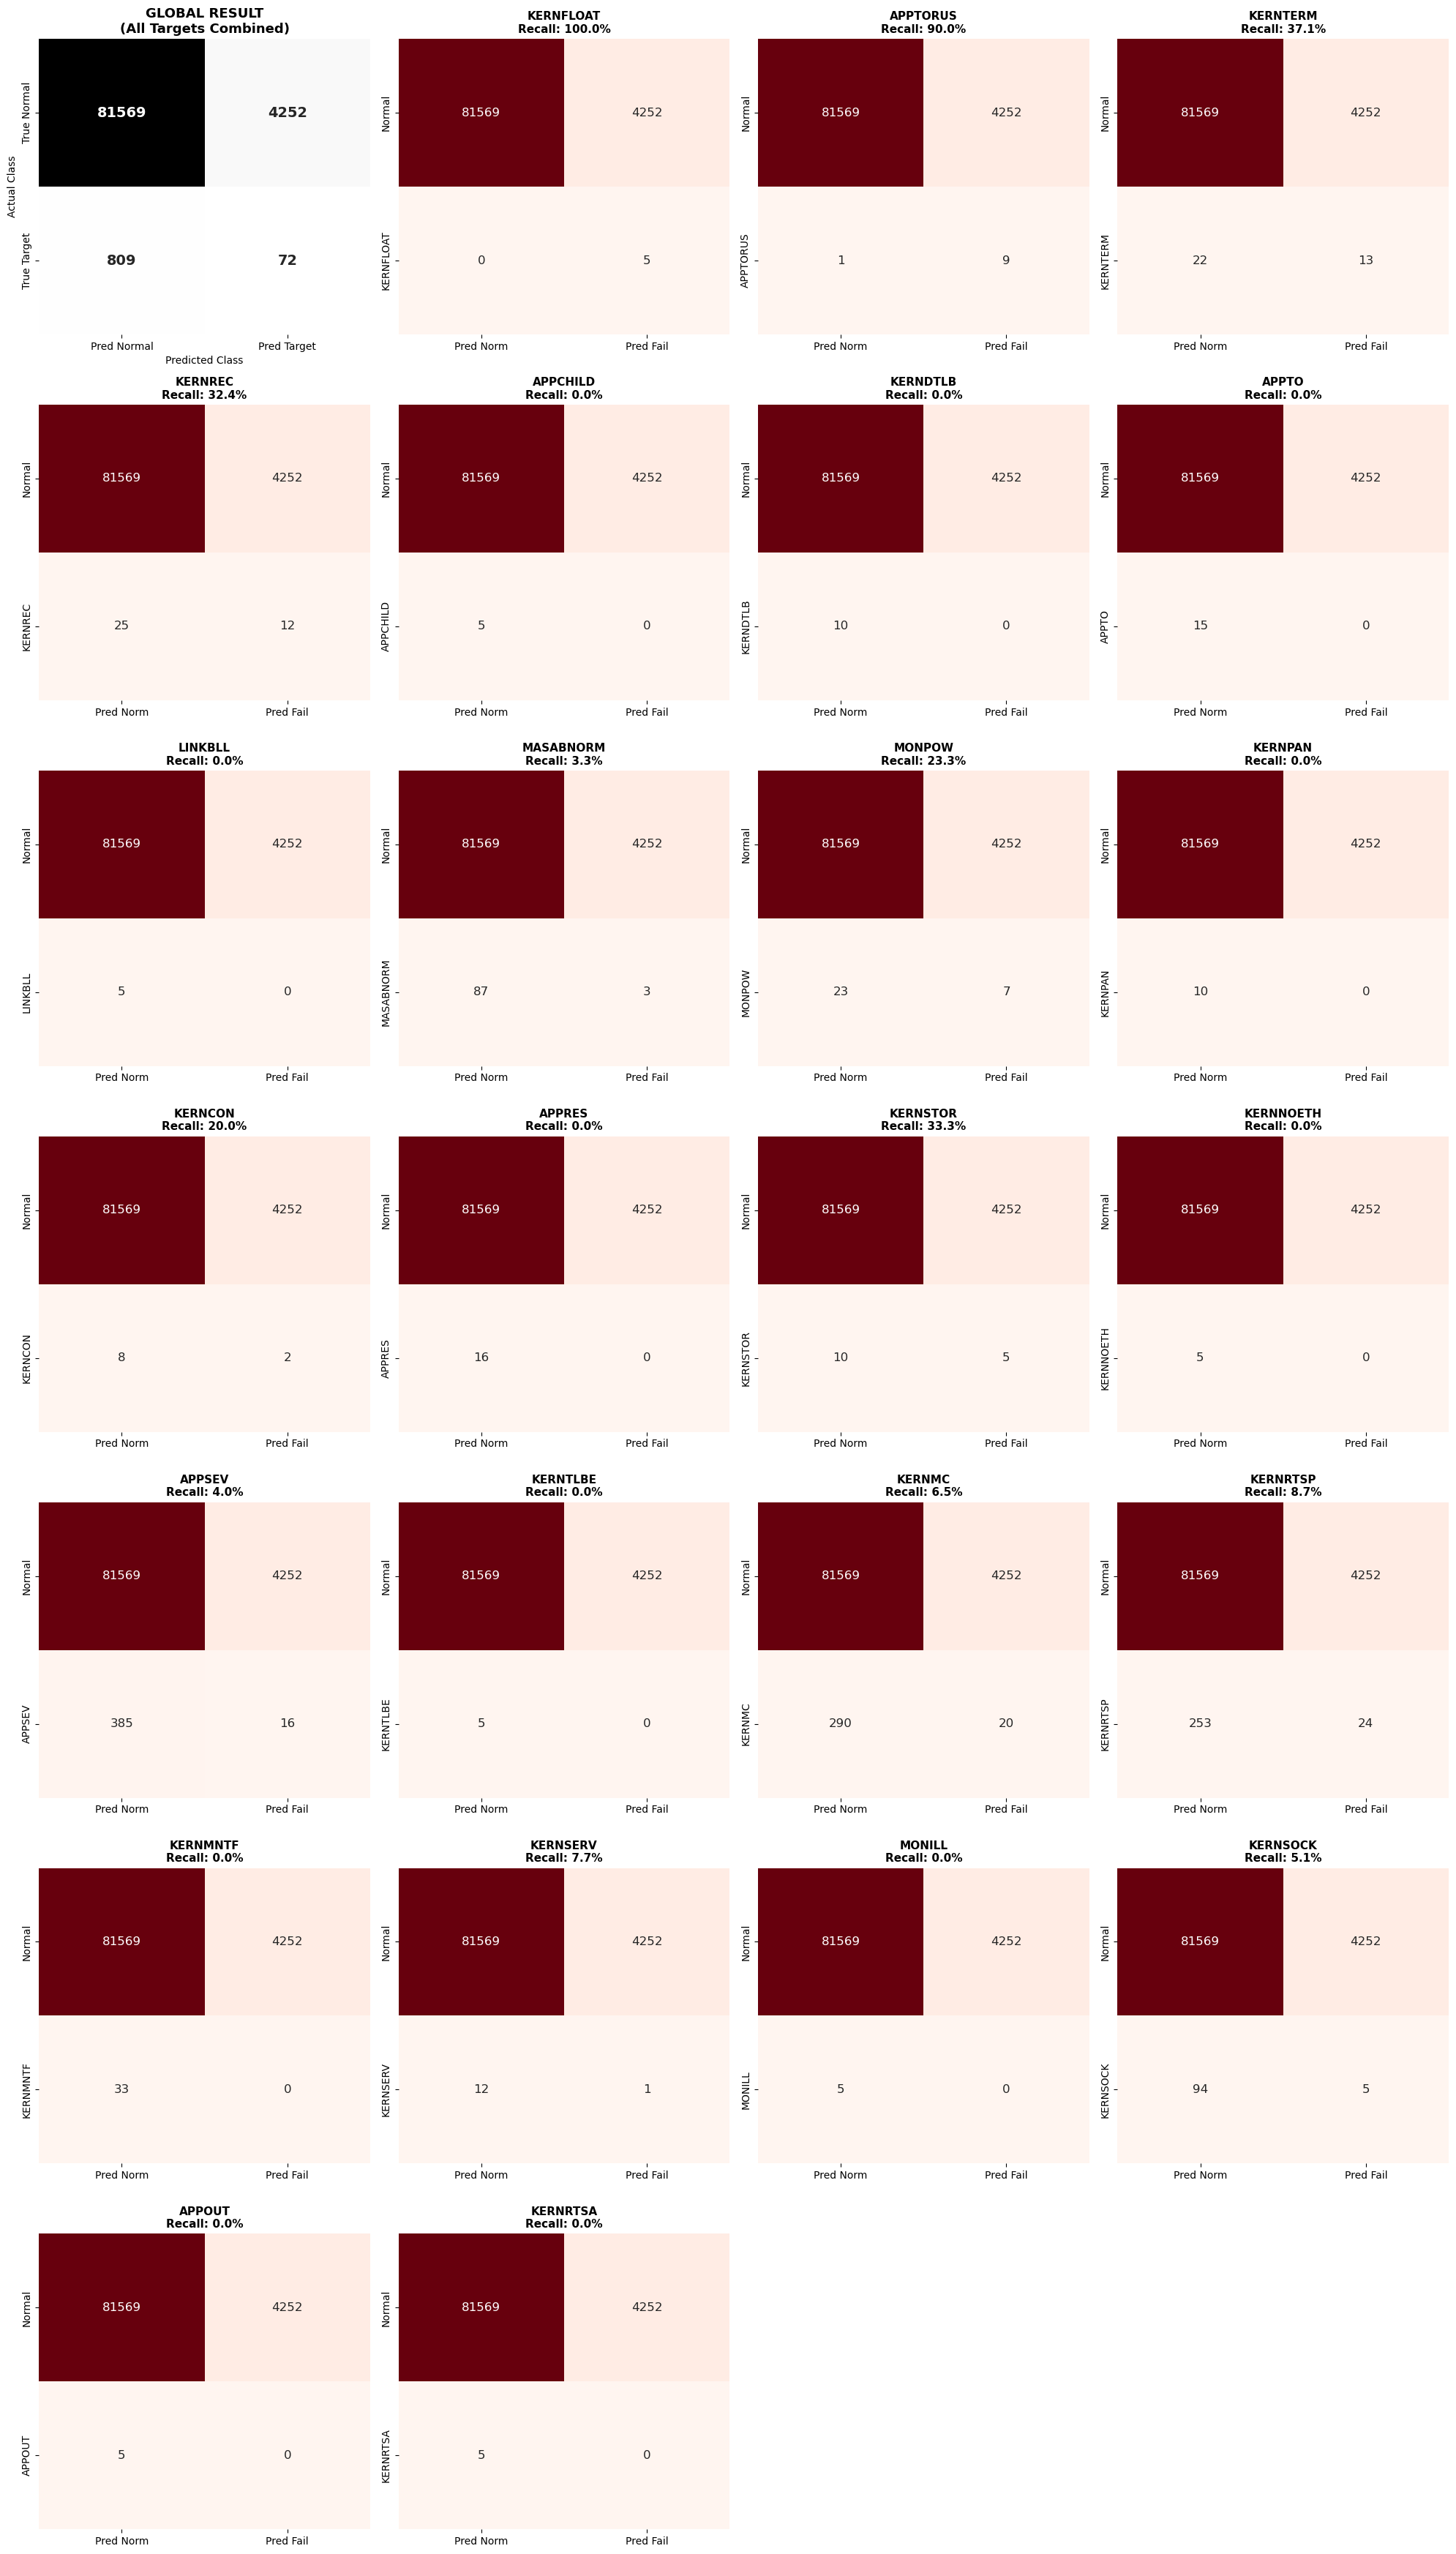

{'threshold': np.float32(-1336.1735),
 'y_pred': array([1, 1, 0, ..., 0, 0, 0], shape=(86702,)),
 'y_true': array([0, 0, 0, ..., 1, 1, 1], shape=(86702,)),
 'scores': array([-1190.5636, -1283.1932, -1342.1661, ..., -2747.044 , -2747.0393,
        -2746.956 ], shape=(86702,), dtype=float32)}

In [231]:
evaluate_future_predictor(vae, data, target_failures=to_keep, threshold=results['threshold'])

In [213]:
def evaluate_prediction_types(vae, data, threshold):    
    X_test = data["X_test"]
    pred_types = data["pred_types_test"].cpu().numpy() 
    
    scores = []
    batch_size = 4096
    vae.eval()
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch = X_test[i : i + batch_size]
            batch_scores = vae.get_anomaly_score(batch, n_samples=5)
            scores.append(batch_scores.cpu().numpy())
    scores = np.concatenate(scores)
    
    df = pd.DataFrame({
        'Score': scores,
        'Type_ID': pred_types
    })
    
    type_map = {0: 'Normal', 1: 'Clear Failure (Current)', 2: 'Future Failure (Predict)'}
    df['Type'] = df['Type_ID'].map(type_map)
    
    df['Detected'] = df['Score'] > threshold
    
    stats = df.groupby('Type').agg(
        Count=('Score', 'count'),
        Mean_Score=('Score', 'mean'),
        Median_Score=('Score', 'median'),
        Detection_Rate=('Detected', 'mean')
    ).reindex(['Normal', 'Clear Failure (Current)', 'Future Failure (Predict)'])
    
    print("\nStatistics per Prediction Type:")
    print(stats)
    
    fig = plt.figure(figsize=(18, 6))
    
    ax1 = plt.subplot(1, 3, 1)
    sns.boxplot(data=df, x='Type', y='Score', order=type_map.values(), 
                palette=['forestgreen', 'firebrick', 'orange'], ax=ax1, showfliers=False)
    
    ax1.axhline(threshold, color='black', linestyle='--', linewidth=2, label='Alert Threshold')
    ax1.set_yscale('symlog', linthresh=100)
    ax1.set_title('Anomaly Scores by Context', fontweight='bold')
    ax1.set_xlabel('')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, axis='y', alpha=0.3)
    
    ax2 = plt.subplot(1, 3, 2)
    
    colors = ['green', 'red', 'orange']
    bars = ax2.bar(stats.index, stats['Detection_Rate'] * 100, color=colors, alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
        
    ax2.set_ylabel('Detection Rate (%)')
    ax2.set_title(f'Detection Rate (Threshold > {threshold:.1f})', fontweight='bold')
    ax2.set_ylim(0, 110)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, axis='y', alpha=0.3)

    ax3 = plt.subplot(1, 3, 3)
    
    sns.kdeplot(data=df[df['Type'] == 'Normal'], x='Score', fill=True, color='green', label='Normal', ax=ax3)
    sns.kdeplot(data=df[df['Type'] == 'Future Failure (Predict)'], x='Score', fill=True, color='orange', label='Future Failure', ax=ax3)
    
    ax3.axvline(threshold, color='black', linestyle='--')
    ax3.set_xscale('symlog', linthresh=100)
    ax3.set_title('Density: Normal vs Future Failure', fontweight='bold')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()


Statistics per Prediction Type:
                          Count     Mean_Score  Median_Score  Detection_Rate
Type                                                                        
Normal                    85821   -1686.815308  -2746.547119        0.078501
Clear Failure (Current)    2137  844695.187500  48889.144531        0.791296
Future Failure (Predict)    881   -1880.057007  -2746.243164        0.119183


/tmp/ipykernel_83639/1814507627.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Type', y='Score', order=type_map.values(),


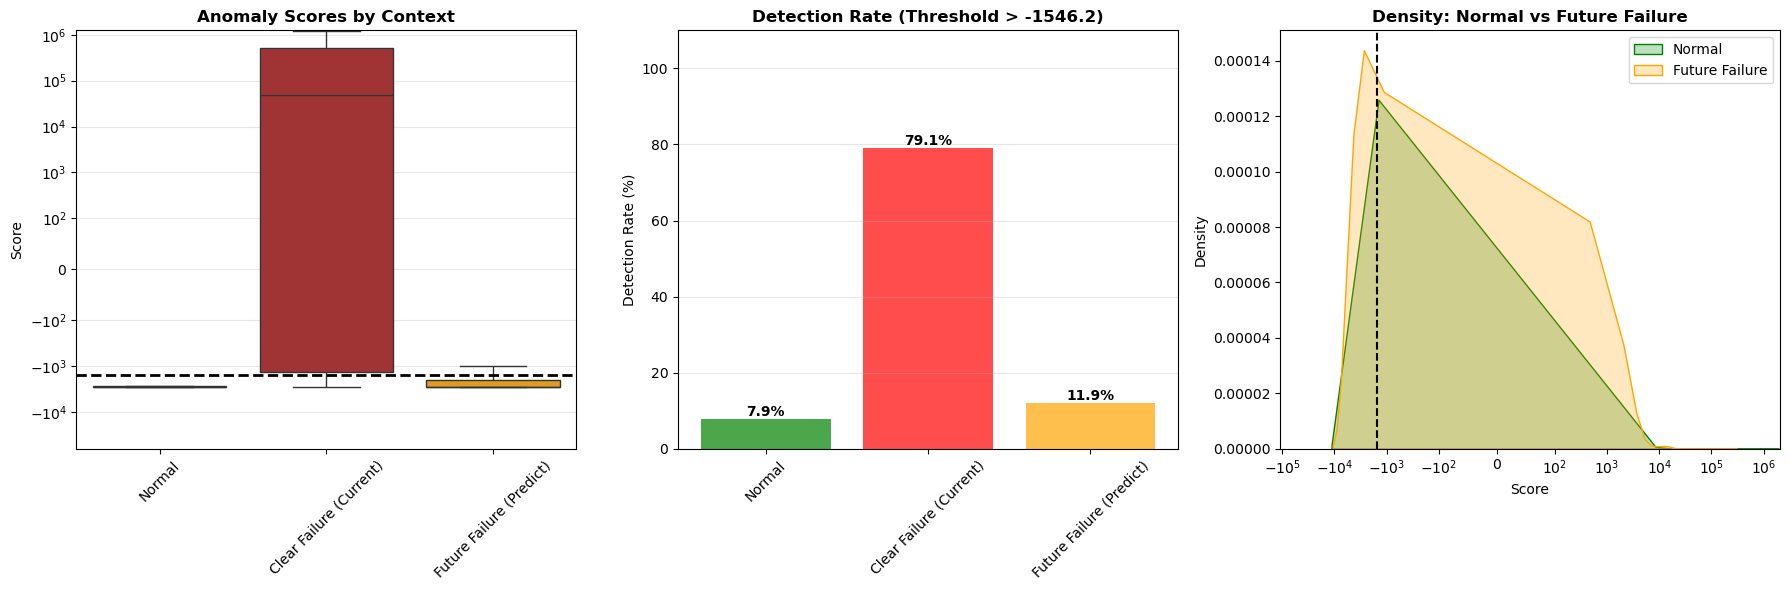

In [209]:
evaluate_prediction_types(vae, data, results['threshold'])

In [210]:
def analyze_caught_failures(vae, data, threshold=None, fpr_target=0.10):
    print(f"\n--- Analyzing Predictable Failures ---")
    
    X_test = data["X_test"]
    failure_types_tensor = data["failure_types_test"] 
    pred_types = data["pred_types_test"].cpu().numpy()
    
    scores = []
    vae.eval()
    with torch.no_grad():
        for i in range(0, len(X_test), 4096):
            batch = X_test[i : i + 4096]
            scores.append(vae.get_anomaly_score(batch, n_samples=5).cpu().numpy())
    scores = np.concatenate(scores)
    
    mask_normal = pred_types == 0
    normal_scores = scores[mask_normal]
    if not threshold:
        threshold = np.percentile(normal_scores, 100 - (fpr_target * 100))
    print(f"Threshold set to: {threshold:.2f}")
    
    mask_future = pred_types == 2
    future_indices = np.where(mask_future)[0]
    
    future_scores = scores[future_indices]
    future_failures = failure_types_tensor[future_indices].cpu().numpy()
    
    caught_mask = future_scores > threshold
    caught_indices = np.where(caught_mask)[0]
    
    print(f"Total Future Failures: {len(future_indices)}")
    print(f"Caught Future Failures: {len(caught_indices)} ({len(caught_indices)/len(future_indices)*100:.1f}%)")
    
    failure_map = data['failure_map_train']
    
    caught_counts = {}
    total_counts = {}
    
    for i in range(len(future_failures)):
        active_failures = np.where(future_failures[i] == 1)[0]
        for idx in active_failures:
            try:
                name = failure_map[idx]
                total_counts[name] = total_counts.get(name, 0) + 1
            except KeyError:
                pass
            
    for i in caught_indices:
        active_failures = np.where(future_failures[i] == 1)[0]
        for idx in active_failures:
            try:
                name = failure_map[idx]
                caught_counts[name] = caught_counts.get(name, 0) + 1    
            except KeyError:
                pass
            
    results = []
    for name, total in total_counts.items():
        caught = caught_counts.get(name, 0)
        rate = caught / total if total > 0 else 0
        results.append({
            "Failure Type": name,
            "Total Instances": total,
            "Predicted": caught,
            "Success Rate": rate
        })
        
    df_res = pd.DataFrame(results).sort_values(by="Success Rate", ascending=False)
    return df_res

df_res = analyze_caught_failures(vae, data, threshold=results['threshold'])
df_res


--- Analyzing Predictable Failures ---
Threshold set to: -1546.19
Total Future Failures: 881
Caught Future Failures: 102 (11.6%)


,Failure Type,Total Instances,Predicted,Success Rate
14,KERNBIT,5,5,1.000000
8,APPSEV,10,9,0.900000
6,KERNPOW,35,15,0.428571
20,APPUNAV,10,4,0.400000
5,KERNMC,37,14,0.378378
7,KERNPAN,15,5,0.333333
4,KERNTERM,30,7,0.233333
19,APPTORUS,10,2,0.200000
2,KERNMNT,277,35,0.126354
11,APPREAD,401,38,0.094763



--- Predictability by Category ---
                        Total_Instances  Total_Predicted  Success_Rate
Category                                                              
Kernel (OS/Hardware)                979              179       0.18284
Application (Software)              472               81       0.17161


/tmp/ipykernel_83639/1924285695.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_stats.index, y=category_stats['Success_Rate'] * 100, palette='viridis')


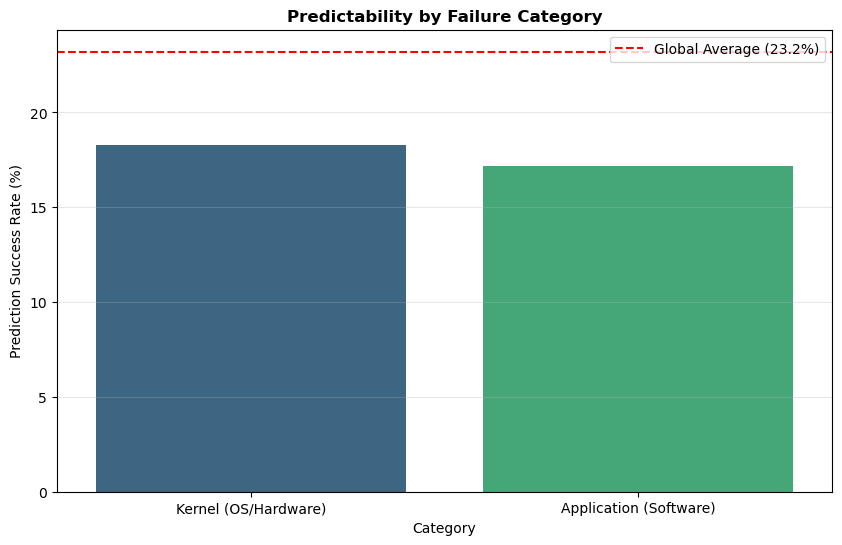

In [176]:
def analyze_failure_categories(df_results):
    def get_category(name):
        if name.startswith('APP'): return 'Application (Software)'
        if name.startswith('KERN'): return 'Kernel (OS/Hardware)'
        if name.startswith('LINK'): return 'Link (Network)'
        if name.startswith('MON') or name.startswith('MAS'): return 'System Monitor'
        return 'Other'

    df_results['Category'] = df_results['Failure Type'].apply(get_category)
    
    category_stats = df_results.groupby('Category').agg(
        Total_Instances=('Total Instances', 'sum'),
        Total_Predicted=('Predicted', 'sum')
    )
    
    category_stats['Success_Rate'] = category_stats['Total_Predicted'] / category_stats['Total_Instances']
    category_stats = category_stats.sort_values(by='Success_Rate', ascending=False)
    
    print("\n--- Predictability by Category ---")
    print(category_stats)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_stats.index, y=category_stats['Success_Rate'] * 100, palette='viridis')
    plt.ylabel('Prediction Success Rate (%)')
    plt.title('Predictability by Failure Category', fontweight='bold')
    plt.axhline(y=23.2, color='red', linestyle='--', label='Global Average (23.2%)')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

analyze_failure_categories(df_res)